In [1]:
!jupyter nbconvert --to html GMM.ipynb

[NbConvertApp] Converting notebook GMM.ipynb to html
[NbConvertApp] Writing 8090327 bytes to GMM.html


In [2]:
from __future__ import division
import numpy as np
from astroML.density_estimation import KDE as KDE
from astroML.plotting.tools import draw_ellipse
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.optimize import curve_fit
from astropy.table import Table
from scipy import stats,interpolate

import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle, os
%matplotlib inline

In [3]:
def compute_GMM(N, covariance_type='full', n_iter=9000, MP=True,data=None,irand=None):
    
    if data is None:
        data=X
        
    models = [None for n in N]
    if MP:   #currently broken :(
        def GMline(data,n,n_iter):
            model= GaussianMixture(n,max_iter=n_iter)
            model.fit(data)
            return model
        pool = mp.Pool(processes=4)
        output = [pool.apply_async(GMline,args=(data,n,n_iter,)) for n in N]
        models = np.array([p.get() for p in output])
        pool.close()
    else:
        for i in range(len(N)):
            #print N[i]
            models[i] = GaussianMixture(N[i],max_iter=n_iter,random_state=irand)
            models[i].fit(data)
    return models

def foo(data,model,tol=3):
    labels=model.predict(data)
    out=[]
    print(len(data))
    for i,item in enumerate(data):
        label=labels[i]
        mu=model.means_[label]
        C=model.covariances_[label]
        # find principal components and rotation angle of ellipse
        sigma_x2 = C[0, 0]
        sigma_y2 = C[1, 1]
        sigma_xy = C[0, 1]

        alpha = 0.5 * np.arctan2(2 * sigma_xy, (sigma_x2 - sigma_y2))
        tmp1 = 0.5 * (sigma_x2 + sigma_y2)
        tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

        sigma1 = np.sqrt(tmp1 + tmp2)
        sigma2 = np.sqrt(tmp1 - tmp2)
        
        pvec=(item[0]-mu[0],item[1]-mu[1])
        px=pvec[0]
        py=pvec[1]
        if sigma1>sigma2:
            a=sigma1
            b=sigma2
        else:
            a=sigma2
            b=sigma1
        
        nsigma2=((px*np.cos(-alpha)+py*np.sin(-alpha))/a)**2\
               +((px*np.sin(-alpha)+py*np.cos(-alpha))/b)**2
        #print(label,mu,nsigma2)
        if nsigma2<=tol**2:
            out.append(item)
    out=np.array(out)
    return out

def foo2(odata,model,tol=-3,weighted=True, nmodel=None, ntol=3.5, iprint=False,selcrit=1):
    lod=len(odata[0])
    lx=len(X[0])
    if lod !=lx:
        data=(np.array(odata)[:,1:]).astype(float)
        keys=np.array(odata)[:,0]
    else:
        data=odata
        
    probs=model._estimate_weighted_log_prob(data) if weighted else model._estimate_log_prob(data)
    out=[]
    outkeys=[]
    
#     ####TEMP
#     allBH=[]
#     allnBH=[]
    selBH=[]
    selnBH=[]

    if nmodel is None:
        for i in range(len(data)):
            prob=probs[i]
            if np.max(prob)>=tol:
                out.append(data[i])
                if lod != lx: outkeys.append(keys[i])
    else:
        nprobs=nmodel._estimate_weighted_log_prob(data) if weighted else nmodel._estimate_log_prob(data)
        for i in range(len(data)):
            prob=probs[i]
            nprob=nprobs[i]
            pBH=np.max(prob)
            pnBH=np.max(nprob)
#             allBH.append(np.max(prob))
#             allnBH.append(np.max(nprob))
            if iprint:
                print('%s:\t p(BH)=%g, p(nBH)=%g'%(keys[i],np.max(prob),np.max(nprob)))
            if selcrit==1:
                if np.max(prob)>=tol:
                    if np.max(nprob)<ntol:
                        out.append(data[i])
                        if lod != lx: outkeys.append(keys[i])
            elif selcrit==2:
                if pBH<0:
                    if pBH*tol>=pnBH:
                        out.append(data[i])
                        if lod != lx: outkeys.append(keys[i])
                else:
                    if pBH/tol>=pnBH:
                        out.append(data[i])
                        if lod != lx: outkeys.append(keys[i])
            elif selcrit==3: #tol is the mimimum prob to be a BH, ntol is the required difference
                if (np.max(prob)>=tol) and (np.max(prob)-np.max(nprob)>ntol):
                    out.append(data[i])
                    selBH.append(np.max(prob))
                    if lod != lx: outkeys.append(keys[i])
            else:
                print('ERROR! Invalid selcrit value')
    if len(out)==0: out=np.full((1,lod),-99)
    out=np.array(out)
    
#     llim=np.min([np.percentile(allBH,1),np.percentile(allnBH,1)])
#     ulim=np.max([np.max(allBH),np.max(allnBH)])
#     plt.hist(allBH,range=(llim,ulim))
#     plt.hist(allnBH,range=(llim,ulim))
#     plt.hist(selBH)
#     plt.show()
    return out if lod == lx else (outkeys,out)

def foo3(data,model,tol=0.001,weighted=True):
    probs=model._estimate_weighted_log_prob(data) if weighted else model._estimate_log_prob(data)
    out=[]
    for i in range(len(data)):
        prob=probs[i]
        if np.sum(10**prob)>=tol:
            out.append(data[i])
    out=np.array(out)
    return out

def openMACHO(key):
    fnum=key.split('.')[0]
    data=Table.read('/net/geha/mgeha/MACHO/F_%s/%s'%(fnum,key),data_start=2,format='ascii')
    MJD=data['col1']
    Rmag=data['col7']
    Rerr=data['col8']
    data=np.array([MJD,Rmag,Rerr])
    return data
#     errtol=np.max([0.2,np.percentile(Rerr,90)])
#     Rerrkeep=abs(Rerr)<errtol
#     RMJD=MJD[Rerrkeep]
#     Rmag=Rmag[Rerrkeep]
#     Rerr=Rerr[Rerrkeep]

def load_obj(name, direc='obj/' ):
    with open(direc + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def Multifunc(order):
    def func(x, *a):
        out= 0
        for i in range(order):
            out += a[i]*np.cos(2*(i+1)*np.pi*x)
        for i in range(order,2*order):
            out += a[i]*np.sin(2*(i+1-order)*np.pi*x)
        out += a[2*order]
        return out
    return func

def chain4(x,y,z=None,dl=0.1,sort=True):
    '''
    Drop a chain starting at the maximum assuming a max chain length.
    
    Params:
    x: phase data
    y: mag data
    z: error data
    dl: chain length
    sort: is the data pre-sorted in phase-space?
    '''
    if z is None:
        zz=np.full(len(x),-99)
    else:
        zz=z
    xc=np.array([])
    yc=np.array([])
    zc=np.array([])
    if sort:
        isort=np.argsort(x)
        x=x[isort]
        y=y[isort]
        if z is not None:
            zz=zz[isort]
    imax=np.argmax(y)
    icent=imax
    xcoor=x[icent]
    ycoor=y[icent]
    zcoor=zz[icent]
    ymin=np.min(y)
    ymax=np.max(y)
    xc=np.append(xc,xcoor)
    yc=np.append(yc,ycoor)
    zc=np.append(zc,zcoor)
    #right chain
    while True:
        idl=1
        while True:
            slopes=[]
            islopes=[]
            for i in range(icent+1,len(x)):
                if (x[i]-xcoor)>idl*dl:
                    break
                else:
                    yiNorm=(y[i]-ymin)/(ymax-ymin)
                    ycNorm=(ycoor-ymin)/(ymax-ymin)
                    if (x[i]-xcoor)**2+(y[i]-ycoor)**2<=(idl*dl)**2:
                        slopes.append((y[i]-ycoor)/(x[i]-xcoor))
                        islopes.append(i)
            if len(slopes)>0:
                break
            else:
                idl+=1
                if idl>1000:
                    print('idl>100, icent=%g, i*dl=%g'%(icent,idl*dl))
                    return (xc,yc) if z is None else (xc,yc,zc)
        icent=islopes[np.argmax(slopes)]
        xcoor=x[icent]
        ycoor=y[icent]
        zcoor=zz[icent]
        xc=np.append(xc,xcoor)
        yc=np.append(yc,ycoor)
        zc=np.append(zc,zcoor)
        if xcoor==x[-1]:
            break
            
    #left chain
    icent=imax
    xcoor=x[icent]
    ycoor=y[icent]
    zcoor=z[icent]
    while True:
        idl=1
        while True:
            slopes=[]
            islopes=[]
            for i in range(icent-1,0,-1):
                if (xcoor-x[i])>idl*dl:
                    break
                else:
                    yiNorm=(y[i]-ymin)/(ymax-ymin)
                    ycNorm=(ycoor-ymin)/(ymax-ymin)
                    if (x[i]-xcoor)**2+(y[i]-ycoor)**2<=(idl*dl)**2:
                        slopes.append((y[i]-ycoor)/(x[i]-xcoor))
                        islopes.append(i)
            if len(slopes)>0:
                break
            else:
                idl+=1
                if idl>1000:
                    print('idl>1000, icent=%g, i*dl=%g'%(icent,idl*dl))
                    return (xc,yc) if z is None else (xc,yc,zc)
        icent=islopes[np.argmin(slopes)]
        if icent==1: break
        xcoor=x[icent]
        ycoor=y[icent]
        zcoor=z[icent]
        xc=np.insert(xc,0,xcoor)
        yc=np.insert(yc,0,ycoor)
        zc=np.insert(zc,0,zcoor)
            
    return (xc,yc) if z is None else (xc,yc,zc)


def double(x,y,z):
    xout=np.concatenate((x,x+1))
    yout=np.concatenate((y,y))
    zout=np.concatenate((z,z))
    return xout,yout,zout

forder=4
func=Multifunc(forder)
p0=tuple(1 for i in range(2*forder+1))
fitphases=np.linspace(0,2,200)

In [93]:
def MACHOplot(key,ichain=2):
#     plt.figure(figsize=(8,6))
    
    fnum=key.split('.')[0]
    MACHO_period_dict=load_obj('lc_periods_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    rawfile=open("/net/geha/mgeha/MACHO/F_%s/%s"%(fnum,key))
    rawlines=rawfile.readlines()
    headerlines=rawlines[:9]
    header=[line.split() for line in headerlines]

    r=float(header[6][2])
    b=float(header[7][2])
    color=b-r if b!=-99 else 0

    tol=1
    data=openMACHO(key)
    period=MACHO_period_dict[key]
    itrimmed=[]
    mean=np.mean(data[1])
    stdev=np.std(data[1])
    for i,val in enumerate(data[2]):
        if 0<val<0.2 and abs(data[1][i]-mean)<3*stdev:
            itrimmed.append(i)
    tMJD=data[0][itrimmed]
    tmag=data[1][itrimmed]
    terr=data[2][itrimmed]

    #for this plot, we only fit to the data less than 3 sigma away
    phase=(tMJD/period)%1
    tmag=tmag+23.41+0.18*(color) #convert from MACHO r to R
    
    isort=np.argsort(phase)
    x=phase[isort]
    y=tmag[isort]
    z=terr[isort]

    x,y,z=double(x,y,z)

    plt.errorbar(x,y,z,fmt='.')
    
    if ichain:
        sep=x[1:]-x[:-1]
        dl=np.median(sep)
        #print(10*dl)
        xc,yc,zc=chain4(x,y,z,dl=10*dl,sort=True) #normally dl=0.05

        mu,cov=curve_fit(func,xc,yc,sigma=zc,p0=p0)
        fit=[func(xx,*mu) for xx in fitphases]

#             xc,yc,zc=double(xc,yc,zc)

        plt.errorbar(xc,yc,zc,fmt='o-')
        plt.plot(fitphases,fit)

    if ichain==0 or ichain==2:
        mu2,cov2=curve_fit(func,x,y,p0,z)
        fit2=[func(xx,*mu2) for xx in fitphases]

        plt.plot(fitphases,fit2,zorder=5)
        
    plt.xlabel('phase')
    plt.ylabel('R')
    #plt.xlim(0.75,1.05)
    print(plt.xlim())
    ax=plt.gca()
    # for x,y,idl in zip(xc[1:],yc[1:],il):
    #     ax.add_patch(Circle(xy=(x,y), radius=(idl*10*dl),fc='r',alpha=0.2,ec='k'))
    plt.ylim(reversed(plt.ylim()))
    plt.title(key)
    #plt.axes().set_aspect('equal', 'datalim')
#     plt.savefig("/home/mw698/BHB/MACHO_cand/MACHO_HC_%s.png"%key)
    plt.show()
    
LINEAR_period_dict=load_obj("lc_periods_LINEAR",direc='/net/geha/mw698/')
    
def LINEARplot(key,get_FC=False,plot=True,save=False):
    tol=1
    data=Table.read("/net/geha/mw698/LINEAR/%s.dat"%key,format='ascii')
    data=np.array([data['col1'],data['col2'],data['col3']])
    period=LINEAR_period_dict[key]
    itrimmed=[]
    mean=np.mean(data[1])
    stdev=np.std(data[1])
    for i,val in enumerate(data[2]):
        if 0<val<0.2 and abs(data[1][i]-mean)<3*stdev:
            itrimmed.append(i)
    tMJD=data[0][itrimmed]
    tmag=data[1][itrimmed]
    terr=data[2][itrimmed]

    #for this plot, we only fit to the data less than 3 sigma away
    phase=(tMJD/period)%1
    
    isort=np.argsort(phase)
    x=phase[isort]
    y=tmag[isort]
    z=terr[isort]
    print("mean error=%g"%np.mean(z))

    mu2,cov2=curve_fit(func,x,y,p0,z)
    fit2=[func(xx,*mu2) for xx in fitphases]

    if get_FC:
        phi0=fitphases[np.argmax(fit2)]
        x=(x-phi0)%1
        mu,cov=curve_fit(func,x,y,p0,z)
        fit2=[func(xx,*mu) for xx in fitphases]

    if plot:
        x,y,z=double(x,y,z)

        plt.errorbar(x,y,z,fmt='.')
        plt.plot(fitphases,fit2,zorder=5)
        plt.xlabel('phase')
        plt.ylabel('R')
        #plt.xlim(0.75,1.05)
        ax=plt.gca()
        # for x,y,idl in zip(xc[1:],yc[1:],il):
        #     ax.add_patch(Circle(xy=(x,y), radius=(idl*10*dl),fc='r',alpha=0.2,ec='k'))
        plt.ylim(reversed(plt.ylim()))
        plt.title(key)
        #plt.axes().set_aspect('equal', 'datalim')
        if save:
            plt.savefig("/home/mw698/BHB/Palomar/Palomar_07_18/LINEAR_cand/LINEAR_%s.pdf"%key,format='pdf')
        plt.show()
    
    return mu if get_FC else -99
    
ASAS_period_dict=load_obj("lc_periods",direc='/net/geha/mw698/')
ASAS_obj_dict=load_obj("all_lc",direc='/net/geha/mw698/')

def ASASplot(key,get_FC=False,plot=True,save=True,ichain=2):
    tol=1
    data=ASAS_obj_dict[key]
    period=ASAS_period_dict[key]
    
    itrimmed=[]
    mean=np.mean(data[1])
    stdev=np.std(data[1])
    for i,val in enumerate(data[2]):
        if 0<val<0.2 and abs(data[1][i]-mean)<3*stdev:
            itrimmed.append(i)
    tMJD=data[0][itrimmed]
    tmag=data[1][itrimmed]
    terr=data[2][itrimmed]

    phase=(tMJD/period)%1
    
    isort=np.argsort(phase)
    x=phase[isort]
    y=tmag[isort]
    z=terr[isort]
    print("mean error=%g"%np.mean(z))
    print("%g data points"%len(z))

    mu2,cov2=curve_fit(func,x,y,p0,z)
    fit2=[func(xx,*mu2) for xx in fitphases]
    
    if get_FC:
        phi0=fitphases[np.argmax(fit2)]
        x=(x-phi0)%1
        mu,cov=curve_fit(func,x,y,p0,z)
        fit2=[func(xx,*mu) for xx in fitphases]

    if plot:
        x,y,z=double(x,y,z)

        plt.errorbar(x,y,z,fmt='.')
        
        if ichain:
            sep=x[1:]-x[:-1]
            dl=np.median(sep)
            #print(10*dl)
            xc,yc,zc=chain4(x,y,z,dl=10*dl,sort=True) #normally dl=0.05

            mu,cov=curve_fit(func,xc,yc,sigma=zc,p0=p0)
            fit=[func(xx,*mu) for xx in fitphases]

#             xc,yc,zc=double(xc,yc,zc)

            plt.errorbar(xc,yc,zc,fmt='o-')
            plt.plot(fitphases,fit)

        if ichain==0 or ichain==2:
            mu2,cov2=curve_fit(func,x,y,p0,z)
            fit2=[func(xx,*mu2) for xx in fitphases]

            plt.plot(fitphases,fit2,zorder=5)
        
        plt.xlabel('phase')
        plt.ylabel('V')
        #plt.xlim(0.75,1.05)
        ax=plt.gca()
        # for x,y,idl in zip(xc[1:],yc[1:],il):
        #     ax.add_patch(Circle(xy=(x,y), radius=(idl*10*dl),fc='r',alpha=0.2,ec='k'))
        plt.ylim(reversed(plt.ylim()))
        plt.title(key)
        #plt.axes().set_aspect('equal', 'datalim')
        if save:
            plt.savefig("/home/mw698/BHB/Palomar/Palomar_07_18/ASAS_cand/ASAS_%s.pdf"%key,format='pdf')
        plt.show()
    
    return mu if get_FC else -99

STRIPE82_obj_dict=load_obj("all_lc_STRIPE82",direc='/net/geha/mw698/')
STRIPE82_period_dict=load_obj("lc_periods_STRIPE82",direc='/net/geha/mw698/')

def STRIPE82plot(key,get_FC=False,plot=True,save=False):
    tol=1
    data=STRIPE82_obj_dict[key]
    period=STRIPE82_period_dict[key]
    
    itrimmed=[]
    mean=np.mean(data[1])
    stdev=np.std(data[1])
    for i,val in enumerate(data[2]):
        if 0<val<0.2 and abs(data[1][i]-mean)<3*stdev:
            itrimmed.append(i)
    tMJD=data[0][itrimmed]
    tmag=data[1][itrimmed]
    terr=data[2][itrimmed]

    phase=(tMJD/period)%1
    
    isort=np.argsort(phase)
    x=phase[isort]
    y=tmag[isort]
    z=terr[isort]
    print("mean error=%g"%np.mean(z))

    mu2,cov2=curve_fit(func,x,y,p0,z)
    fit2=[func(xx,*mu2) for xx in fitphases]
    
    if get_FC:
        phi0=fitphases[np.argmax(fit2)]
        x=(x-phi0)%1
        mu,cov=curve_fit(func,x,y,p0,z)
        fit2=[func(xx,*mu) for xx in fitphases]

    if plot:
        x,y,z=double(x,y,z)

        plt.errorbar(x,y,z,fmt='.')
        plt.plot(fitphases,fit2,zorder=5)
        plt.xlabel('phase')
        plt.ylabel('R')
        #plt.xlim(0.75,1.05)
        ax=plt.gca()
        # for x,y,idl in zip(xc[1:],yc[1:],il):
        #     ax.add_patch(Circle(xy=(x,y), radius=(idl*10*dl),fc='r',alpha=0.2,ec='k'))
        plt.ylim(reversed(plt.ylim()))
        plt.title(key)
        if save:
            plt.savefig("/home/mw698/BHB/Palomar/Palomar_07_18/STRIPE82_cand/STRIPE82_%s.pdf"%key,format='pdf')
        plt.show()
    
    return mu if get_FC else -99

best fit converged: True
BIC: n_components =  12


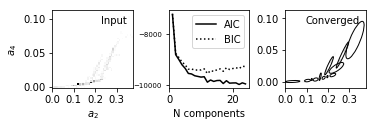

In [3]:
BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4.dat")
nBHdata=np.loadtxt("/home/mw698/BHB/nonBH_a2_a4.dat")
kBHdata=np.loadtxt("/home/mw698/BHB/known_BH_a2_a4.dat")
PHOEBEdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.dat")
#MACHOdata=np.loadtxt("/home/mw698/Downloads/a_par_list")
MACHOdata=Table.read("/net/geha/mw698/MACHO/MACHO_a_par.hc.dat",format='ascii')
ASANdata=Table.read("/net/geha/mw698/ASAN/ASAN_a_par.dat",format='ascii')
LINEARdata=Table.read("/net/geha/mw698/LINEAR/LINEAR_a_par.dat",format='ascii')
STRIPE82data=Table.read("/net/geha/mw698/STRIPE82/STRIPE82_a_par.dat",format='ascii')
Sextansdata=Table.read("/net/geha/mw698/QUEST/sextans_binary/Sextans_a_par.dat",format='ascii')
Selamdata=Table.read("/net/geha/mw698/Selam_a_par.dat",delimiter='\t',format='ascii')
X=np.array([[line[1],line[3]] for line in BHdata])
Y=np.array([[line[1],line[3]] for line in nBHdata])
#MACHO=np.array([[line[1],line[3]] for line in MACHOdata])
ASAN=[[line[0],float(line[2]),float(line[4])] for line in ASANdata]
LINEAR=[[str(line[0]),float(line[2]),float(line[4])] for line in LINEARdata]
STRIPE82=[[str(line[0]),float(line[2]),float(line[4])] for line in STRIPE82data]
MACHO=[[str(line[0]),float(line[2]),float(line[4])] for line in MACHOdata]
Sextans=[[str(line[0]),float(line[2]),float(line[4])] for line in Sextansdata]
Selam=[[str(line[0]),abs(float(line[2])),float(line[3])] for line in Selamdata]


N=np.arange(1,25)

models = compute_GMM(N,MP=False,data=X)
nmodels= compute_GMM(N,MP=False,data=Y)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

nAIC = [m.aic(Y) for m in nmodels]
nBIC = [m.bic(Y) for m in nmodels]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print "best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]

ni_best = np.argmin(nBIC)
ngmm_best = nmodels[ni_best]

x_bins = 51
y_bins = 51
H, x_bins, y_bins = np.histogram2d(X[:,0], X[:,1],
                                          (x_bins, y_bins))

Xgrid = np.array(map(np.ravel,
                     np.meshgrid(0.5 * (x_bins[:-1]
                                        + x_bins[1:]),
                                 0.5 * (y_bins[:-1]
                                        + y_bins[1:])))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 1.66))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[x_bins[0], x_bins[-1],
                  y_bins[0], y_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$a_2$')
ax.set_ylabel(r'$a_4$')
#ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(x_bins[0],x_bins[-1])
ax.set_ylim(y_bins[0], y_bins[-1])
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[x_bins[0], x_bins[-1],
                  y_bins[0], y_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

#ax.set_xlim(x_bins[0],x_bins[-1])
#ax.set_ylim(y_bins[0], y_bins[-1])
#ax.xaxis.set_major_locator(plt.MultipleLocator(3))
#ax.set_xlabel(r'$\rm [Fe/H]$')
#ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

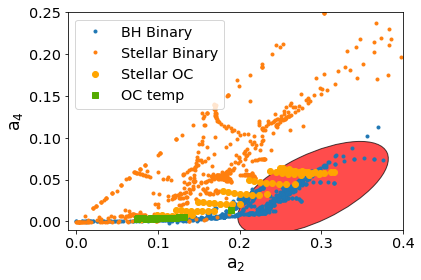

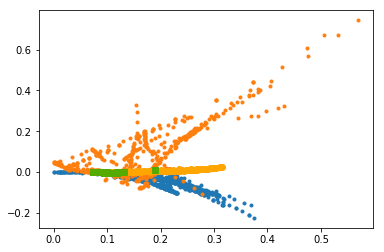

In [5]:
'''
m,l=gmm_best.sample(5000)
nm,nl=ngmm_best.sample(5000)
plt.plot(m[:,0],m[:,1],'.',label='mBH')
plt.plot(nm[:,0],nm[:,1],'.',label='mnBH')
'''
plt.plot(BHdata[:,1],BHdata[:,3],'.',label="BH Binary")
plt.plot(nBHdata[:,1],nBHdata[:,3],'.',label="Stellar Binary")
plt.plot(PHOEBEdata[:,1],PHOEBEdata[:,3],'o',color='#FFA500',label='Stellar OC')
plt.plot(PHOEBEdata[-26:-1,1],PHOEBEdata[-26:-1,3],'s',color='#55AA00',label='OC temp')
#plt.plot(kBHdata[:,1],kBHdata[:,3],'r^',markersize=10,label="real BHB")

#plt.plot([0.2635,0.2628,0.2312,0.2728],[0.0485,0.0516,0.0772,0.0608],'-o')
# plt.plot([0.2635],[0.0485],'^k',label='raw')
# plt.errorbar([0.26281],[0.05158],xerr=[0.00253],yerr=[0.00256],fmt='.k',label='reported')
# plt.plot([0.2312],[0.0772],'>k',label='ELC-P')
# plt.plot([0.2372],[0.1114],'vk',label='ELC-E')
# plt.plot([0.2728],[0.0608],'<k',label='PHOEBE')

plt.legend(fontsize='x-large')
plt.xlim(-0.01,0.4)
plt.ylim(-0.01,0.25)
plt.xlabel(r"$\rm a_2$",fontsize='xx-large')
plt.ylabel(r"$\rm a_4$",fontsize='xx-large')
plt.tick_params(labelsize='x-large')
ax=plt.gca()
ax.add_patch(Ellipse(xy=(0.29,0.04), width=0.2, height=0.08, angle=25, fc='r',alpha=0.7,ec='k'))
#plt.savefig("/home/mw698/BHB/sim_a2_a4_ELC_prob.pdf",format='pdf')#,dpi=1000)
plt.show()
plt.plot(BHdata[:,1],BHdata[:,0],'.',label="BH Binary")
plt.plot(nBHdata[:,1],nBHdata[:,0],'.',label="Stellar Binary")
plt.plot(PHOEBEdata[:,1],PHOEBEdata[:,0],'o',color='#FFA500',label='Stellar OC')
plt.plot(PHOEBEdata[-26:-1,1],PHOEBEdata[-26:-1,0],'s',color='#55AA00',label='OC temp')

679


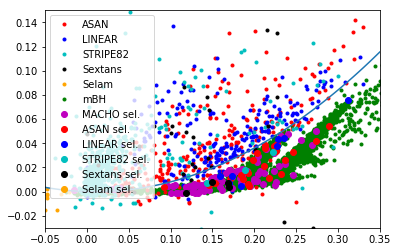

ASAN 25,, LINEAR 8, STRIPE82 27, MACHO 86, Sextans 4, Total 150
ASAN keys
['173908+0339.8', '000058+0236.7', '165113+1048.6', '032029+0833.1', '051617+1856.5', '150509+1817.4', '202303+1019.2', '221313+0538.1', '055041+2513.7', '105855+1722.2', '152555+1715.4', '091707+0107.0', '073534-0154.4', '010932+2239.3', '022211-0310.3', '163522+0316.5', '073648+2538.3', '154033+0218.0', '123730+2604.9', '192019+0157.5', '231929+1801.6', '000653+1646.4', '070137+2814.9', '130226+0718.6', '180806+1526.9']
LINEAR keys
['20997988', '13504794', '19121312', '2695836', '19927647', '4636407', '23478512', '24268361']
STRIPE82 keys
['2759181', '3391506', '2235531', '2285970', '4150412', '2523097', '3104119', '1458997', '1328956', '3207597', '2691734', '934648', '963282', '3088571', '3488609', '2710450', '635896', '853753', '2375930', '1733850', '3903018', '4979304', '2041372', '1764742', '3627080', '2797544', '2910632']
MACHO keys
['101.20908.1106', '101.21434.1700', '107.24803.76', '109.19860.2974', '10

In [11]:
tol=2.5
m,l=gmm_best.sample(5000)
selected2=foo2(MACHO,gmm_best,tol=tol)
ASANkeys, ASANselected2=foo2(ASAN,gmm_best,tol=tol,nmodel=ngmm_best)
LINEARkeys, LINEARselected2=foo2(LINEAR,gmm_best,tol=tol, nmodel=ngmm_best)
STRIPE82keys, STRIPE82selected2=foo2(STRIPE82,gmm_best,tol=tol, nmodel=ngmm_best)
MACHOkeys, MACHOselected2=foo2(MACHO,gmm_best,tol=tol,nmodel=ngmm_best)
Sextanskeys, Sextansselected2=foo2(Sextans,gmm_best,tol=tol,nmodel=ngmm_best)
Selamkeys, Selamselected2=foo2(Selam,gmm_best,tol=tol,nmodel=ngmm_best)
#plt.plot(nBHdata[:,1],nBHdata[:,3],'.',label='nBH')
#plt.plot(MACHOdata[:,1],MACHOdata[:,3],'.',label='MACHO')
#plt.plot(MACHOdata['col3'],MACHOdata['col5'],'m.',label='MACHO')
plt.plot(ASANdata['col3'],ASANdata['col5'],'r.',label='ASAN')
plt.plot(LINEARdata['col3'],LINEARdata['col5'],'b.',label='LINEAR')
plt.plot(STRIPE82data['col3'],STRIPE82data['col5'],'c.',label='STRIPE82')
plt.plot(Sextansdata['col3'],Sextansdata['col5'],'k.',label='Sextans')
plt.plot(Selamdata['a2'],Selamdata['a4'],'.',color='#FFA500',label='Selam')
plt.plot(m[:,0],m[:,1],'g.',label='mBH',zorder=1)
#plt.plot(selected2[:,0],selected2[:,1],'.',label='MACHO sel.')
plt.plot(MACHOselected2[:,0],MACHOselected2[:,1],'mo',label='MACHO sel.')
plt.plot(ASANselected2[:,0],ASANselected2[:,1],'ro',label='ASAN sel.')
plt.plot(LINEARselected2[:,0],LINEARselected2[:,1],'bo',label='LINEAR sel.')
plt.plot(STRIPE82selected2[:,0],STRIPE82selected2[:,1],'co',label='STRIPE82 sel.')
plt.plot(Sextansselected2[:,0],Sextansselected2[:,1],'ko',label='Sextans sel.')
plt.plot(Selamselected2[:,0],Selamselected2[:,1],'o',color='#FFA500',label='Selam sel.')
plt.plot(np.linspace(-0.05,0.35,100),[x*(x-0.02) for x in np.linspace(-0.05,0.35,100)])
n=0
for sur in [MACHO,ASAN,LINEAR,STRIPE82,Sextans,Selam]:
    for lc in sur:
        if lc[2]<=lc[1]*(lc[1]-0.02) and lc[1]>=0.1:
            n+=1
print(n)
plt.legend()
plt.xlim(-0.05,0.35)
plt.ylim(-0.03,0.15)
plt.show()

lAk=len(ASANkeys)
lLk=len(LINEARkeys)
lSk=len(STRIPE82keys)
lMk=len(MACHOkeys)
lSek=len(Sextanskeys)
print("ASAN %g,, LINEAR %g, STRIPE82 %g, MACHO %g, Sextans %g, Total %g"%(lAk,lLk,lSk,lMk,lSek,lAk+lLk+lSk+lMk+lSek))
print("ASAN keys")
print(ASANkeys)
print("LINEAR keys")
print(LINEARkeys)
print("STRIPE82 keys")
print(STRIPE82keys)
print("MACHO keys")
print(MACHOkeys)
print("Sextans keys")
print(Sextanskeys)
print("Selam keys")
print(Selamkeys)

In [40]:
for i in range(len(ASANselected2)):
    if ASANselected2[i][0]>0.25:
        print (ASANselected2[i])
print('end')
kl=[]
for i in range(len(MACHOselected2)):
    if 0.23<MACHOselected2[i][0]:#<0.25 and 0.0<MACHOselected2[i][1]<0.02:
        print(MACHOkeys[i],MACHOselected2[i])
        kl.append(MACHOkeys[i])
print(kl)

[ 0.289125  0.054109]
[ 0.273588  0.041793]
end
('101.21300.4234', array([ 0.240495,  0.028757]))
('103.24419.3171', array([ 0.316758,  0.063071]))
('119.19835.6292', array([ 0.366515,  0.072477]))
('131.30124.2713', array([ 0.26545 ,  0.044967]))
('142.28943.3494', array([ 0.247196,  0.032101]))
('142.28168.2791', array([ 0.307154,  0.044291]))
('153.27482.2612', array([ 0.240172,  0.009213]))
('155.25787.3601', array([ 0.262393,  0.03597 ]))
('157.26293.2217', array([ 0.260603,  0.042012]))
('157.26167.210', array([ 0.269997,  0.048919]))
('161.23919.675', array([ 0.248768,  0.034768]))
('163.27034.2399', array([ 0.275115,  0.047808]))
('171.30019.2991', array([ 0.321977,  0.059001]))
('172.31186.1082', array([ 0.30497 ,  0.047652]))
('178.22877.49', array([ 0.254109,  0.03337 ]))
('178.24049.2716', array([ 0.334531,  0.073641]))
('179.22747.2586', array([ 0.260498,  0.038724]))
('180.22889.2102', array([ 0.245882,  0.019957]))
('18.3330.2670', array([ 0.267831,  0.041378]))
('2.4909

best fit converged: True
BIC: n_components =  14


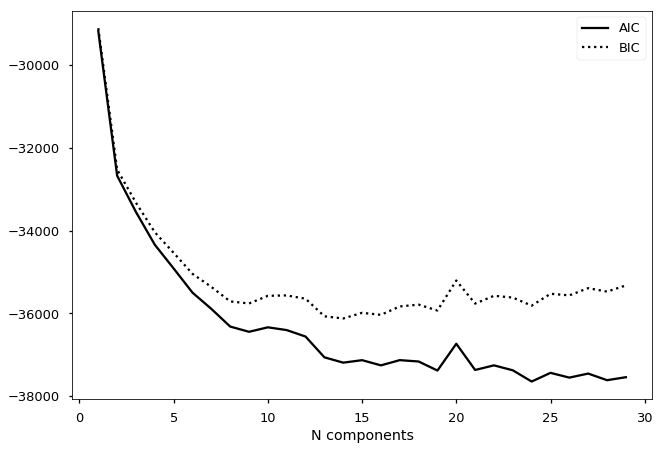

In [6]:
BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4_no_name.m1.dat")
nOCdata=np.loadtxt("/home/mw698/BHB/nBH_a2_a4_no_name.m1.dat")
OCdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.m1.dat")
nBHdata=np.concatenate((nOCdata,OCdata))
kBHdata=np.loadtxt("/home/mw698/BHB/known_BH_a2_a4.dat")
#MACHOdata=np.loadtxt("/home/mw698/Downloads/a_par_list")
MACHOdata=Table.read("/net/geha/mw698/MACHO/more_MACHO_a_par.hc.dat",format='ascii')
ASANdata=Table.read("/net/geha/mw698/ASAN/ASAN_a_par.dat",format='ascii')
LINEARdata=Table.read("/net/geha/mw698/LINEAR/LINEAR_a_par.dat",format='ascii')
STRIPE82data=Table.read("/net/geha/mw698/STRIPE82/STRIPE82_a_par.dat",format='ascii')
X=np.array([[line[0],line[1],line[2],line[3]] for line in BHdata])
Y=np.array([[line[0],line[1],line[2],line[3]] for line in nBHdata])
# Y2=np.array([[abs(line[0]),line[1],abs(line[2]),line[3]] for line in OCdata])
# Y=np.concatenate((Y1,Y2))
#MACHO=np.array([[abs(line[0]),line[1],abs(line[2]),line[3]] for line in MACHOdata])
ASAN=[[line[0],line[1],line[2],line[3],line[4]] for line in ASANdata]
LINEAR=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in LINEARdata]
STRIPE82=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in STRIPE82data]
MACHO=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in MACHOdata]

ASAN=[[line[0],line[1],line[2],line[3],line[4]] for line in ASANdata]
LINEAR=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in LINEARdata]
STRIPE82=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in STRIPE82data]
MACHO=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in MACHOdata]

N=np.arange(1,30)

models = compute_GMM(N,MP=False,data=X)
nmodels= compute_GMM(N,MP=False,data=Y)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

nBIC= [m.bic(Y) for m in nmodels]

i_best = np.argmin(BIC)
gmm_best = models[i_best]

ni_best= np.argmin(nBIC)
ngmm_best= models[ni_best]
#gmm_best = models[-1]
print "best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]

plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, ':k', label='BIC')
plt.legend(loc=1)
plt.xlabel('N components')

plt.show()

best fit converged: True
BIC: n_components =  17


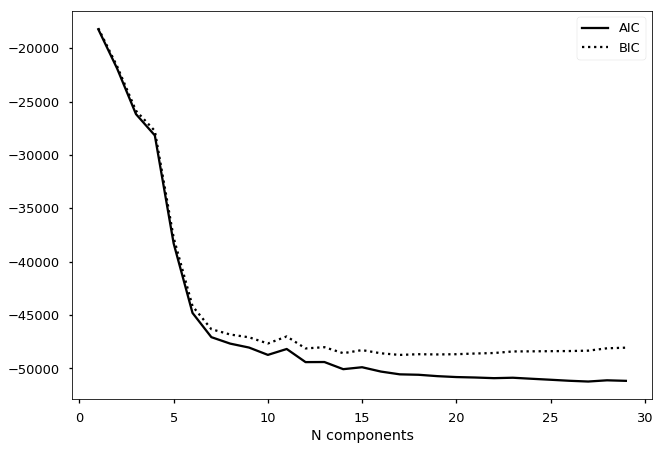

(array([ 341.,  117.,    0.,    0.,    0.,    0.,    0.,  168.,    0.,  261.]),
 array([  2.4      ,  11.4082867,  20.4165734,  29.4248601,  38.4331468,
         47.4414335,  56.4497202,  65.4580069,  74.4662936,  83.4745803,
         92.482867 ]),
 <a list of 10 Patch objects>)

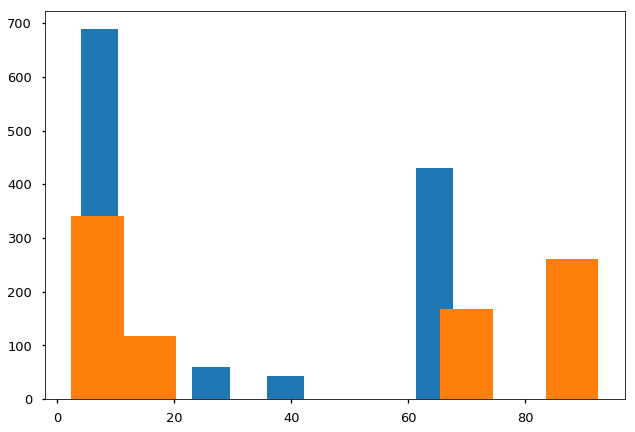

In [20]:
####this verision includes the period
BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4_no_name.m1.dat")
nOCdata=np.loadtxt("/home/mw698/BHB/nBH_a2_a4_no_name.m1.dat")
OCdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.m1.dat")
# nBHdata=np.concatenate((nOCdata,OCdata))
kBHdata=np.loadtxt("/home/mw698/BHB/known_BH_a2_a4.dat")
WDdata=np.loadtxt("/home/mw698/BHB/WD_a2_a4_no_name.m1.dat")
#MACHOdata=np.loadtxt("/home/mw698/Downloads/a_par_list")
MACHOdata=Table.read("/net/geha/mw698/MACHO/more_MACHO_a_par.hc.dat",format='ascii')
ASANdata=Table.read("/net/geha/mw698/ASAN/ASAN_a_par.dat",format='ascii')
LINEARdata=Table.read("/net/geha/mw698/LINEAR/LINEAR_a_par.dat",format='ascii')
STRIPE82data=Table.read("/net/geha/mw698/STRIPE82/STRIPE82_a_par.dat",format='ascii')
X=np.array([[line[0],line[1],line[2],line[3],line[-1]] for line in BHdata])
Y=np.array([[line[0],line[1],line[2],line[3],line[-1]] for line in nBHdata])
# Y2=np.array([[abs(line[0]),line[1],abs(line[2]),line[3]] for line in OCdata])
# Y=np.concatenate((Y1,Y2))
#MACHO=np.array([[abs(line[0]),line[1],abs(line[2]),line[3]] for line in MACHOdata])
ASAN=[[line[0],line[1],line[2],line[3],line[4]] for line in ASANdata]
LINEAR=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in LINEARdata]
STRIPE82=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in STRIPE82data]
MACHO=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in MACHOdata]

ASAN=[[line[0],line[1],line[2],line[3],line[4]] for line in ASANdata]
LINEAR=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in LINEARdata]
STRIPE82=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in STRIPE82data]
MACHO=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in MACHOdata]

N=np.arange(1,30)

models = compute_GMM(N,MP=False,data=X)
nmodels= compute_GMM(N,MP=False,data=Y)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

nBIC= [m.bic(Y) for m in nmodels]

i_best = np.argmin(BIC)
gmm_best = models[i_best]

ni_best= np.argmin(nBIC)
ngmm_best= models[ni_best]
#gmm_best = models[-1]
print "best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]

plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, ':k', label='BIC')
plt.legend(loc=1)
plt.xlabel('N components')

plt.show()

# plt.hist(BHdata[:,-1])
# plt.hist(nBHdata[:,-1])

9


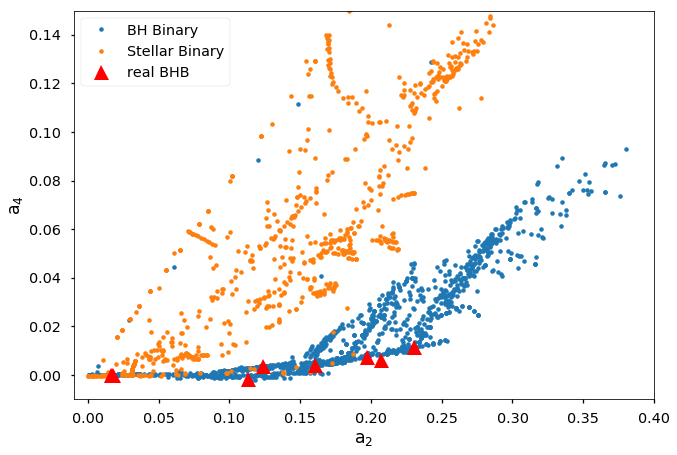

In [30]:
kBHdata=np.loadtxt("/home/mw698/BHB/kBH_a2_a4_no_name.m1.dat")
print(len(kBHdata))

# foo2(np.array([['key',-6.80344991e-02,1.67453565e-01,-2.43116433e-02,3.27282865e-02],
#                ['key',-4.60482e-02,1.63887e-01,-4.03392e-02,3.18011e-02],
#                ['lb',-7.36589839e-02,1.66948993e-01,-2.42215272e-02,1.97786902e-02],
#                ['lb2',6.62814981e-02,1.66768251e-01,2.75800726e-02,1.62402237e-02]]),gmm_best,2.5,nmodel=ngmm_best,iprint=True)
plt.plot(BHdata[:,1],BHdata[:,3],'.',label="BH Binary")
plt.plot(nBHdata[:,1],nBHdata[:,3],'.',label="Stellar Binary")
#plt.plot([1.66948993e-01],[1.97786902e-02],'g^',markersize=10,label='V4641')
plt.plot(kBHdata[:,1],kBHdata[:,3],'r^',markersize=15,label="real BHB")
plt.legend(fontsize='x-large')
plt.xlim(-0.01,0.4)
plt.ylim(-0.01,0.15)
# plt.xlim(0.1,0.225)
# plt.ylim(-0.015,0.01)
plt.xlabel(r"$\rm a_2$",fontsize='xx-large')
plt.ylabel(r"$\rm a_4$",fontsize='xx-large')
plt.tick_params(labelsize='x-large')
ax=plt.gca()
#ax.add_patch(Ellipse(xy=(0.29,0.04), width=0.2, height=0.08, angle=25, fc='r',alpha=0.7,ec='k'))
plt.show()

In [57]:
###Find Stellar curve most similar to BH curve
#BHparams=[-1.90940e-02,1.25738e-01,-9.31876e-04]
for BHparams in kBHdata:
#     print("ASAS")
#     for star in ASAN:
#         if abs(star[1])-abs(BHparams[0])<0.01:
#             if abs(star[2]-BHparams[1])<0.001:
#                 if abs(star[4]-BHparams[3])<0.01:
#                     print(star)

#     print("LINEAR")
#     for star in LINEAR:
#         if abs(star[1])-abs(BHparams[0])<0.01:
#             if abs(star[2]-BHparams[1])<0.001:
#                 if abs(star[4]-BHparams[3])<0.01:
#                     print(star)

    print("MACHO",BHparams)
    for star in MACHO:
        if (abs(star[1])-abs(BHparams[0]))/abs(BHparams[0])<0.001:
            if abs(star[2]-BHparams[1])/BHparams[1]<0.001:
                if abs(star[4]-BHparams[3])/BHparams[3]<0.001:
                    print(star)

('MACHO', array([ -1.23070132e-02,   1.23993324e-01,  -9.53071730e-03,
         3.58705524e-03,   4.08751273e-06,  -8.23636227e-05,
         9.49627986e-06,  -4.76547522e-06,   2.44159781e+00]))
('MACHO', array([ -3.37560723e-02,   2.07316702e-01,  -1.88941533e-02,
         6.04655236e-03,   1.12113769e-05,  -1.37711871e-04,
         1.88259049e-05,  -8.03295053e-06,   6.05255954e+00]))
('MACHO', array([ -1.75601961e-02,   1.13078006e-01,  -1.44013986e-02,
        -1.74413943e-03,   5.83225366e-06,  -7.51130209e-05,
         1.43493787e-05,   2.31711972e-06,  -3.52729133e+00]))
['153.27489.398', -0.0073270000000000002, 0.112968, 0.018429999999999998, 0.047662999999999997]
['46.516.87', -0.011956, 0.11298900000000001, 0.031333, 0.032252999999999997]
('MACHO', array([ -3.55939222e-02,   1.60254419e-01,  -2.51311772e-02,
         4.17118006e-03,   1.18217805e-05,  -1.06450352e-04,
         2.50403997e-05,  -5.54148563e-06,   1.94562832e+01]))
('MACHO', array([ -2.75609371e-02,   1.9706556

In [90]:
plt.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'_classic_test',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn',
 u'presentation',
 u'Joel',
 u'seaborn-dark-palette']

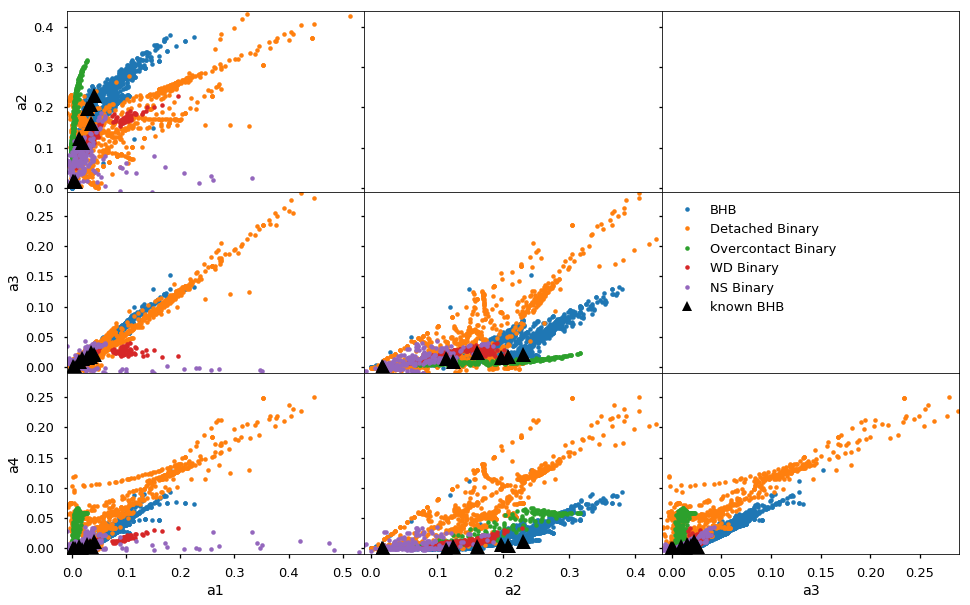

In [4]:
"""
Make Triangle Plot
NO PERIOD
"""

BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4_no_name.m1.dat")
nOCdata=np.loadtxt("/home/mw698/BHB/nBH_a2_a4_no_name.m1.dat")
OCdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.m1.dat")
# nBHdata=np.concatenate((nOCdata,OCdata))
kBHdata=np.loadtxt("/home/mw698/BHB/kBH_a2_a4_no_name.m1.dat")
WDdata=np.loadtxt("/home/mw698/BHB/WD_a2_a4_no_name.m1.dat")
NSdata=np.loadtxt("/home/mw698/BHB/NS_a2_a4_no_name.m1.dat")

plt.style.use('seaborn-talk')

V4641=[6.62814981e-02,1.66768251e-01,2.75800726e-02,1.62402237e-02]

a1=[]
a2=[]
a3=[]
a4=[]
b1=[]
b2=[]
b3=[]
b4=[]
m0=[]
        
    
plab=['a1','a2','a3','a4']#,'b1','b2','b3','b4']
alph=1

#      a1           a2           a3           a4           b1         b2         b3          b4
plim=[(-0.01,0.54),(-0.01,0.44),(-0.01,0.29),(-0.01,0.29),(-0.5,0.3),(-0.5,0.5),(-0.2,0.25),(-0.6,0.3)]

nvar=len(plab)

f,ax=plt.subplots(nvar-1,nvar-1,'col','row',figsize=(16,10))
tol=1

for i in range(nvar):
    for j in range(i+1,nvar):
        cax=ax[j-1][i]
#         x=np.array(plist[i])
#         xp=x[~is_outlier(x)]
#         y=np.array(plist[j])
#         yp=y[~is_outlier(y)]
#         cax.plot(xp,yp,'.')
        cax.plot(BHdata[:,i],BHdata[:,j],'.', label='BHB',alpha=alph)
        cax.plot(nOCdata[:,i],nOCdata[:,j],'.', label='Detached Binary',alpha=alph)
        cax.plot(OCdata[:,i],OCdata[:,j],'.',label="Overcontact Binary",alpha=alph)
        cax.plot(WDdata[:,i],WDdata[:,j],'.', label='WD Binary',alpha=alph)
        cax.plot(NSdata[:,i],NSdata[:,j],'.', label='NS Binary',alpha=alph)
        cax.plot(kBHdata[:,i],kBHdata[:,j],'^',color='black', markersize=15, label='known',alpha=alph)
        #cax.plot(V4641[i],V4641[j],'o',markersize=10)
#         cax.plot(aRRplist[i],aRRplist[j],'o')
#         cax.plot(RRplist[i],RRplist[j],'o')
#         slope, intercept, r_value, p_value, std_err = linregress(RRplist[i],RRplist[j])
#         #print('%s-%s r-squared: %g'%(plab[i],plab[j],r_value**2))
        
#         aslope, aintercept, ar_value, ap_value, astd_err = linregress(aRRplist[i],aRRplist[j])
#         print('%s-%s r-squared (hand, auto): %g %g'%(plab[i],plab[j],r_value**2,ar_value**2))
#         if r_value**2>0.7:
#             xfit=np.linspace(np.min(plist[i]),np.max(plist[i]),100)
#             cax.plot(xfit,[intercept+slope*x for x in xfit])
#             dmax=-99
#             dmin=99
#             for xx,yy in zip(RRplist[i],RRplist[j]):
#                 d=(slope*xx+intercept-yy)/slope
#                 if d>dmax:
#                     dmax=d
#                     xmax=xx
#                     ymax=yy
#                 if d<dmin:
#                     dmin=d
#                     xmin=xx
#                     ymin=yy
#             imax=np.argmax(RRplist[i])
#             imin=np.argmin(RRplist[i])
#             cax.plot([xmin,xmax,RRplist[i][imin],RRplist[i][imax]],[ymin,ymax,RRplist[j][imin],RRplist[j][imax]],'or')
                    
        cax.set_xlim(plim[i])
        cax.set_ylim(plim[j])
#         cax.set_xlim(np.mean(plist[i])-tol*np.std(plist[i]),np.mean(plist[i])+tol*np.std(plist[i]))
#         cax.set_ylim(np.mean(plist[j])-tol*np.std(plist[j]),np.mean(plist[j])+tol*np.std(plist[j]))
        if j==nvar-1:
            cax.set_xlabel(plab[i])
        if i==0:
            cax.set_ylabel(plab[j])

cax=ax[1][2]
cax.plot([-99],[-99],'.', label='BHB')
cax.plot([-99],[-99],'.', label='Detached Binary')
cax.plot([-99],[-99],'.',label="Overcontact Binary")
cax.plot([-99],[-99],'.', label='WD Binary')
cax.plot([-99],[-99],'.', label='NS Binary')
cax.plot([-99],[-99],'k^', label='known BHB')
cax.legend(loc='upper left',frameon=False)
        
f.subplots_adjust(hspace=0,wspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
# plt.savefig("plots/all_a_s6.jpg",dpi=500,bbox_inches='tight')
plt.show()

In [5]:
"""
Make Triangle Plot
WITH PERIOD
"""

BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4_no_name.m1.dat")
nOCdata=np.loadtxt("/home/mw698/BHB/nBH_a2_a4_no_name.m1.dat")
OCdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.m1.dat")
nBHdata=np.concatenate((nOCdata,OCdata))
kBHdata=np.loadtxt("/home/mw698/BHB/known_BH_a2_a4.dat")
WDdata=np.loadtxt("/home/mw698/BHB/WD_a2_a4_no_name.m1.dat")
NSdata=np.loadtxt("/home/mw698/BHB/NS_a2_a4_no_name.m1.dat")

plt.style.use('seaborn-talk')

V4641=[6.62814981e-02,1.66768251e-01,2.75800726e-02,1.62402237e-02]

a1=[]
a2=[]
a3=[]
a4=[]
b1=[]
b2=[]
b3=[]
b4=[]
m0=[]

iro=[0,1,2,3,9]
BHdata=BHdata[:,iro]
nBHdata=nBHdata[:,iro]
WDdata=WDdata[:,iro]
NSdata=NSdata[:,iro]
        
    
plab=['a1','a2','a3','a4','P (hr)']#,'b1','b2','b3','b4']
alph=1.0

#      a1           a2           a3           a4           P       b1         b2         b3          b4
plim=[(-0.01,0.54),(-0.01,0.44),(-0.01,0.34),(-0.01,0.34),(0,105),(-0.5,0.3),(-0.5,0.5),(-0.2,0.25),(-0.6,0.3)]

nvar=len(plab)

f,ax=plt.subplots(nvar-1,nvar-1,'col','row',figsize=(16,10))
tol=1

for i in range(nvar):
    for j in range(i+1,nvar):
        cax=ax[j-1][i]
#         x=np.array(plist[i])
#         xp=x[~is_outlier(x)]
#         y=np.array(plist[j])
#         yp=y[~is_outlier(y)]
#         cax.plot(xp,yp,'.')
        cax.plot(BHdata[:,i],BHdata[:,j],'.', label='BHB',alpha=alph)
        cax.plot(nBHdata[:,i],nBHdata[:,j],'.', label='Stellar Binary',alpha=alph)
        cax.plot(OCdata[:,i],OCdata[:,j],'.',label="Overcontact Binary",alpha=alph)
        cax.plot(WDdata[:,i],WDdata[:,j],'.', label='WD Binary',alpha=alph)
        cax.plot(NSdata[:,i],NSdata[:,j],'.', label='NS Binary',alpha=alph)
        #cax.plot(V4641[i],V4641[j],'o',markersize=10)
#         cax.plot(aRRplist[i],aRRplist[j],'o')
#         cax.plot(RRplist[i],RRplist[j],'o')
#         slope, intercept, r_value, p_value, std_err = linregress(RRplist[i],RRplist[j])
#         #print('%s-%s r-squared: %g'%(plab[i],plab[j],r_value**2))
        
#         aslope, aintercept, ar_value, ap_value, astd_err = linregress(aRRplist[i],aRRplist[j])
#         print('%s-%s r-squared (hand, auto): %g %g'%(plab[i],plab[j],r_value**2,ar_value**2))
#         if r_value**2>0.7:
#             xfit=np.linspace(np.min(plist[i]),np.max(plist[i]),100)
#             cax.plot(xfit,[intercept+slope*x for x in xfit])
#             dmax=-99
#             dmin=99
#             for xx,yy in zip(RRplist[i],RRplist[j]):
#                 d=(slope*xx+intercept-yy)/slope
#                 if d>dmax:
#                     dmax=d
#                     xmax=xx
#                     ymax=yy
#                 if d<dmin:
#                     dmin=d
#                     xmin=xx
#                     ymin=yy
#             imax=np.argmax(RRplist[i])
#             imin=np.argmin(RRplist[i])
#             cax.plot([xmin,xmax,RRplist[i][imin],RRplist[i][imax]],[ymin,ymax,RRplist[j][imin],RRplist[j][imax]],'or')
                    
        cax.set_xlim(plim[i])
        cax.set_ylim(plim[j])
#         cax.set_xlim(np.mean(plist[i])-tol*np.std(plist[i]),np.mean(plist[i])+tol*np.std(plist[i]))
#         cax.set_ylim(np.mean(plist[j])-tol*np.std(plist[j]),np.mean(plist[j])+tol*np.std(plist[j]))
        if j==nvar-1:
            cax.set_xlabel(plab[i])
        if i==0:
            cax.set_ylabel(plab[j])
#         if i==1 and j==2:
#             cax.legend()
            
cax=ax[1][2]
cax.plot([-99],[-99],'.', label='BHB')
cax.plot([-99],[-99],'.', label='Stellar Binary') #UNCOMMENT ME!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cax.plot([-99],[-99],'.',label="Overcontact Binary")
cax.plot([-99],[-99],'.', label='WD Binary')
cax.plot([-99],[-99],'.', label='NS Binary')
cax.legend(loc='upper left',frameon=False)

        
f.subplots_adjust(hspace=0,wspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.savefig("plots/all_a_period.jpg",dpi=500,bbox_inches='tight')
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [1]:
"""
Make Triangle Plot
WITH COLOR
"""

BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4_no_name.m1.dat")
nOCdata=np.loadtxt("/home/mw698/BHB/nBH_a2_a4_no_name.m1.dat")
OCdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.m1.dat")
# nBHdata=np.concatenate((nOCdata,OCdata))
kBHdata=np.loadtxt("/home/mw698/BHB/known_BH_a2_a4.dat")
WDdata=np.loadtxt("/home/mw698/BHB/WD_a2_a4_no_name.m1.dat")
NSdata=np.loadtxt("/home/mw698/BHB/NS_a2_a4_no_name.m1.dat")

plt.style.use('seaborn-talk')

V4641=[6.62814981e-02,1.66768251e-01,2.75800726e-02,1.62402237e-02]

a1=[]
a2=[]
a3=[]
a4=[]
b1=[]
b2=[]
b3=[]
b4=[]
m0=[]

iro=[0,1,2,3,10]
BHdata=BHdata[:,iro]
nBHdata=nOCdata[:,iro]
WDdata=WDdata[:,iro]
NSdata=NSdata[:,iro]
        
    
plab=['a1','a2','a3','a4','B-V']#,'b1','b2','b3','b4']
alph=1.0

#      a1           a2           a3           a4           B-V       b1         b2         b3          b4
plim=[(-0.01,0.54),(-0.01,0.44),(-0.01,0.34),(-0.01,0.34),(-0.9,0.9),(-0.5,0.3),(-0.5,0.5),(-0.2,0.25),(-0.6,0.3)]

nvar=len(plab)

f,ax=plt.subplots(nvar-1,nvar-1,'col','row',figsize=(16,10))
tol=1

for i in range(nvar):
    for j in range(i+1,nvar):
        cax=ax[j-1][i]
#         x=np.array(plist[i])
#         xp=x[~is_outlier(x)]
#         y=np.array(plist[j])
#         yp=y[~is_outlier(y)]
#         cax.plot(xp,yp,'.')
        cax.plot(BHdata[:,i],BHdata[:,j],'.', label='BHB',alpha=alph)
        cax.plot(nBHdata[:,i],nBHdata[:,j],'.', label='Stellar Binary',alpha=alph)
        cax.plot(OCdata[:,i],OCdata[:,j],'.',label="Overcontact Binary",alpha=alph)
        cax.plot(WDdata[:,i],WDdata[:,j],'.', label='WD Binary',alpha=alph)
        cax.plot(NSdata[:,i],NSdata[:,j],'.', label='NS Binary',alpha=alph)
        #cax.plot(V4641[i],V4641[j],'o',markersize=10)
#         cax.plot(aRRplist[i],aRRplist[j],'o')
#         cax.plot(RRplist[i],RRplist[j],'o')
#         slope, intercept, r_value, p_value, std_err = linregress(RRplist[i],RRplist[j])
#         #print('%s-%s r-squared: %g'%(plab[i],plab[j],r_value**2))
        
#         aslope, aintercept, ar_value, ap_value, astd_err = linregress(aRRplist[i],aRRplist[j])
#         print('%s-%s r-squared (hand, auto): %g %g'%(plab[i],plab[j],r_value**2,ar_value**2))
#         if r_value**2>0.7:
#             xfit=np.linspace(np.min(plist[i]),np.max(plist[i]),100)
#             cax.plot(xfit,[intercept+slope*x for x in xfit])
#             dmax=-99
#             dmin=99
#             for xx,yy in zip(RRplist[i],RRplist[j]):
#                 d=(slope*xx+intercept-yy)/slope
#                 if d>dmax:
#                     dmax=d
#                     xmax=xx
#                     ymax=yy
#                 if d<dmin:
#                     dmin=d
#                     xmin=xx
#                     ymin=yy
#             imax=np.argmax(RRplist[i])
#             imin=np.argmin(RRplist[i])
#             cax.plot([xmin,xmax,RRplist[i][imin],RRplist[i][imax]],[ymin,ymax,RRplist[j][imin],RRplist[j][imax]],'or')
                    
        cax.set_xlim(plim[i])
        cax.set_ylim(plim[j])
#         cax.set_xlim(np.mean(plist[i])-tol*np.std(plist[i]),np.mean(plist[i])+tol*np.std(plist[i]))
#         cax.set_ylim(np.mean(plist[j])-tol*np.std(plist[j]),np.mean(plist[j])+tol*np.std(plist[j]))
        if j==nvar-1:
            cax.set_xlabel(plab[i])
        if i==0:
            cax.set_ylabel(plab[j])
#         if i==1 and j==2:
#             cax.legend()
            
cax=ax[1][2]
cax.plot([-99],[-99],'.', label='BHB')
cax.plot([-99],[-99],'.', label='Stellar Binary') #UNCOMMENT ME!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cax.plot([-99],[-99],'.',label="Overcontact Binary")
cax.plot([-99],[-99],'.', label='WD Binary')
cax.plot([-99],[-99],'.', label='NS Binary')
cax.legend(loc='upper left',frameon=False)

        
f.subplots_adjust(hspace=0,wspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
#plt.savefig("plots/all_a_period.jpg",dpi=500,bbox_inches='tight')
plt.show()

NameError: name 'np' is not defined

(-0.02, 0.3)

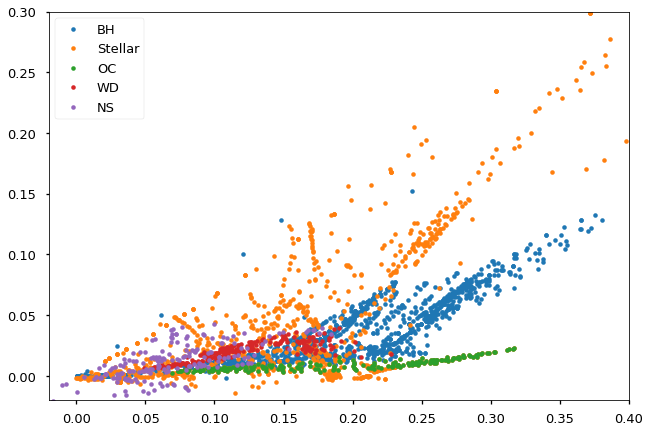

In [264]:
# plt.plot(BHdata[:,1],BHdata[:,2],'.', label='BHB')
# plt.plot(nBHdata[:,1],nBHdata[:,2],'.', label='Stellar Binary')
# plt.plot(OCdata[:,1],OCdata[:,2],'.',label="Overcontact Binary")
# plt.plot(WDdata[:,1],WDdata[:,2],'.', label='WD Binary')
# plt.plot(NSdata[:,1],NSdata[:,2],'.', label='NS Binary')

typ='plot'
dlist=[BHdata,nBHdata,OCdata,WDdata,NSdata]
clist=['Blue','Orange','Green','Red','Purple']
llist=['BH','Stellar','OC','WD','NS']
for d,c,l in zip(dlist,clist,llist):
    if typ=='plot':
        plt.plot(d[:,1],d[:,2],'.',label=l,alpha=1.0)
    elif typ=='scatter':
        plt.scatter(d[:,1],d[:,2],15,marker='.',label=l)
    elif typ=='contour':
#         H,xv,yv=np.histogram2d(l[:,1],l[:,2],15,[[0,0.4],[0,0.4]])
#         plt.contourf(xv,yv,H)
        counts,ybins,xbins =np.histogram2d(d[:,2],d[:,1],100,[[-0.02,0.4],[-0.02,0.4]])
#         plt.scatter(d[:,1],d[:,2],50,marker='.',label=l)
        plt.contour(counts,40,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=1,colors=c,label=l)

plt.legend()
plt.xlim(-0.02,0.4)
plt.ylim(-0.02,0.3)
# plt.axhline(0.02)
# plt.axhline(0.04)
# plt.axvline(0.04)
# plt.axvline(0.06)
# plt.axhline(10)
# plt.axhline(50)
# plt.axvline(0.1)

## Selecting Candidates based on hard cuts

### trying a1-0.75*a3

(-0.17061256000000002, 0.017366599999999999, -0.017660009048913045, 0.016034136900954808, -0.016654920000000004)


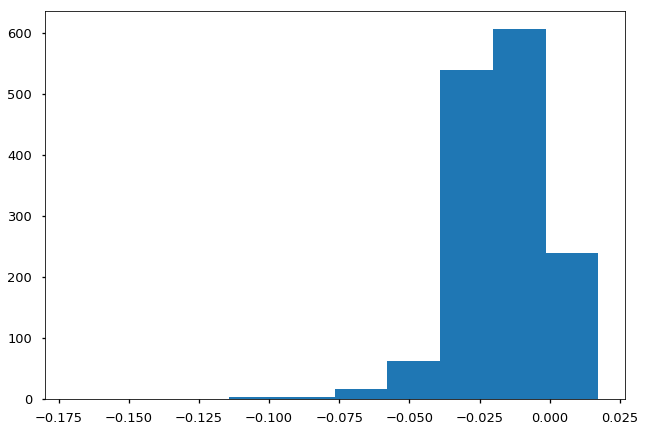

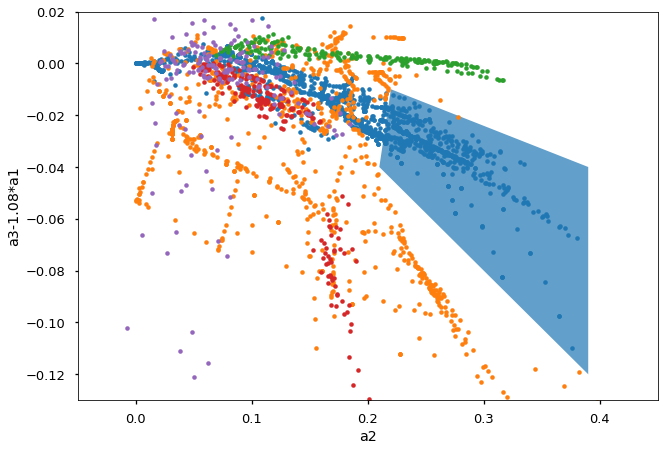

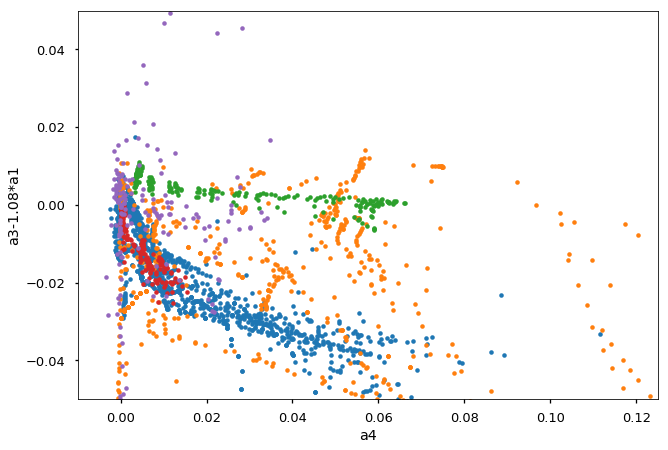

In [211]:
from scipy.spatial import ConvexHull

# plt.plot(BHdata[:,1]-BHdata[:,0],BHdata[:,3]-BHdata[:,2],'.')
# plt.plot(nBHdata[:,1]-nBHdata[:,0],nBHdata[:,3]-nBHdata[:,2],'.')
# plt.plot(OCdata[:,1]-OCdata[:,0],OCdata[:,3]-OCdata[:,2],'.')
# plt.plot(WDdata[:,1]-WDdata[:,0],WDdata[:,3]-WDdata[:,2],'.')
# plt.plot(NSdata[:,1]-NSdata[:,0],NSdata[:,3]-NSdata[:,2],'.')
# plt.xlim(-0.1,0.3)
# plt.xlabel("a2-a1")
# plt.ylabel("a4-a3")
# plt.show()

# plt.plot(BHdata[:,3]/BHdata[:,1],BHdata[:,3]-BHdata[:,2],'.')
# plt.plot(nBHdata[:,3]/nBHdata[:,1],nBHdata[:,3]-nBHdata[:,2],'.')
# plt.plot(OCdata[:,3]/OCdata[:,1],OCdata[:,3]-OCdata[:,2],'.')
# plt.plot(WDdata[:,3]/WDdata[:,1],WDdata[:,3]-WDdata[:,2],'.')
# plt.plot(NSdata[:,3]/NSdata[:,1],NSdata[:,3]-NSdata[:,2],'.')
# plt.xlim(-1,1.5)
# plt.xlabel("a4/a2")
# plt.ylabel("a4-a3")
# plt.show()

m=1.08

dist=BHdata[:,2]-m*BHdata[:,0]
plt.hist(dist)
print(min(dist),max(dist),np.mean(dist),np.std(dist),np.median(dist))
plt.show()

nOCpoints=np.array(zip(nOCdata[:,1],nOCdata[:,2]-m*nOCdata[:,0]))
OCpoints=np.array(zip(OCdata[:,1],OCdata[:,2]-m*OCdata[:,0]))
hull=ConvexHull(nOCpoints)

plt.plot(BHdata[:,1],BHdata[:,2]-m*BHdata[:,0],'.')
plt.plot(nOCdata[:,1],nOCdata[:,2]-m*nOCdata[:,0],'.')
# plt.plot(nOCpoints[hull.vertices,0], nOCpoints[hull.vertices,1], 'r--', lw=2)
plt.plot(OCdata[:,1],OCdata[:,2]-m*OCdata[:,0],'.')
plt.plot(WDdata[:,1],WDdata[:,2]-m*WDdata[:,0],'.')
plt.plot(NSdata[:,1],NSdata[:,2]-m*NSdata[:,0],'.')

plt.fill([0.22,0.21,0.39,0.39],[-0.01,-0.04,-0.12,-0.04],alpha=0.7)
plt.xlim(-0.05,0.45)
plt.ylim(-0.13,0.02)

# these are the m=0.75 values
# plt.fill([0.22,0.22,0.4,0.4,0.32],[0,-0.01,-0.025,0.02,0.005],alpha=0.7)
# plt.xlim(-0.05,0.45)
# # plt.xlim(xmax=2.5)
# plt.ylim(-0.05,0.05)
plt.xlabel("a2")
plt.ylabel("a3-%g*a1"%m)
plt.show()

# print("%g OC interlopers" %(np.sum((OCpoints[:,0]>0.22) & (OCpoints[:,1]<upperline(OCpoints[:,0])))))

plt.plot(BHdata[:,3],BHdata[:,2]-m*BHdata[:,0],'.')
plt.plot(nOCdata[:,3],nOCdata[:,2]-m*nOCdata[:,0],'.')
# plt.plot(nOCpoints[hull.vertices,0], nOCpoints[hull.vertices,1], 'r--', lw=2)
plt.plot(OCdata[:,3],OCdata[:,2]-m*OCdata[:,0],'.')
plt.plot(WDdata[:,3],WDdata[:,2]-m*WDdata[:,0],'.')
plt.plot(NSdata[:,3],NSdata[:,2]-m*NSdata[:,0],'.')
# plt.fill([0.22,0.22,0.4,0.4],[0,-0.01,-0.025,0.02],alpha=0.7)
plt.xlim(-0.01,0.125)
plt.ylim(-0.05,0.05)
plt.xlabel("a4")
plt.ylabel("a3-%g*a1"%m)
plt.show()

66
66


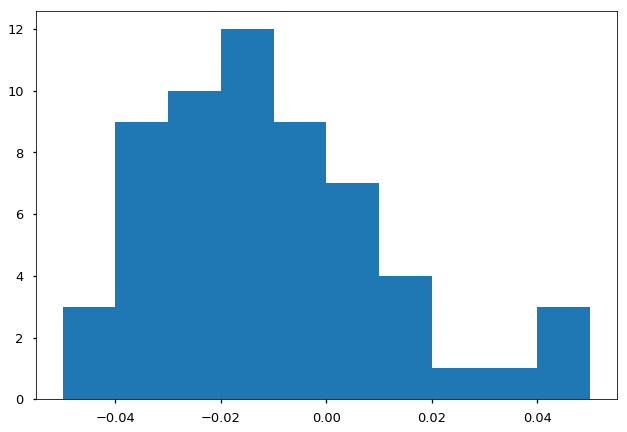

63
61


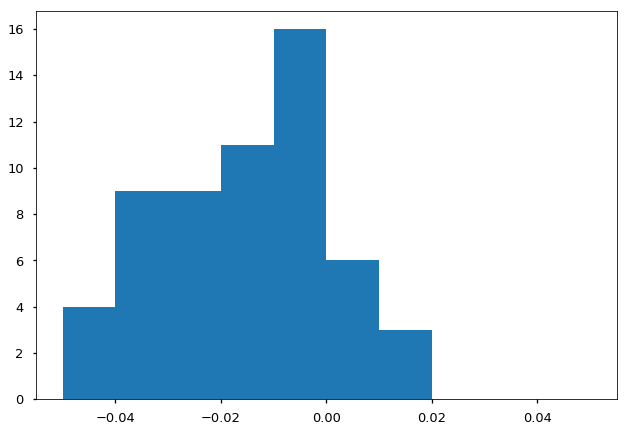

42
14


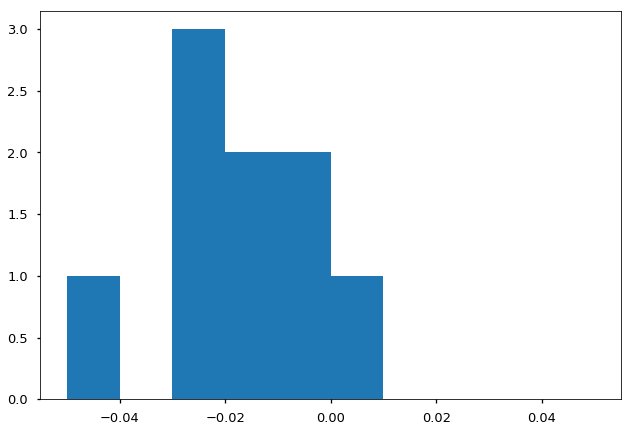

1361
1247


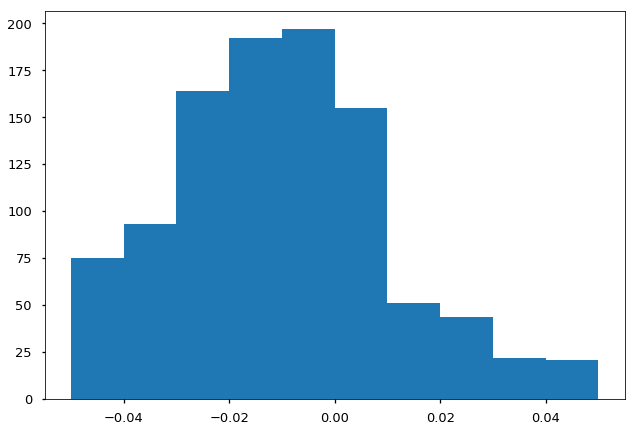

932
350


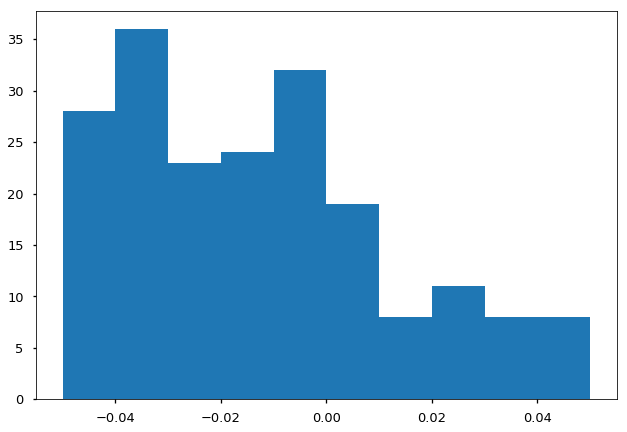

30
30
7
470
120


NameError: name 'OCdata' is not defined

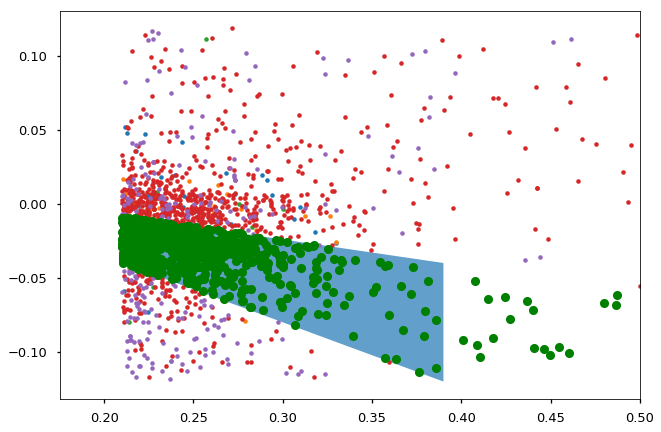

In [7]:
# def make_line(points):
#     def line_func(x):
#         return (points[1,1]-points[0,1])/(points[1,0]-points[0,0])*(x-points[0,0])+points[0,1]
#     return line_func

MACHOdata=Table.read("/net/geha/mw698/MACHO/more_MACHO_a_par.dat",format='ascii')
MACHOdata2=Table.read("/net/geha/mw698/MACHO/more_MACHO_a_par.hc.dat",format='ascii')
ASASdata=Table.read("/net/geha/mw698/ASAN/ASAN_a_par.dat",format='ascii')
LINEARdata=Table.read("/net/geha/mw698/LINEAR/LINEAR_a_par.dat",format='ascii')
STRIPE82data=Table.read("/net/geha/mw698/STRIPE82/STRIPE82_a_par.dat",format='ascii')

fulldatalist=[ASASdata,LINEARdata,STRIPE82data,MACHOdata,MACHOdata2]

ASAS=[[line[0],line[1],line[2],line[3],line[4]] for line in ASASdata]
LINEAR=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in LINEARdata]
STRIPE82=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in STRIPE82data]
MACHO=[[str(line[0]),line[1],line[2],line[3],line[4]] for line in MACHOdata]

# these are the m=1.08 values
upperlinepoints=np.array([[0.22,-0.01],[0.39,-0.04]])
lowerlinepoints=np.array([[0.39,-0.12],[0.21,-0.04]])

## these are the m=0.75 values
# upperlinepoints=np.array([[0.22,0],[0.32,0.005],[0.4,0.02]])
# lowerlinepoints=np.array([[0.4,-0.025],[0.22,-0.01]])
upperline=interpolate.interp1d(upperlinepoints[:,0],upperlinepoints[:,1],fill_value='extrapolate')
lowerline=interpolate.interp1d(lowerlinepoints[:,0],lowerlinepoints[:,1],fill_value='extrapolate')

m=1.08
subsubsetlist=[]
for dataset in fulldatalist:
    subset=dataset[dataset['col3']>0.21] #this is 0.22 for m=0.75
    print(len(subset))
    plt.hist(subset['col4']-m*subset['col2'],range=(-0.05,0.05))
    subsubset=subset[abs(subset['col4']-m*subset['col2'])<0.12] #this is 0.05 for m=0.75
    subsubsetlist.append(subsubset)
    print(len(subsubset))
    plt.show()

for l in subsubsetlist:
    plt.plot(l['col3'],l['col4']-m*l['col2'],'.')
plt.fill(np.concatenate((upperlinepoints[:,0],lowerlinepoints[:,0])),np.concatenate((upperlinepoints[:,1],lowerlinepoints[:,1])),alpha=0.7)
plt.xlim(xmax=0.5)

sellist=[]
for l in subsubsetlist:
    yvals=l['col4']-m*l['col2']
    sel=l[(yvals<upperline(l['col3'])) & (yvals>lowerline(l['col3'])) & (l['col3']<0.5)]
    sellist.append(sel)
    print(len(sel))
    plt.plot(sel['col3'],sel['col4']-m*sel['col2'],'go')
plt.plot(OCdata[:,1],OCdata[:,2]-m*OCdata[:,0],'ko')
    
yvals=OCdata[:,2]-m*OCdata[:,0]
len(OCdata[yvals<upperline(OCdata[:,1])])

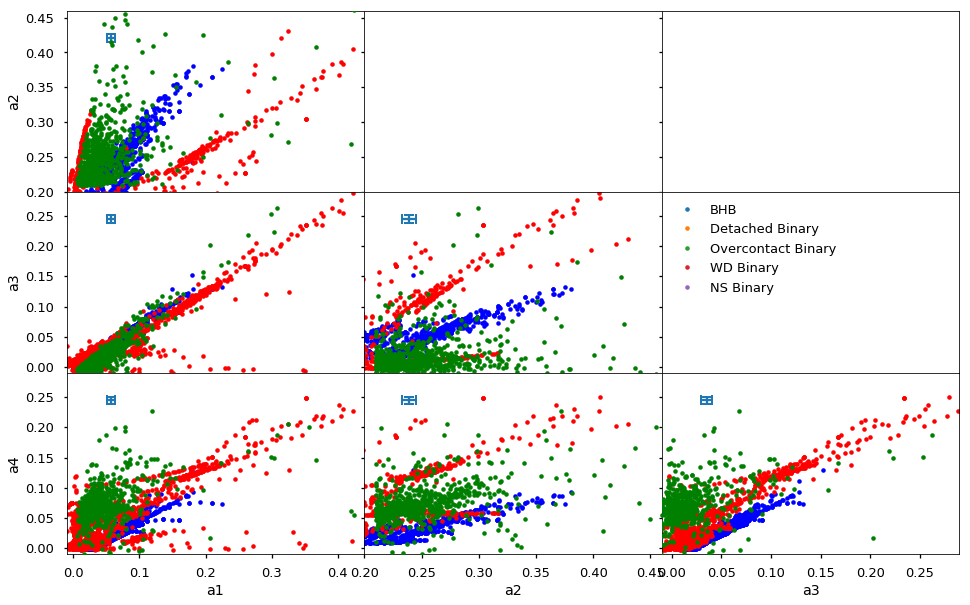

In [510]:
##check locations

plt.style.use('seaborn-talk')

a1=[]
a2=[]
a3=[]
a4=[]
b1=[]
b2=[]
b3=[]
b4=[]
m0=[]
        
    
plab=['a1','a2','a3','a4']#,'b1','b2','b3','b4']
alph=1

#      a1           a2           a3           a4           b1         b2         b3          b4
plim=[(-0.01,0.44),(0.2,0.46),(-0.01,0.29),(-0.01,0.29),(-0.5,0.3),(-0.5,0.5),(-0.2,0.25),(-0.6,0.3)]

nvar=len(plab)

f,ax=plt.subplots(nvar-1,nvar-1,'col','row',figsize=(16,10))
tol=1

for i in range(nvar):
    for j in range(i+1,nvar):
        cax=ax[j-1][i]
        istr='col'+str(i+2)
        jstr='col'+str(j+2)
        cax.plot(BHdata[:,i],BHdata[:,j],'b.', label='BHB',alpha=alph)
        cax.plot(nOCdata[:,i],nOCdata[:,j],'r.', label='Detached Binary',alpha=alph)
        cax.plot(OCdata[:,i],OCdata[:,j],'r.',label="Overcontact Binary",alpha=alph)
        cax.plot(WDdata[:,i],WDdata[:,j],'r.', label='WD Binary',alpha=alph)
        cax.plot(NSdata[:,i],NSdata[:,j],'r.', label='NS Binary',alpha=alph)
#         cax.plot(kBHdata[:,i],kBHdata[:,j],'^',color='black', markersize=15, label='known',alpha=alph)
        cax.errorbar([plim[i][0]+0.15*(plim[i][1]-plim[i][0])],[plim[j][1]-0.15*(plim[j][1]-plim[j][0])],[0.006],[0.006],capsize=5,capthick=2)
        for k in range(len(sellist)):
            pass
#             cax.scatter(sellist[k][istr],sellist[k][jstr],c=sellist[k]['col5'],vmin=0,vmax=0.35,cmap='Purples_r',zorder=5)
            cax.plot(sellist[k][istr],sellist[k][jstr],'g.',zorder=5)
#             cax.plot(fulldatalist[k][istr],fulldatalist[k][jstr],'k.')
#             cax.plot(subsubsetlist[k][istr],subsubsetlist[k][jstr],'ko')
                    
        cax.set_xlim(plim[i])
        cax.set_ylim(plim[j])

        if j==nvar-1:
            cax.set_xlabel(plab[i])
        if i==0:
            cax.set_ylabel(plab[j])

cax=ax[1][2]
cax.plot([-99],[-99],'.', label='BHB')
cax.plot([-99],[-99],'.', label='Detached Binary')
cax.plot([-99],[-99],'.',label="Overcontact Binary")
cax.plot([-99],[-99],'.', label='WD Binary')
cax.plot([-99],[-99],'.', label='NS Binary')
# cax.plot([-99],[-99],'k^', label='known BHB')
cax.legend(loc='upper left',frameon=False)
        
f.subplots_adjust(hspace=0,wspace=0)

plt.show()

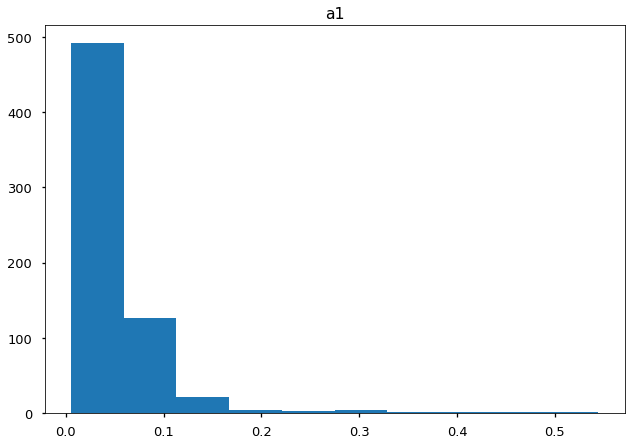

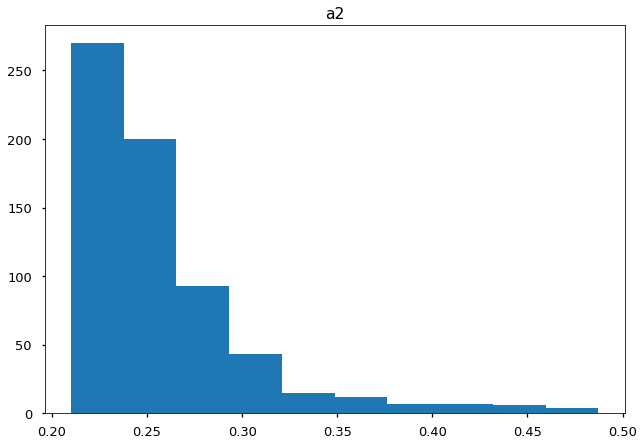

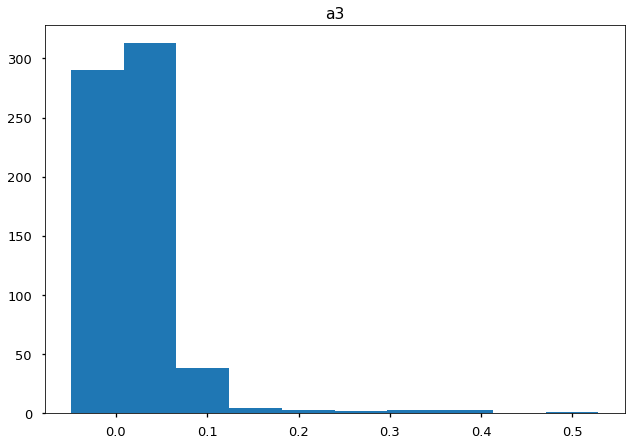

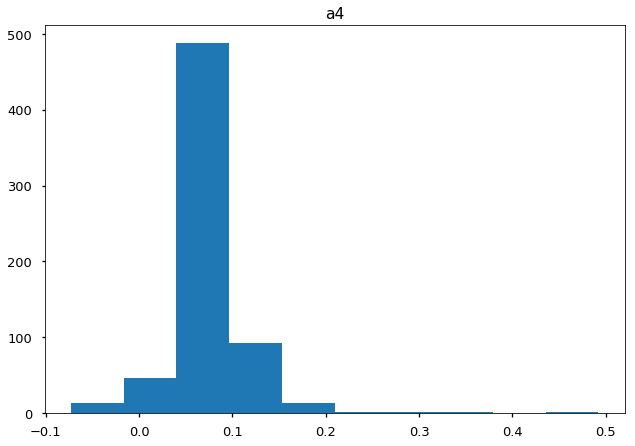

(array([   4.,    7.,    5.,    9.,   21.,   37.,   84.,  151.,  203.,  136.]),
 array([-0.11389816, -0.10344023, -0.0929823 , -0.08252438, -0.07206645,
        -0.06160852, -0.05115059, -0.04069266, -0.03023474, -0.01977681,
        -0.00931888]),
 <a list of 10 Patch objects>)

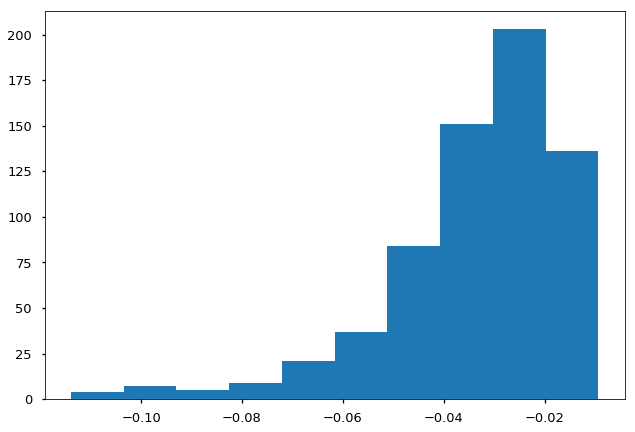

In [225]:
a1=[]
a2=[]
a3=[]
a4=[]
for l in sellist:
    a1=np.concatenate((a1,l['col2']))
    a2=np.concatenate((a2,l['col3']))
    a3=np.concatenate((a3,l['col4']))
    a4=np.concatenate((a4,l['col5']))

plt.hist(a1)
plt.title('a1')
plt.show()
plt.hist(a2)
plt.title('a2')
plt.show()
plt.hist(a3)
plt.title('a3')
plt.show()
plt.hist(a4)
plt.title('a4')
plt.show()
plt.hist(a3-m*a1)

     col1       col2     col3     col4     col5     col6     col7     col8      col9  
------------- -------- -------- -------- -------- -------- -------- -------- ---------
132.31817.183 0.128191 0.323824 0.138563 -0.00538 0.057272 0.199331 -0.07453 -0.057238
0.043060705
(-0.10000000000000001, 2.1000000000000001)


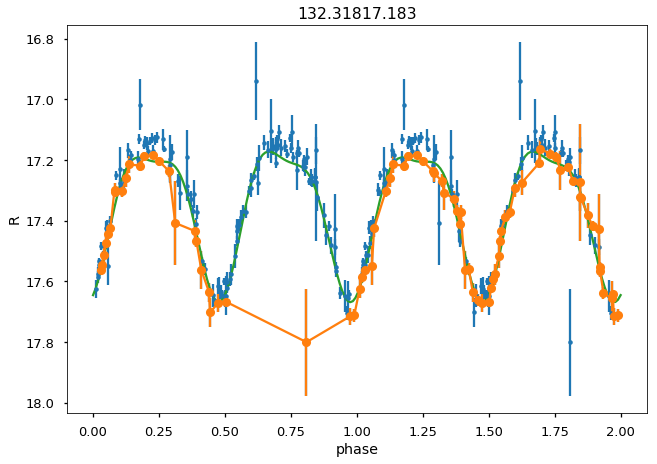

In [144]:
for l in subsubsetlist:
    for line in l:
        if (abs(line['col2']-0.13)<0.01) and (line['col3']>0.3):
            print(line)
            print(line['col4']-0.745*line['col2'])
            MACHOplot(line['col1'],True)

### trying straight cuts

In [50]:
a=np.empty((0,2))
b=np.array([[1,2] ,[3,4]])
c=np.array([[1,2] ,[3,4]])
np.concatenate((a,b,c))

array([[ 1.,  2.],
       [ 3.,  4.],
       [ 1.,  2.],
       [ 3.,  4.]])

In [77]:
###START HERE

BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4_no_name.m1.dat")
nOCdata=np.loadtxt("/home/mw698/BHB/nBH_a2_a4_no_name.m1.dat")
OCdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.m1.dat")
# nBHdata=np.concatenate((nOCdata,OCdata))
kBHdata=np.loadtxt("/home/mw698/BHB/kBH_a2_a4_no_name.m1.dat")
WDdata=np.loadtxt("/home/mw698/BHB/WD_a2_a4_no_name.m1.dat")
NSdata=np.loadtxt("/home/mw698/BHB/NS_a2_a4_no_name.m1.dat")

simlists=[BHdata,nOCdata,OCdata,WDdata,NSdata]

err=0.006
nsamples=100

explist=[]
for sim in simlists:
    exp=np.empty((0,4))
    for line in sim:
        temp=np.random.normal(line[:4],err,(nsamples,4))
        exp=np.concatenate((exp,temp))
    explist.append(exp)

MACHOdata=Table.read("/net/geha/mw698/MACHO/more_MACHO_a_par.dat",format='ascii')
MACHOdata2=Table.read("/net/geha/mw698/MACHO/more_MACHO_a_par.hc.dat",format='ascii')
ASASdata=Table.read("/net/geha/mw698/ASAN/ASAN_a_par.dat",format='ascii')
LINEARdata=Table.read("/net/geha/mw698/LINEAR/LINEAR_a_par.dat",format='ascii')
STRIPE82data=Table.read("/net/geha/mw698/STRIPE82/STRIPE82_a_par.dat",format='ascii')

fulldatalist=[ASASdata,LINEARdata,STRIPE82data]#,MACHOdata,MACHOdata2] #####NOTE: MACHO has been removed since it is not visible from Palomar

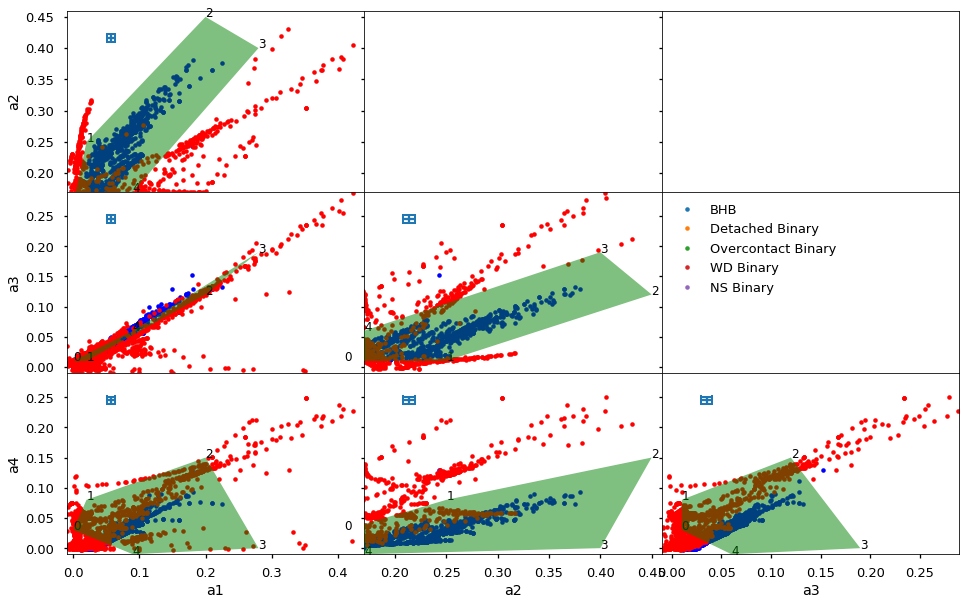

In [86]:
edges=np.array([[0.0,0.02,0.2,0.28,0.09],[0.15,0.25,0.45,0.4,0.17],[0.01,0.01,0.12,0.19,0.06],[0.03,0.08,0.15,0,-0.01]])

#      a1           a2           a3           a4           b1         b2         b3          b4
plim=[(-0.01,0.44),(0.17,0.46),(-0.01,0.29),(-0.01,0.29),(-0.5,0.3),(-0.5,0.5),(-0.2,0.25),(-0.6,0.3)]
plim2=[(-0.01,0.54),(-0.01,0.44),(-0.01,0.29),(-0.01,0.29),(-0.5,0.3),(-0.5,0.5),(-0.2,0.25),(-0.6,0.3)]

def tri_plot(datalist=[],datalist2=[],ifill=False,tight_lims=True, savename=None, use_exp=False):
    lim=plim if tight_lims else plim2
    
    plt.style.use('seaborn-talk')

    a1=[]
    a2=[]
    a3=[]
    a4=[]
    b1=[]
    b2=[]
    b3=[]
    b4=[]
    m0=[]


    plab=['a1','a2','a3','a4']#,'b1','b2','b3','b4']
    alph=1

    nvar=len(plab)

    f,ax=plt.subplots(nvar-1,nvar-1,'col','row',figsize=(16,10))
    tol=1

    for i in range(nvar):
        for j in range(i+1,nvar):
            cax=ax[j-1][i]
            istr='col'+str(i+2)
            jstr='col'+str(j+2)
            
            if use_exp:
                for ii,l in enumerate(explist):
                    cax.plot(l[:,i],l[:,j],'b.' if ii==0 else 'r.',alpha=0.5, zorder=5 if ii==0 else 2)
            else:
                cax.plot(BHdata[:,i],BHdata[:,j],'b.', label='BHB',alpha=alph)
                cax.plot(nOCdata[:,i],nOCdata[:,j],'r.', label='Detached Binary',alpha=alph)
                cax.plot(OCdata[:,i],OCdata[:,j],'r.',label="Overcontact Binary",alpha=alph)
                cax.plot(WDdata[:,i],WDdata[:,j],'r.', label='WD Binary',alpha=alph)
                cax.plot(NSdata[:,i],NSdata[:,j],'r.', label='NS Binary',alpha=alph)
                
            cax.errorbar([lim[i][0]+0.15*(lim[i][1]-lim[i][0])],[lim[j][1]-0.15*(lim[j][1]-lim[j][0])],[0.006],[0.006],capsize=5,capthick=2)
            for ii in range(len(datalist)):
                cax.plot(datalist[ii][istr],datalist[ii][jstr],'g.',zorder=5)
            for ii in range(len(datalist2)): #only use this for old candidate.dat files
                istr='a'+str(i+1)
                jstr='a'+str(j+1)
                cax.plot(datalist2[ii][istr],datalist2[ii][jstr],'ks',zorder=5)
                
            if ifill:
                cax.fill(edges[i],edges[j],'go',alpha=0.5,zorder=10)
                for k in range(5):
                    cax.text(edges[i][k],edges[j][k],"%g"%(k),fontsize=12)
#             cax.plot(kBHdata[:,i],kBHdata[:,j],'^',color='black', markersize=15, label='known',alpha=alph)

            cax.set_xlim(lim[i])
            cax.set_ylim(lim[j])

            if j==nvar-1:
                cax.set_xlabel(plab[i])
            if i==0:
                cax.set_ylabel(plab[j])

    cax=ax[1][2]
    cax.plot([-99],[-99],'.', label='BHB')
    cax.plot([-99],[-99],'.', label='Detached Binary')
    cax.plot([-99],[-99],'.',label="Overcontact Binary")
    cax.plot([-99],[-99],'.', label='WD Binary')
    cax.plot([-99],[-99],'.', label='NS Binary')
    # cax.plot([-99],[-99],'k^', label='known BHB')
    cax.legend(loc='upper left',frameon=False)


    f.subplots_adjust(hspace=0,wspace=0)
    
    if savename is not None:
        plt.savefig("/home/mw698/BHB/plots/%s.pdf"%savename)

    plt.show()
    
tri_plot(ifill=True)#, savename='a2_a4_hard_cuts')

# print('BH',np.polyfit(BHdata[:,0],BHdata[:,2],2))
# print('OC',np.polyfit(OCdata[:,0],OCdata[:,2],2))
# print('nOC',np.polyfit(nOCdata[:,0],nOCdata[:,2],2))

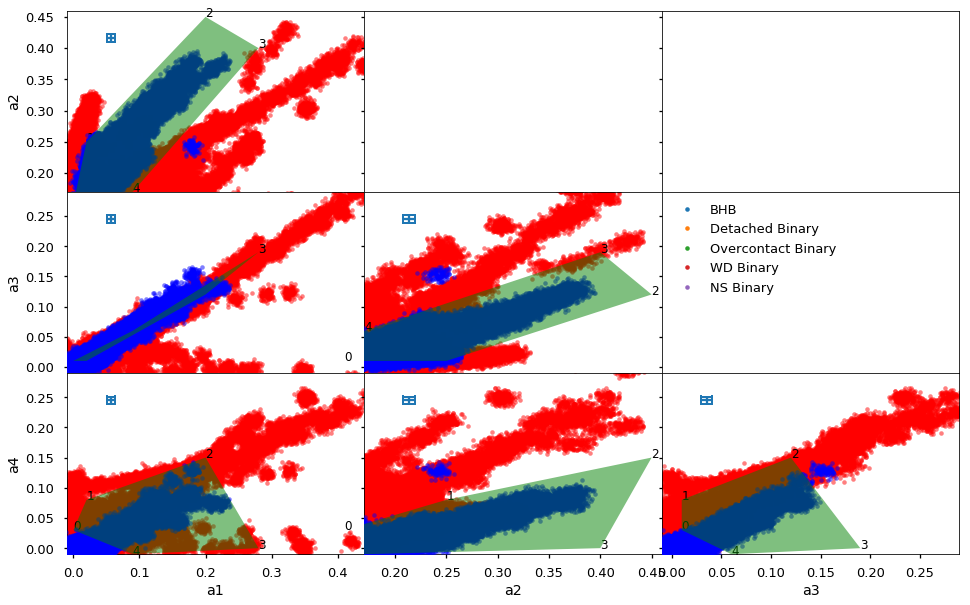

In [95]:
tri_plot(ifill=True,use_exp=True,savename='a2_a4_soft_cuts')

[ 0.207317  0.123993  0.197066  0.160254  0.113078  0.230589  0.017803
  0.016839  0.016152]
[ 0.018894  0.009531  0.015757  0.025131  0.014401  0.021956  0.000354
 -0.000515  0.001309]


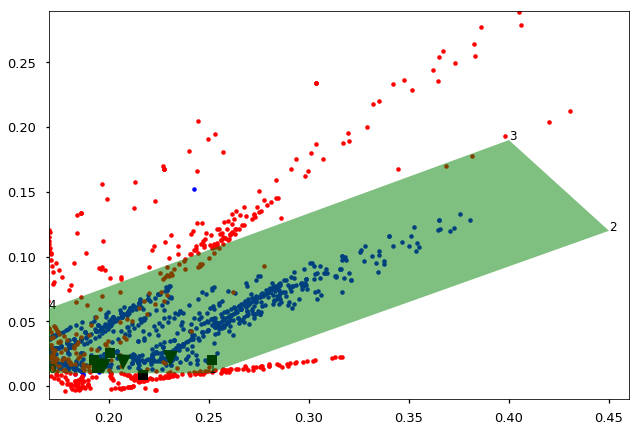

In [71]:
i=1
j=2
print(kBHdata[:,i])
print(kBHdata[:,j])

ML_ASAS=Table.read("/home/mw698/BHB/Palomar/Palomar_03_18/ASAS_cand/candidates.dat",format='ascii',delimiter='\t')
ML_LINEAR=Table.read("/home/mw698/BHB/Palomar/Palomar_03_18/LINEAR_cand/candidates.dat",format='ascii',delimiter='\t')

alph=1.0
plt.plot(BHdata[:,i],BHdata[:,j],'b.', label='BHB',alpha=alph)
plt.plot(nOCdata[:,i],nOCdata[:,j],'r.', label='Detached Binary',alpha=alph)
plt.plot(OCdata[:,i],OCdata[:,j],'r.',label="Overcontact Binary",alpha=alph)
plt.plot(WDdata[:,i],WDdata[:,j],'r.', label='WD Binary',alpha=alph)
plt.plot(NSdata[:,i],NSdata[:,j],'r.', label='NS Binary',alpha=alph)
plt.fill(edges[i],edges[j],'go',alpha=0.5,zorder=10)
plt.plot(kBHdata[:,i],kBHdata[:,j],'v',color='black', markersize=15, label='known',alpha=alph)
plt.plot(ML_ASAS['a'+str(i+1)],ML_ASAS['a'+str(j+1)],'ks')
for k in range(5):
    plt.text(edges[i][k],edges[j][k],"%g"%(k),fontsize=12)

plt.xlim(plim[i])
plt.ylim(plim[j])

plt.show()

In [88]:
###calculate contamination fraction

xlist=np.linspace(0,0.5)

cut1s=[]
a12top=interpolate.interp1d(edges[0][:3],edges[1][:3],fill_value='extrapolate')
a12bot=interpolate.interp1d(edges[0][[3,4,0]],edges[1][[3,4,0]],fill_value='extrapolate')
for l in explist:#simlists:
    a12cut=l[(l[:,1]<a12top(l[:,0])) & (l[:,1]>a12bot(l[:,0]))]
#     for jj in range(10):
#         print(np.random.choice(a12cut))
    cut1s.append(a12cut)

cut2s=[]
a23top=interpolate.interp1d(edges[1][[3,4]],edges[2][[3,4]],fill_value='extrapolate')
a23bot=interpolate.interp1d(edges[1][:3],edges[2][:3],fill_value='extrapolate')
for l in cut1s:
    a23cut=l[(l[:,2]<a23top(l[:,1])) & (l[:,2]>a23bot(l[:,1]))]
    cut2s.append(a23cut)

cut3s=[]
a24top=interpolate.interp1d(edges[1][:3],edges[3][:3],fill_value='extrapolate')
a24bot=interpolate.interp1d(edges[1][3:],edges[3][3:],fill_value='extrapolate')
for l in cut2s:
    a24cut=l[(l[:,3]<a24top(l[:,1])) & (l[:,3]>a24bot(l[:,1]))]
    cut3s.append(a24cut)

BHcount=len(cut3s[0])
print("%g BHs selected"%(BHcount))
nBHcount=0
for item in cut3s[1:]:
    nBHcount+=len(item)
print("%g nBHs selected"%(nBHcount))
print("%.2f%% contamination"%(nBHcount/(BHcount+nBHcount)*100))

84591 BHs selected
4668 nBHs selected
5.23% contamination


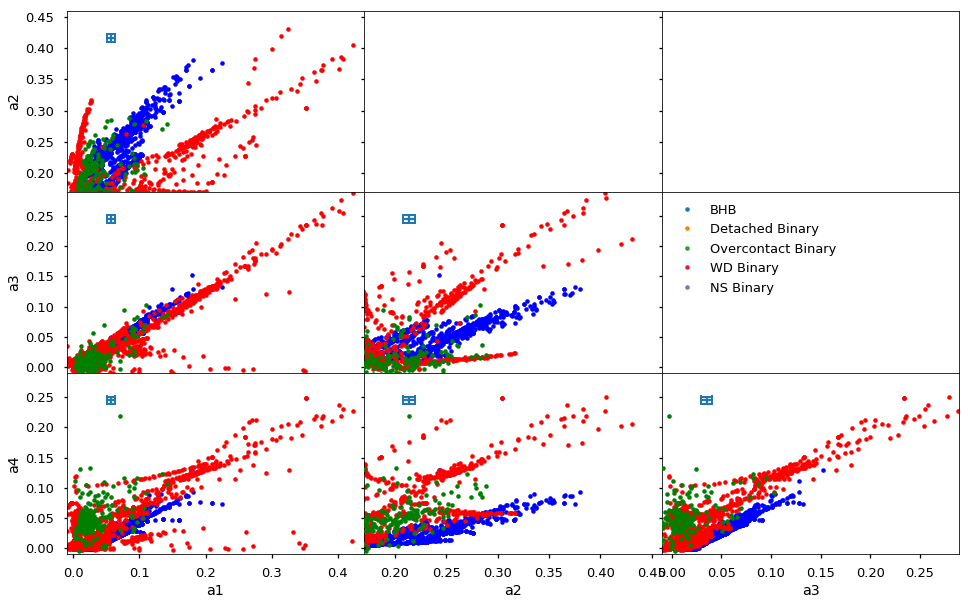

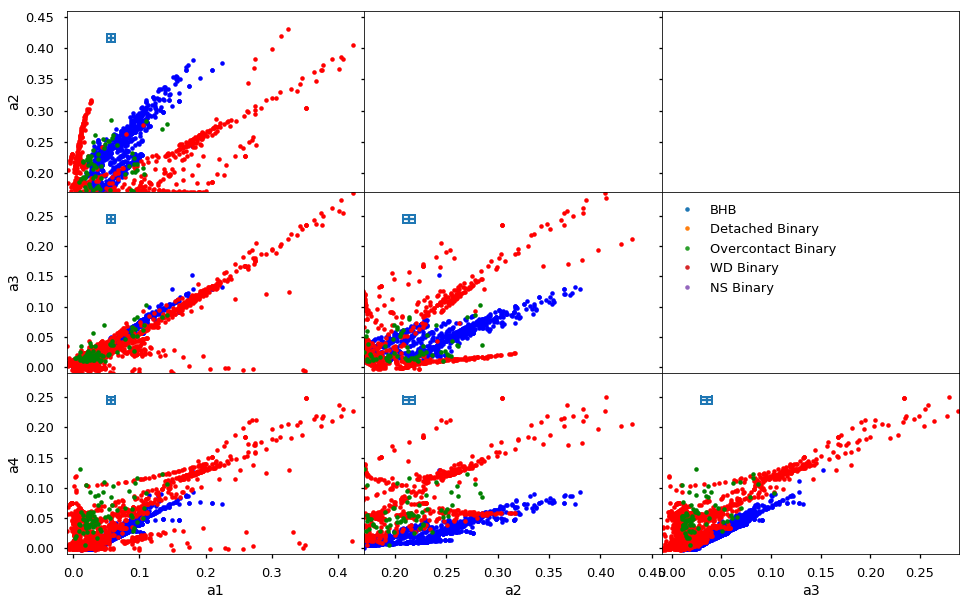

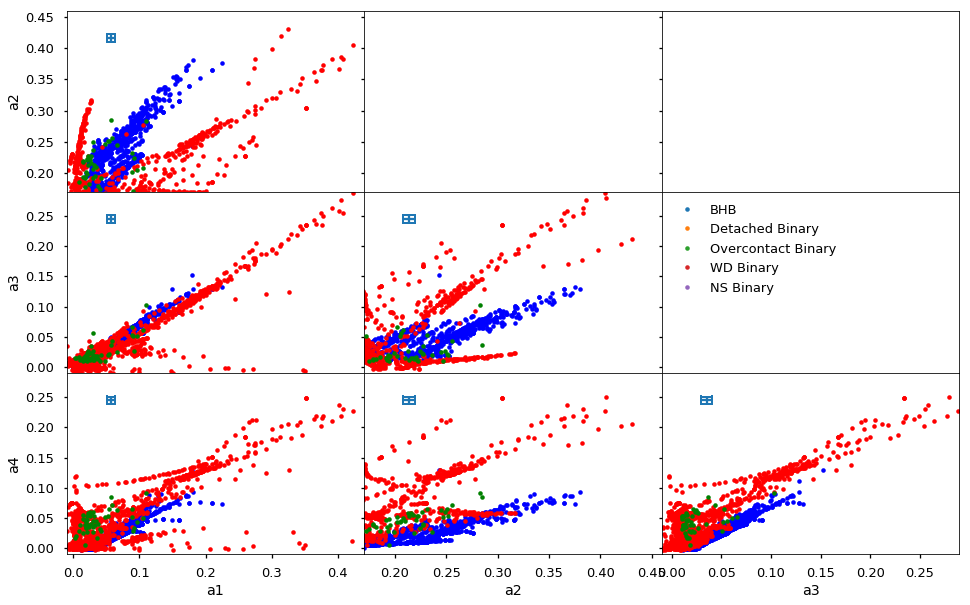

(74, 40, 23)
23
20
4


In [89]:
xlist=np.linspace(0,0.5)

cut1=[]
a12top=interpolate.interp1d(edges[0][:3],edges[1][:3],fill_value='extrapolate')
a12bot=interpolate.interp1d(edges[0][[3,4,0]],edges[1][[3,4,0]],fill_value='extrapolate')
for l in fulldatalist:
    a12cut=l[(l['col3']<a12top(l['col2'])) & (l['col3']>a12bot(l['col2']))]
#     for jj in range(10):
#         print(np.random.choice(a12cut))
    cut1.append(a12cut)
tri_plot(cut1)

cut2=[]
a23top=interpolate.interp1d(edges[1][[3,4]],edges[2][[3,4]],fill_value='extrapolate')
a23bot=interpolate.interp1d(edges[1][:3],edges[2][:3],fill_value='extrapolate')
for l in cut1:
    a23cut=l[(l['col4']<a23top(l['col3'])) & (l['col4']>a23bot(l['col3']))]
    cut2.append(a23cut)
tri_plot(cut2)

cut3=[]
a24top=interpolate.interp1d(edges[1][:3],edges[3][:3],fill_value='extrapolate')
a24bot=interpolate.interp1d(edges[1][3:],edges[3][3:],fill_value='extrapolate')
for l in cut2:
    a24cut=l[(l['col5']<a24top(l['col3'])) & (l['col5']>a24bot(l['col3']))]
    cut3.append(a24cut)
tri_plot(cut3)

print(len(cut1[0]),len(cut2[0]),len(cut3[0]))
for l in cut3:
    print(len(l))

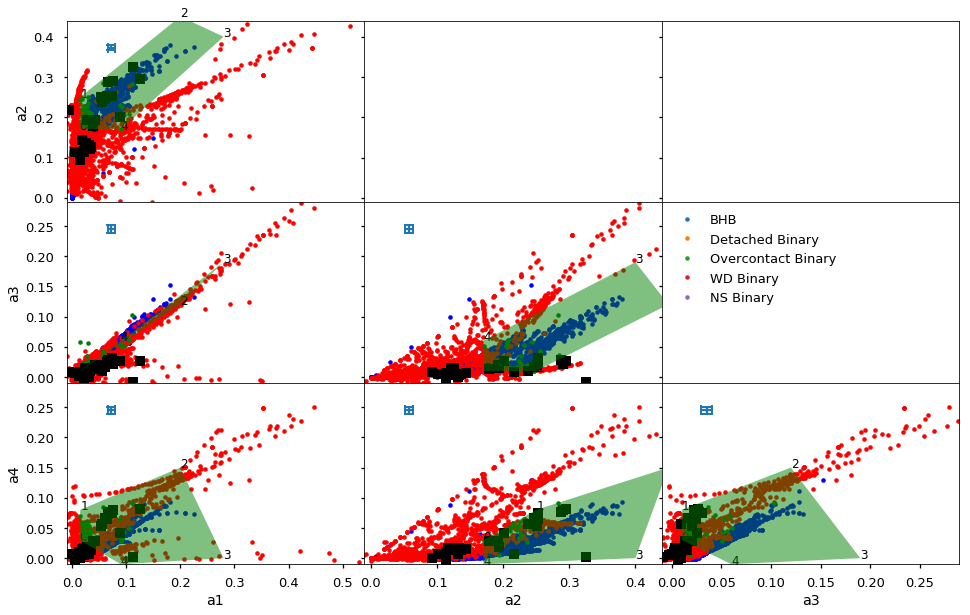

In [79]:
#compare location of previous candidates and current candidates

ML_ASAS=Table.read("/home/mw698/BHB/Palomar/Palomar_03_18/ASAS_cand/candidates.dat",format='ascii',delimiter='\t')
ML_LINEAR=Table.read("/home/mw698/BHB/Palomar/Palomar_03_18/LINEAR_cand/candidates.dat",format='ascii',delimiter='\t')

tri_plot(cut3,[ML_ASAS,ML_LINEAR],True,False)

### Print Selected Candidates

So, it looks like there are 6 candidates selected by the hard cuts method which are visible for my July 2018 run

23 total ASAS candidates
mean error=0.0155735
68 data points


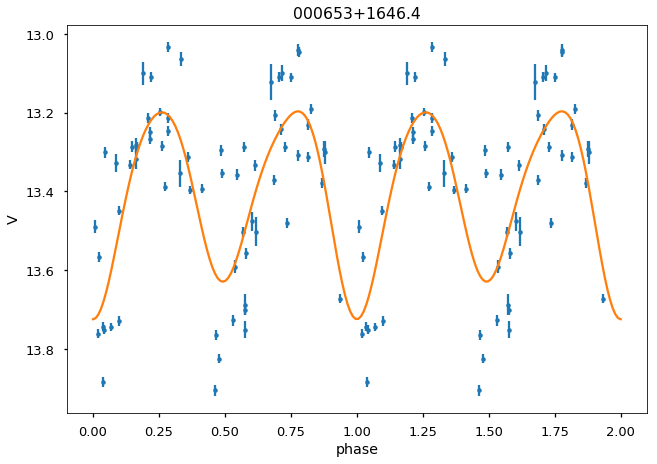

mean error=0.014775
80 data points


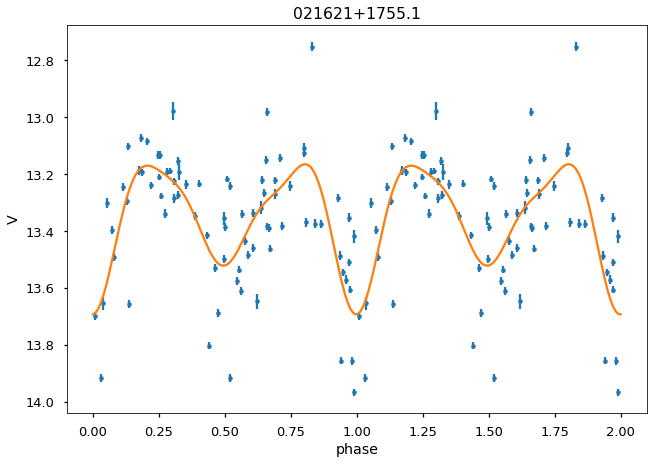

mean error=0.0211898
137 data points


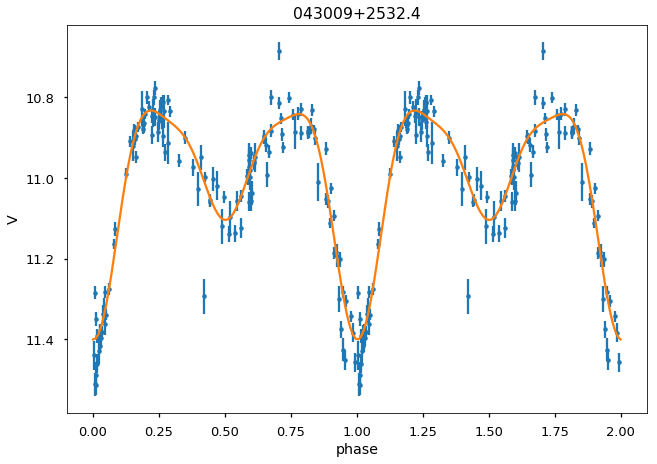

mean error=0.0179247
93 data points


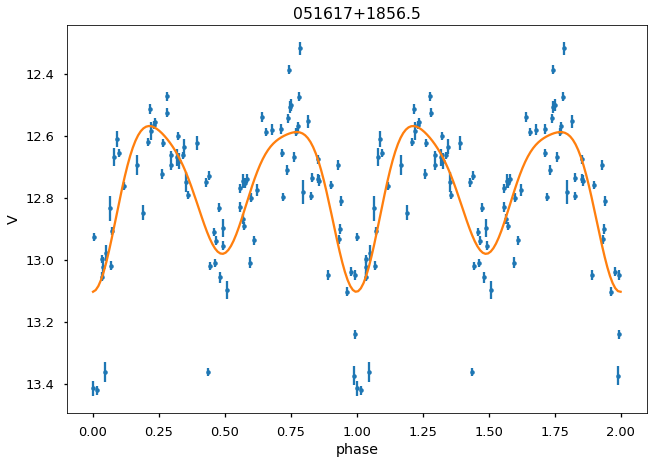

mean error=0.0181118
152 data points


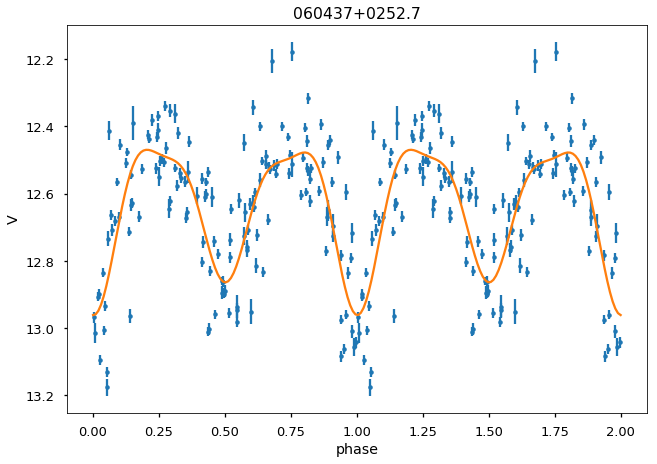

mean error=0.0223484
244 data points


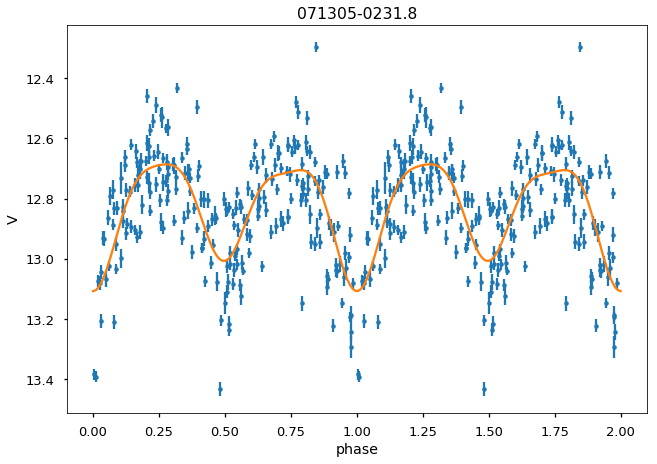

mean error=0.0211179
195 data points


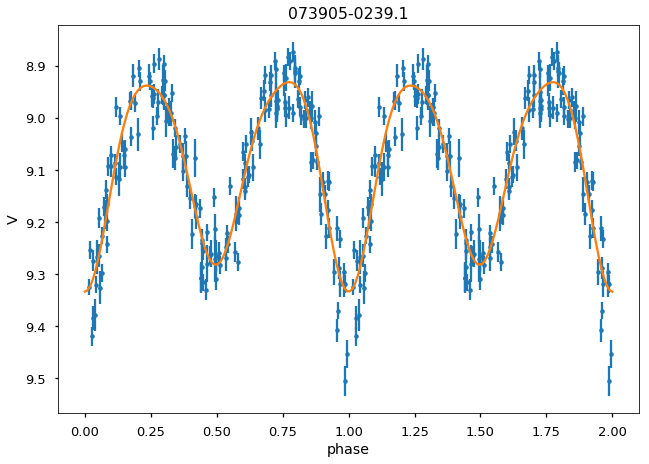

mean error=0.0186838
117 data points


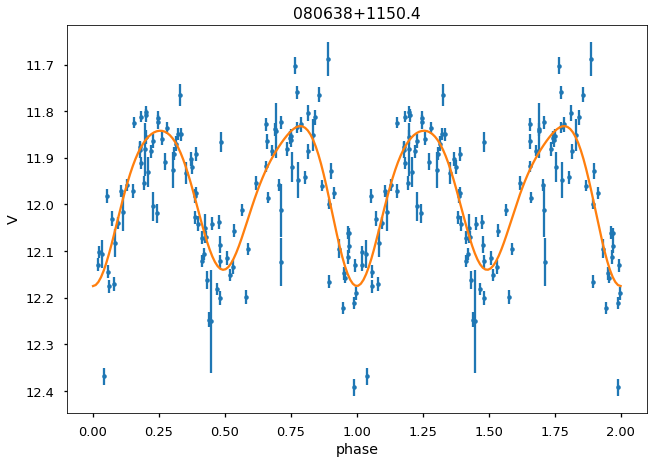

mean error=0.0177935
184 data points


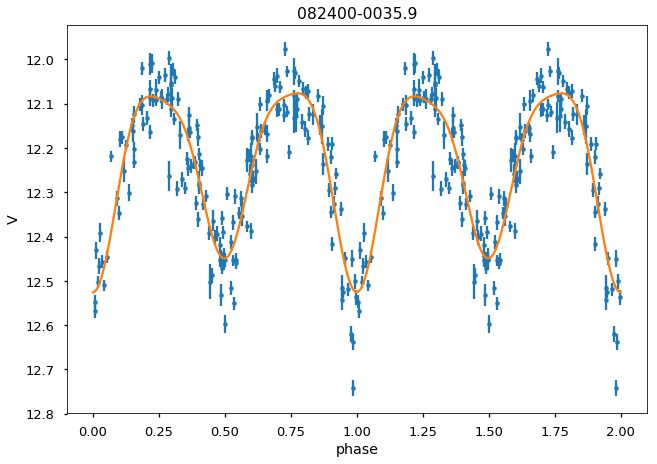

mean error=0.0177895
171 data points


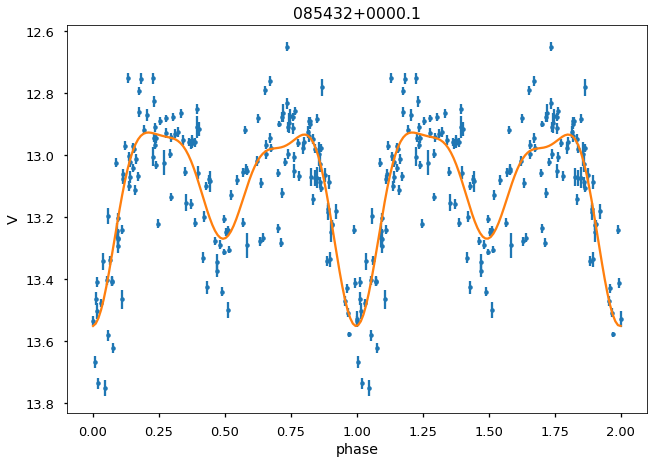

mean error=0.0167317
123 data points


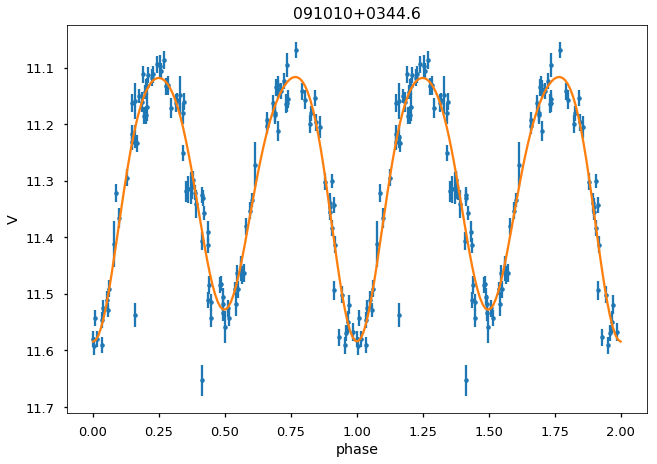

mean error=0.0160823
158 data points


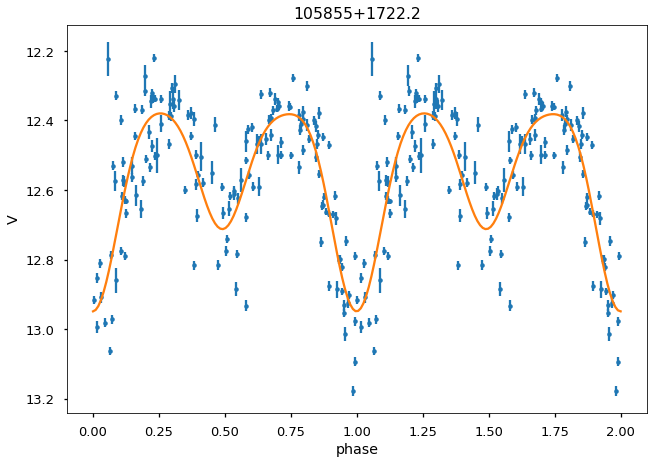

mean error=0.0170584
137 data points


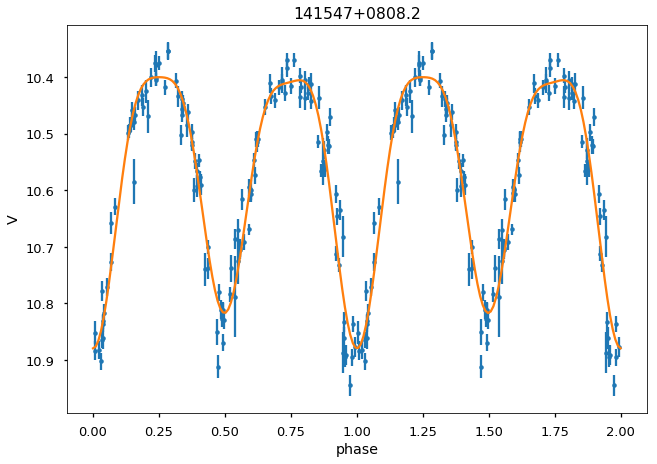

mean error=0.0145083
120 data points


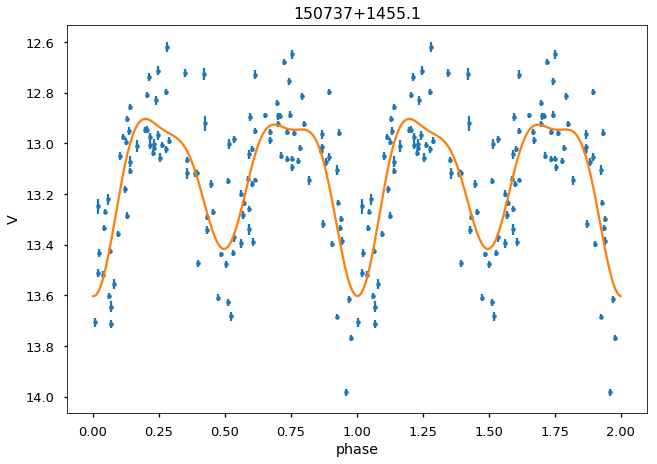

mean error=0.0159098
122 data points


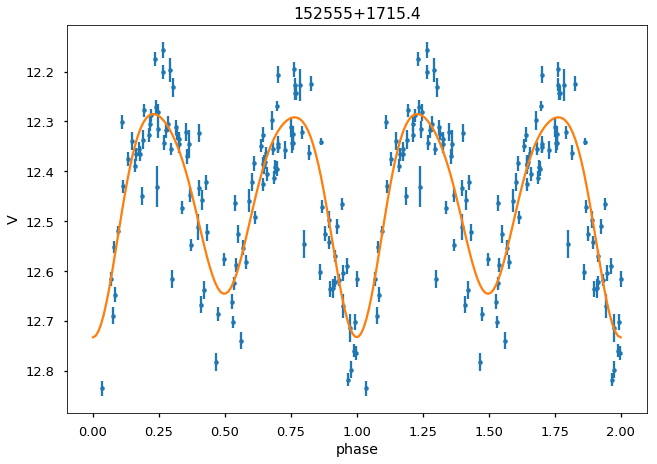

mean error=0.0169072
97 data points


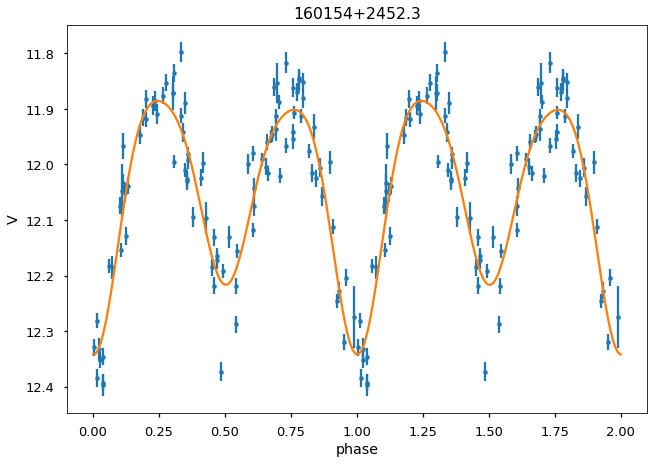

mean error=0.0177227
119 data points


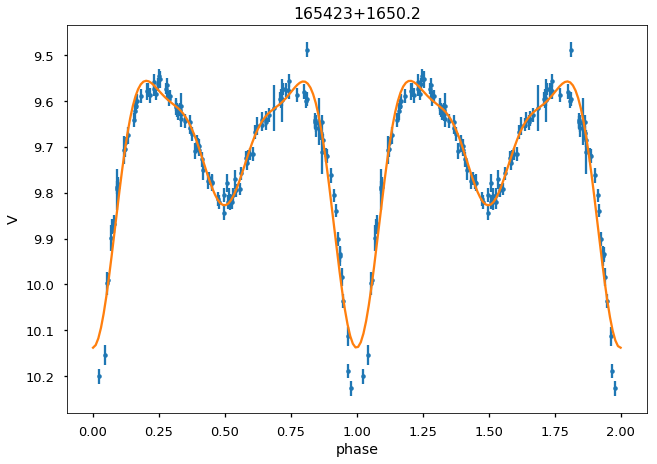

mean error=0.0179364
110 data points


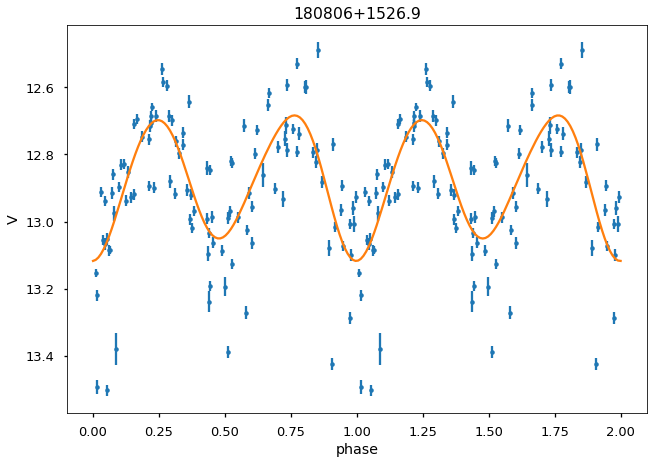

mean error=0.0177706
109 data points


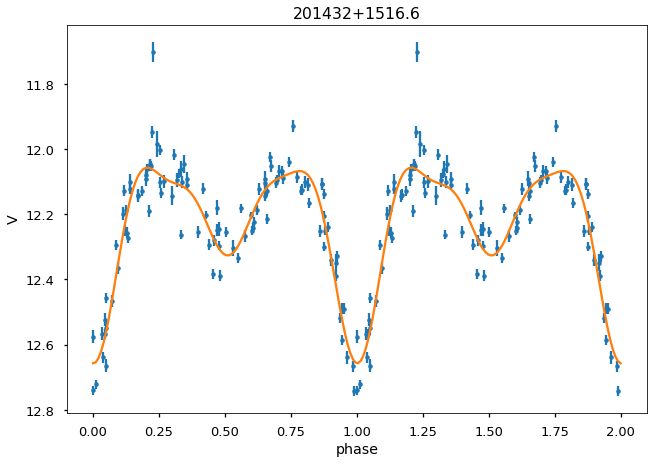

mean error=0.0179277
166 data points


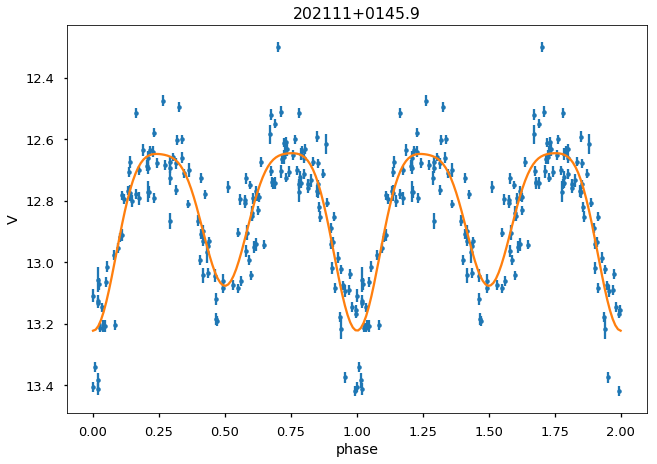

mean error=0.0175741
108 data points


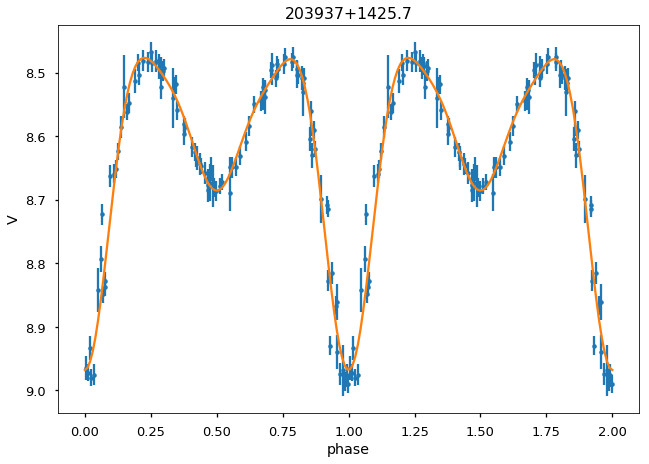

mean error=0.0192579
159 data points


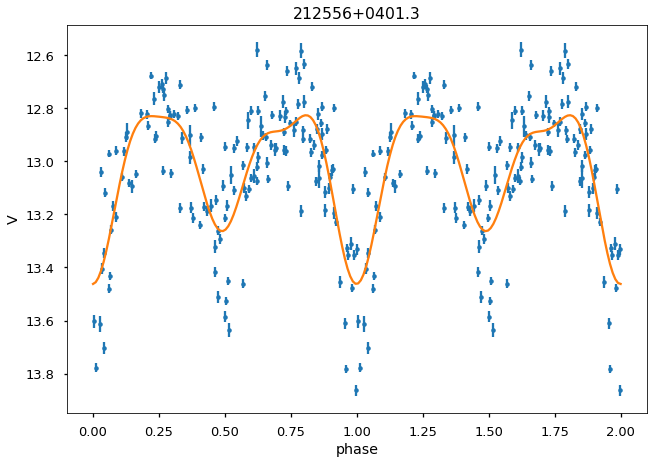

mean error=0.0173735
83 data points


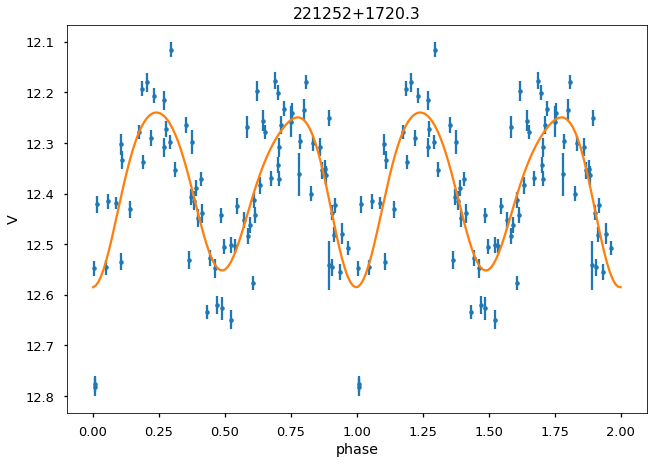

In [90]:
def ASASinfo(key):
    rawdata=open('/net/geha/mw698/ASAN/%s.lc'%key)
    rawlines=rawdata.readlines()
    RAline=rawlines[3].split()
    DECline=rawlines[4].split()
    Vmagline=rawlines[6].split()
    return (15*float(RAline[1]),DECline[1],Vmagline[1])

cand=open('/home/mw698/BHB/Palomar/Palomar_07_18/ASAS_cand/candidates.dat','w')
cand.write('ASAS ID\tRA\tDec\tP\tV\ta1\ta2\ta3\ta4\tb1\tb2\tb3\tb4\tm0\n')

cut3[0]=np.sort(cut3[0])
print("%g total ASAS candidates"%len(cut3[0]))
for line in cut3[0]:
    key=line[0]
    RA,DEC,mag=ASASinfo(key)
    P=ASAS_period_dict[key]
#     if abs(RA-270)<60:
#         ASASplot(key,True,save=False,ichain=0)
#         print(RA,DEC,mag)
#     else:
#         print('%s not visible'%key)
    mu=ASASplot(key,True,save=True,ichain=0)
    cand.write('%s\t%.6f\t%s\t%.4f\t%s\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\n'%(key,RA,DEC,P,mag,mu[0],mu[1],mu[2],mu[3],mu[4],mu[5],mu[6],mu[7],mu[8]))
cand.close()
        
#4 ASAS candidates

20 total LINEAR candidates
mean error=0.0461758


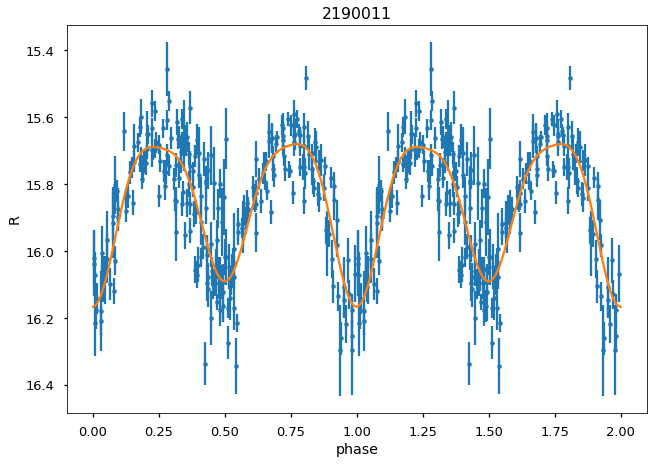

mean error=0.0838761


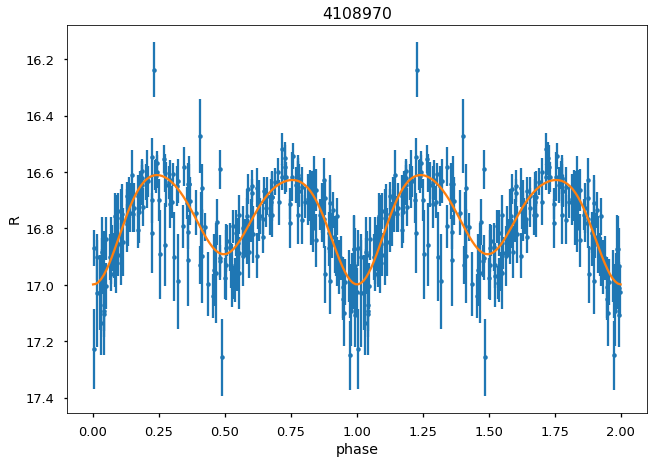

mean error=0.108233


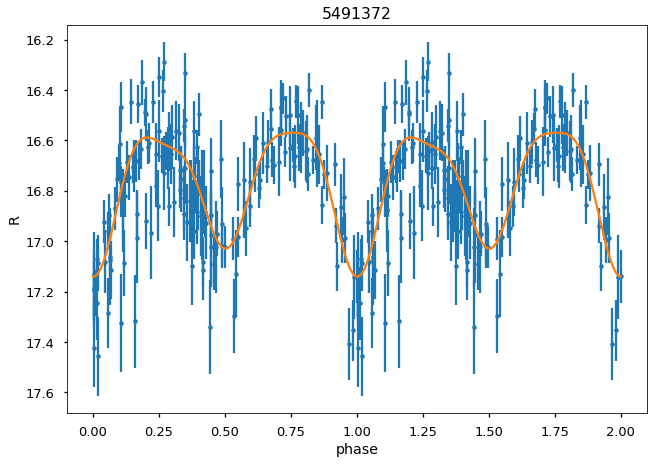

mean error=0.0489763


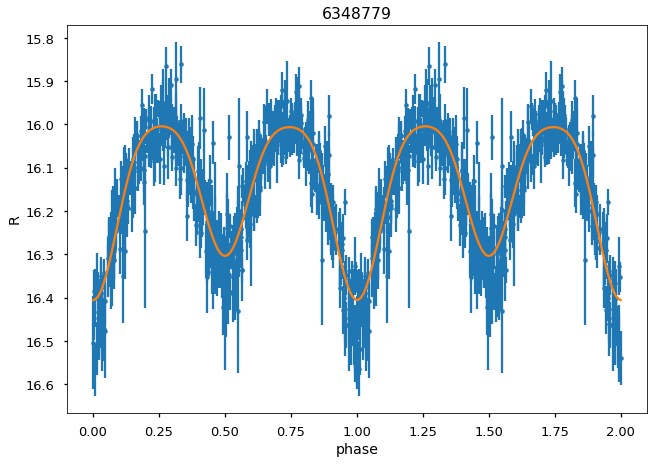

mean error=0.0141696


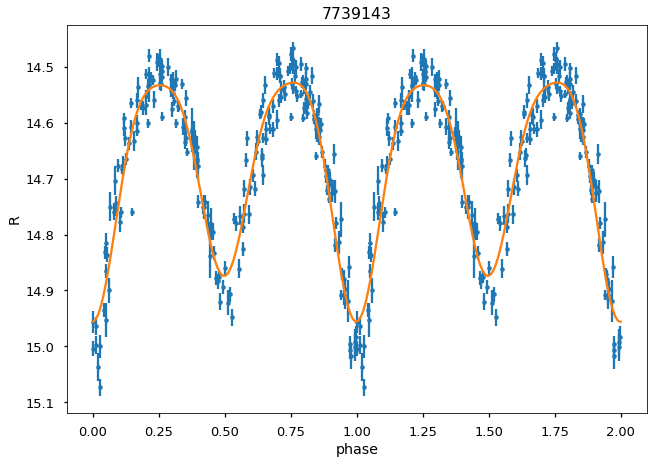

mean error=0.0870479


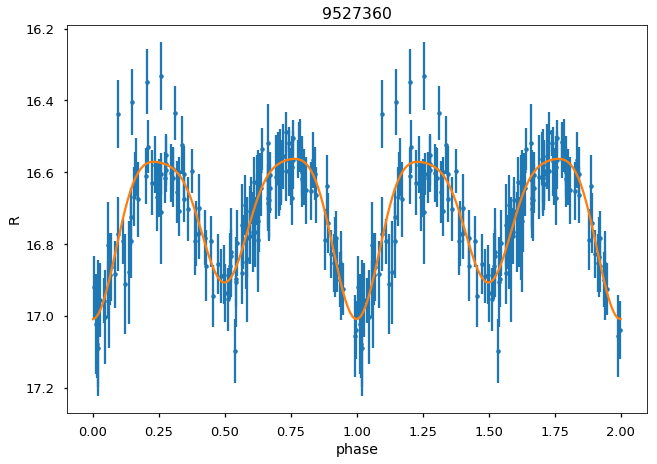

mean error=0.0795217


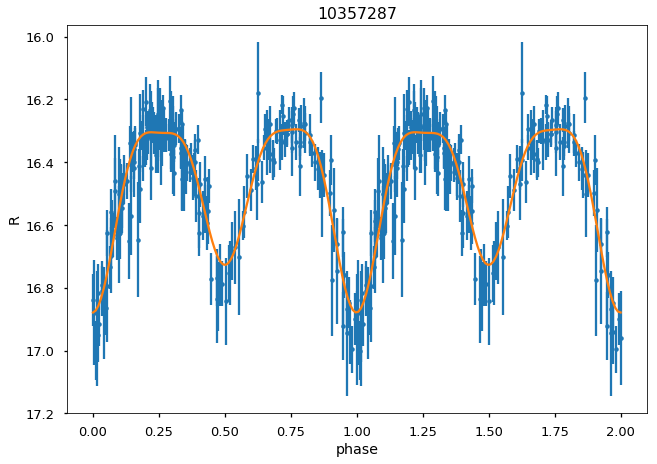

mean error=0.0186201


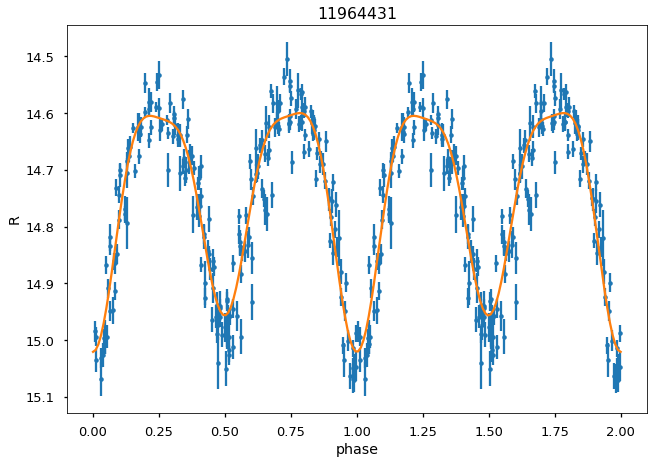

mean error=0.0582897


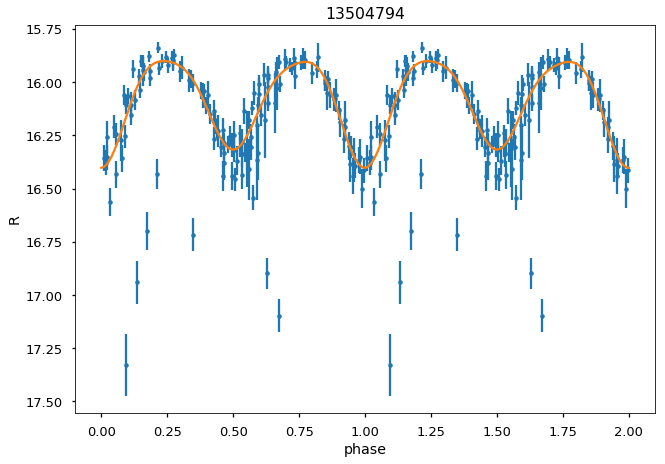

mean error=0.0930785


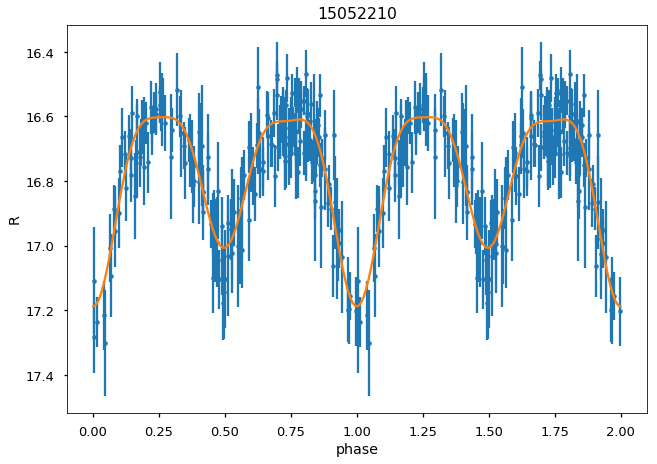

mean error=0.0980514


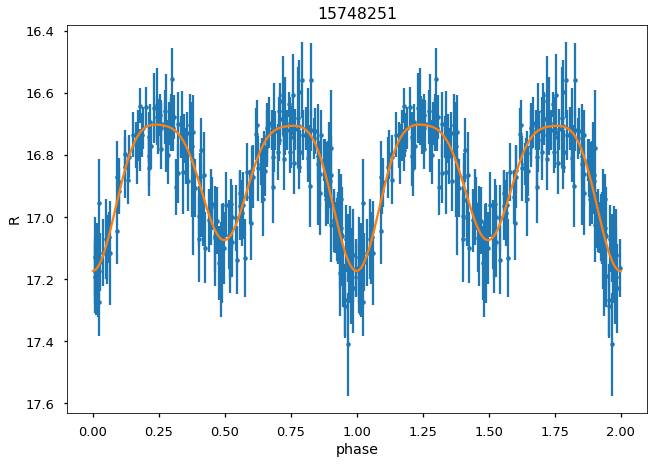

mean error=0.0431256


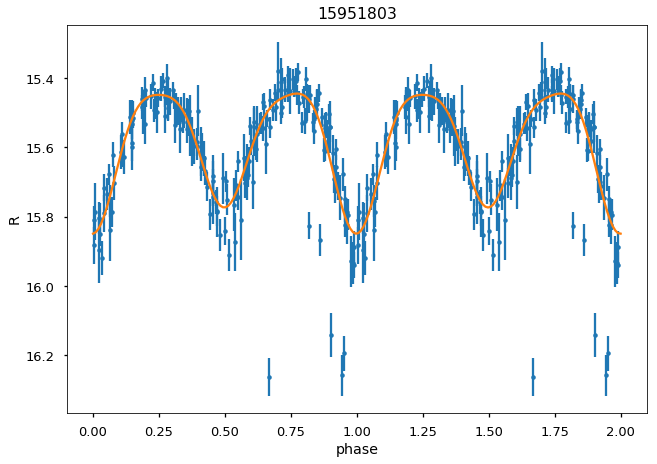

mean error=0.0113784


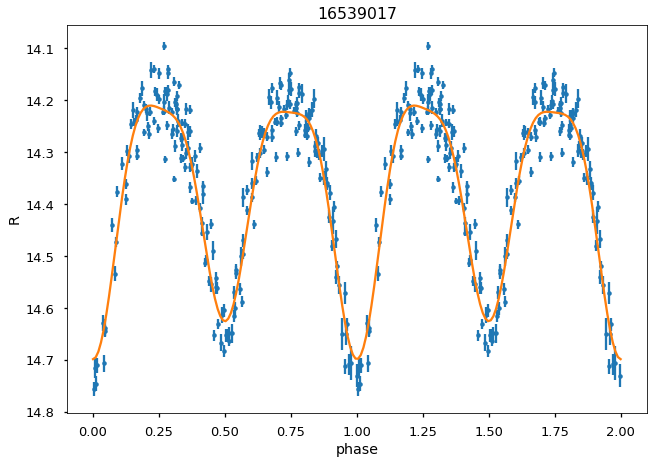

mean error=0.033032


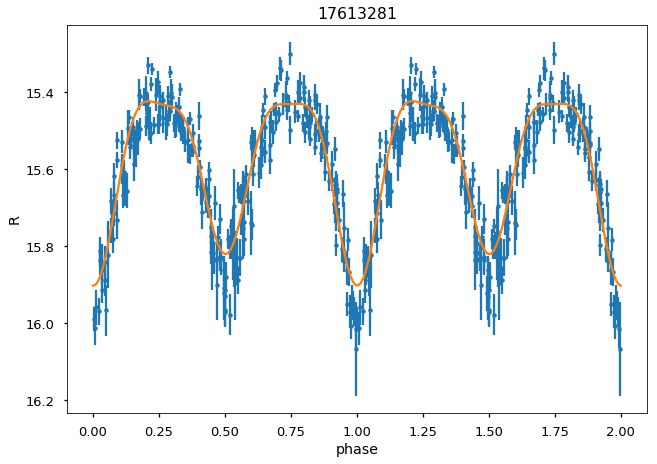

mean error=0.0434888


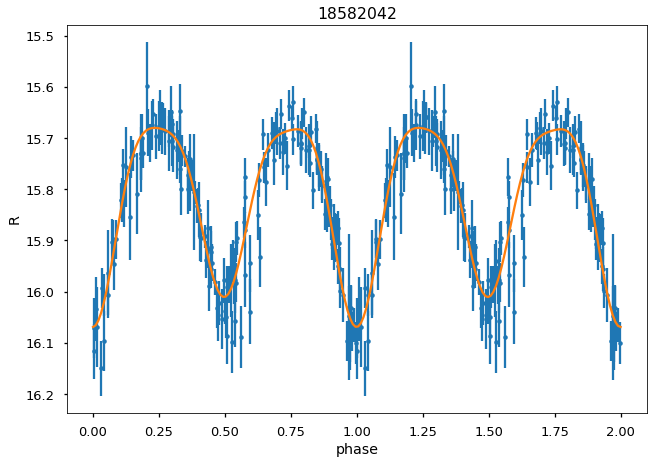

mean error=0.0677822


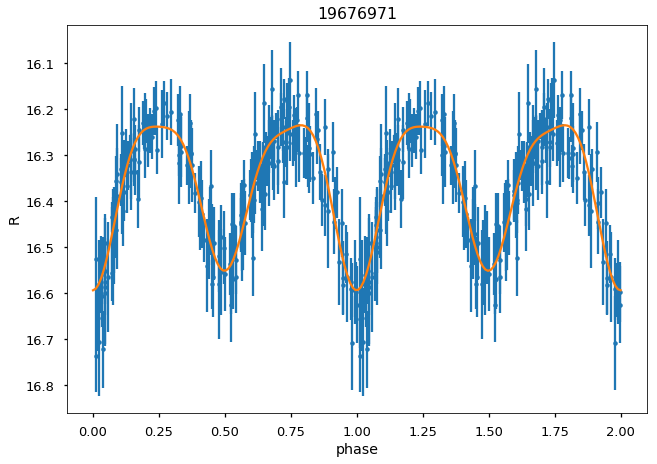

mean error=0.0203497


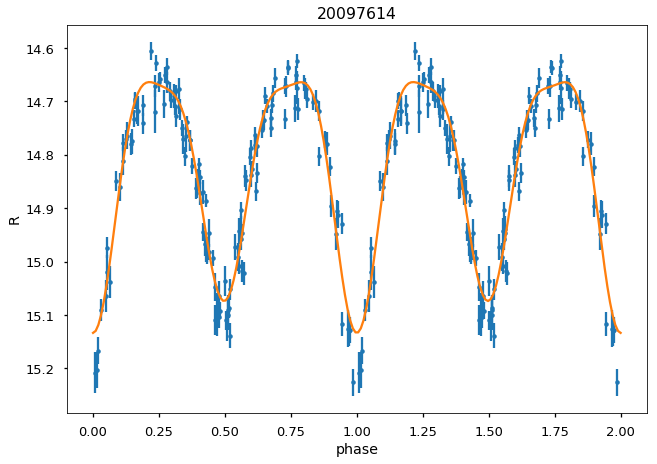

mean error=0.0709071


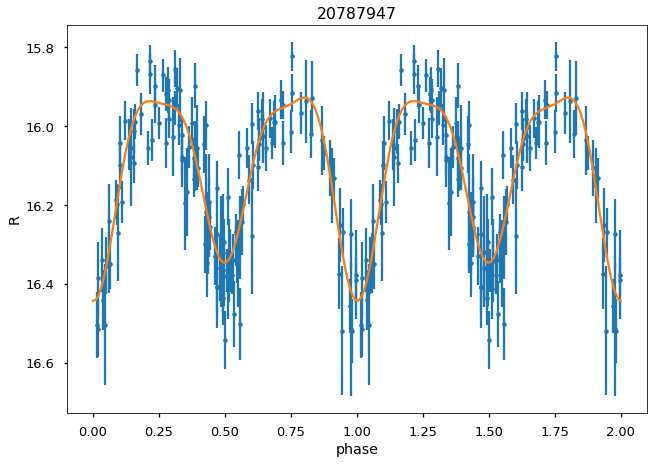

mean error=0.0173954


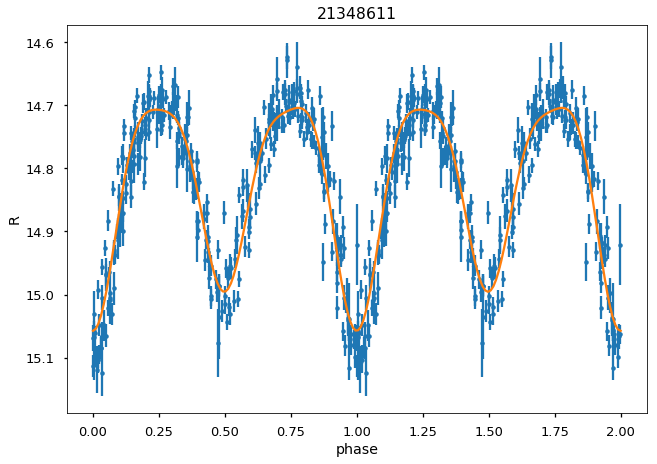

mean error=0.0409375


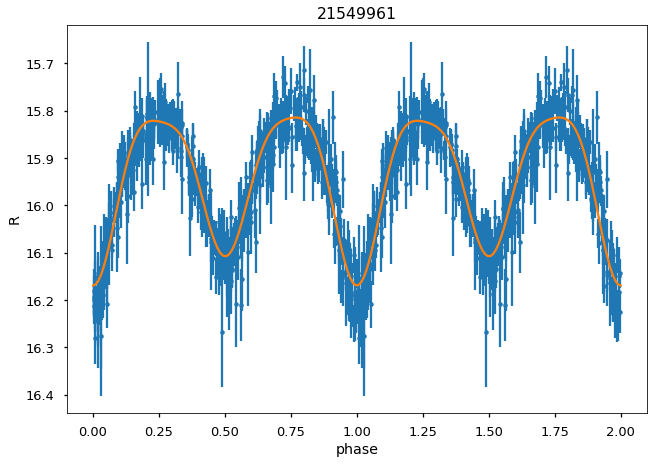

In [91]:
SDSS=Table.read('/net/geha/mw698/LINEAR/PLV_SDSS.dat',format='ascii')
cand=open('/home/mw698/BHB/Palomar/Palomar_07_18/LINEAR_cand/candidates.dat','w')
cand.write('LINEAR ID\tRA\tDec\tP\tr\ta1\ta2\ta3\ta4\tb1\tb2\tb3\tb4\tm0\n')

cut3[1]=np.sort(cut3[1])
print("%g total LINEAR candidates"%len(cut3[1]))
for l in cut3[1]:
    key=str(l[0])
    line=SDSS[SDSS['LINEARobjectID']==float(key)]
    RA=line['RA'][0]
    DEC=line['Dec'][0]
    mag=line['r'][0]
    P=LINEAR_period_dict[key]
#     if abs(RA-270)<60:
#         LINEARplot(key,True,save=False)
#         print(RA,DEC,mag)
#     else:
#         print('%s not visible'%key)
    mu=LINEARplot(key,True,save=True)
    cand.write('%s\t%.6f\t%.6f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\n'%(key,RA,DEC,P,mag,mu[0],mu[1],mu[2],mu[3],mu[4],mu[5],mu[6],mu[7],mu[8]))
cand.close()
        
#1 LINEAR candidate

4 total STRIPE82 candidates
mean error=0.0366154


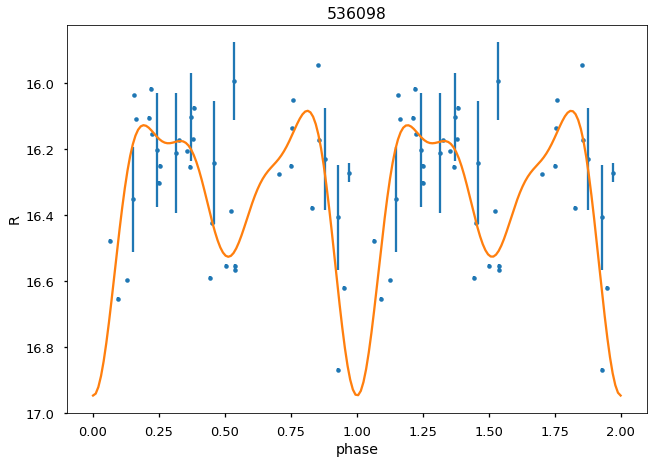

mean error=0.00713208


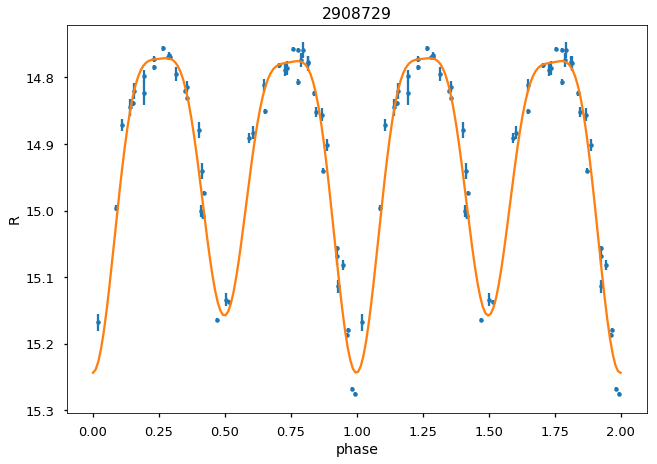

mean error=0.0117586


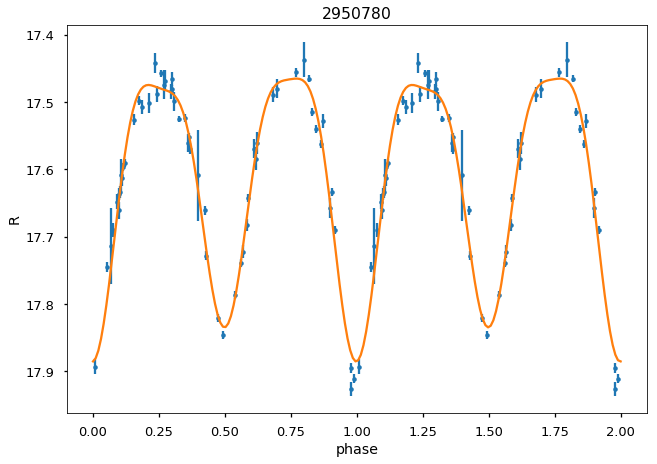

mean error=0.00634615


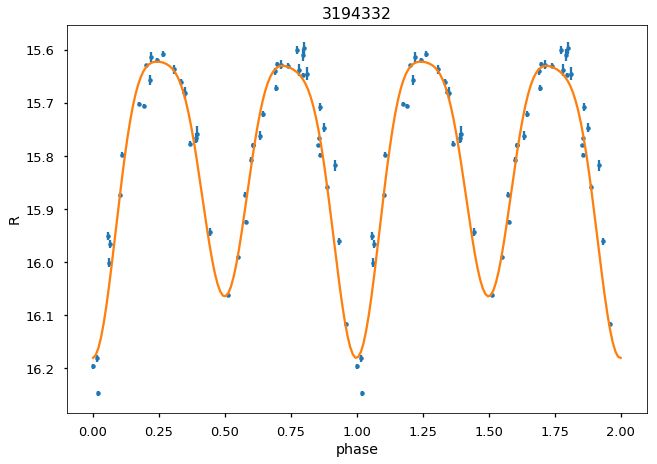

In [94]:
infoTable=Table.read("/net/geha/mw698/STRIPE82/stripe82candidateVar_v1.1.dat",format='ascii')
cand=open('/home/mw698/BHB/Palomar/Palomar_07_18/STRIPE82_cand/candidates.dat','w')
cand.write('STRIPE82 ID\tRA\tDec\tP\tr\ta1\ta2\ta3\ta4\tb1\tb2\tb3\tb4\tm0\n')

cut3[2]=np.sort(cut3[2])
print("%g total STRIPE82 candidates"%len(cut3[2]))
for line in cut3[2]:
    key=str(line[0])
    item=infoTable[infoTable['col1']==float(key)]
    RA=item['col2'][0]
    DEC=item['col3'][0]
    P=item['col4'][0]
    mag=item['col5'][0]
#     if abs(RA-270)<60:
#         STRIPE82plot(key,True)
#         print(RA,DEC,mag)
#     else:
#         print('%s not visible'%key)
    mu=STRIPE82plot(key,True,save=True)
    cand.write('%s\t%.6f\t%.6f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\n'%(key,RA,DEC,P,mag,mu[0],mu[1],mu[2],mu[3],mu[4],mu[5],mu[6],mu[7],mu[8]))
cand.close()

In [480]:
####code block not finished as no MACHO object is visible from Palomar 

allMACHO=np.concatenate((cut3[3],cut3[4]))
for line in allMACHO:
    LC=line[0]
    
    #get info
    fnum=LC.split('.')[0]
    os.chdir("/net/geha/mgeha/MACHO/F_%s"%fnum)
    rawfile=open(LC)
    rawlines=rawfile.readlines()
    headerlines=rawlines[:9]
    header=[line.split() for line in headerlines]
    rawRA=header[0][4:7]
    RA=rawRA[0]+':'+rawRA[1]+':'+rawRA[2]
    rawDEC=header[0][8:11]
    DEC=rawDEC[0]+':'+rawDEC[1]+':'+rawDEC[2]
    r=float(header[6][2])
    b=float(header[7][2])
    color=b-r
    R=r+23.41+0.18*(color) if b!=-99 else r+23.41
    if float(fnum)<100:
        loc='LMC'
    elif 201<=float(fnum)<=299:
        loc='SMC'
    else:
        loc='bulge'
    MACHO_period_dict=load_obj('lc_periods_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    period=MACHO_period_dict[LC]
        
    ra = coord.Angle(RA, unit=u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(DEC, unit=u.degree)
    print(ra,dec)

(<Angle 18.15831555555556 deg>, <Angle -27.381491666666665 deg>)
(<Angle 18.199526111111112 deg>, <Angle -27.685205555555555 deg>)
(<Angle 17.999765833333328 deg>, <Angle -28.181619444444447 deg>)


In [133]:
def Multifunc(order):
    def func(x, *a):
        out= 0
        for i in range(order):
            out += a[i]*np.cos(2*(i+1)*np.pi*x)
        for i in range(order,2*order):
            out += a[i]*np.sin(2*(i+1-order)*np.pi*x)
        out += a[2*order]
        return out
    return func

forder=20
func=Multifunc(forder)
p0=tuple(1 for i in range(2*forder+1))

BHdata2=Table.read("/home/mw698/BHB/BH_a2_a4.m1.dat",format='ascii')
nBHdata2=Table.read("/home/mw698/BHB/nBH_a2_a4.m1.dat",format='ascii')
n=0
#these are very high incl systems
for item in BHdata2:
    if item[2]<item[3]*2:
        n+=1
        print(item[0])
#         d=np.loadtxt(item[0]+'/modelR.mag')
#         plt.plot(d[:,0],d[:,1])
#         plt.ylim(reversed(plt.ylim()))
#         plt.show()
print(n)

n=0
#these are also very high incl systems
for item in BHdata2:
    if (item[-1]>15) and (item[-1]<50) and (item[1]>0.1):
        n+=1
        print(item[0])
#         d=np.loadtxt(item[0]+'/modelR.mag')
#         plt.plot(d[:,0]-0.5,d[:,1])
#         mu,cov=curve_fit(func,d[:,0]-0.5,d[:,1],p0=p0)
#         print(mu)
#         plt.plot(d[:,0],[func(x,*mu) for x in d[:,0]])
#         plt.ylim(reversed(plt.ylim()))
#         plt.show()
print(n)

n=0
#these are also very high incl systems
for item in nBHdata2:
    if (0.04<item[3]<0.06) and (0.02<item[4]<0.04):
        n+=1
        print(item[0])
#         d=np.loadtxt(item[0]+'/modelR.mag')
#         plt.plot(d[:,0]-0.5,d[:,1])
#         mu,cov=curve_fit(func,d[:,0]-0.5,d[:,1],p0=p0)
#         print(mu)
#         plt.plot(d[:,0],[func(x,*mu) for x in d[:,0]])
#         plt.ylim(reversed(plt.ylim()))
#         plt.show()
print(n)

INC_TEST_2/A0620_phy_6
INC_TEST_2/A0620_phy_31
INC_TEST_2/A0620_phy_49
INC_TEST_2/A0620_phy_53
INC_TEST_2/A0620_phy_74
INC_TEST_2/A0620_phy_91
INC_TEST_2/A0620_phy_99
7
INC_TEST_2/A0620_phy_6
INC_TEST_2/A0620_phy_31
2
AV_Del_T1/AV_Del_13
AV_Del_T1/AV_Del_14
AV_Del_T1/AV_Del_15
AV_Del_T1/AV_Del_16
AV_Del_T1/AV_Del_17
AV_Del_T1/AV_Del_18
AV_Del_T1_2/AV_Del_13
AV_Del_T1_2/AV_Del_14
AV_Del_T1_2/AV_Del_15
AV_Del_T1_2/AV_Del_16
AV_Del_T1_2/AV_Del_17
AV_Del_T1_2/AV_Del_18
AV_Del_T1_4/AV_Del_13
AV_Del_T1_4/AV_Del_14
AV_Del_T1_4/AV_Del_15
AV_Del_T1_4/AV_Del_16
AV_Del_T1_4/AV_Del_17
AV_Del_T1_4/AV_Del_18
18


In [104]:
n=0
for item in BHdata:
    if item[2]<item[3]:
        n+=1
        print(item)
print(n)

[  6.09600000e-03   3.39760000e-02  -1.60100000e-03   2.73000000e-04
   6.29200800e+01]
[  5.75100000e-03   1.54420000e-02  -4.58000000e-04   5.70000000e-05
   6.29200800e+01]
[  4.00000000e-06   5.88000000e-04  -4.00000000e-06   0.00000000e+00
   1.00098435e+02]
[  2.73900000e-03   2.30780000e-02   1.90000000e-04   1.99000000e-04
   2.67937700e+01]
[  2.68700000e-03   2.33690000e-02   1.80000000e-04   1.97000000e-04
   2.67937700e+01]
[  2.73900000e-03   2.30780000e-02   1.90000000e-04   1.99000000e-04
   2.67937700e+01]
[  2.68700000e-03   2.33690000e-02   1.80000000e-04   1.97000000e-04
   2.67937700e+01]
[-0.018045  0.108494 -0.002122  0.003378  1.024627]
8


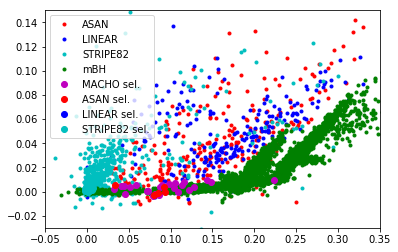

ASAN 5,, LINEAR 0, STRIPE82 42, MACHO 24, Total 71
ASAN keys
['020857+1734.8', '155047+0505.4', '091707+0107.0', '205719+0548.9', '135417+1653.7']
LINEAR keys
[]
STRIPE82 keys
['3372105', '1942893', '2658752', '2668821', '3360149', '1416609', '1508378', '3500285', '3266369', '3514427', '1757215', '3256039', '3092055', '27948', '1401003', '2161395', '3401686', '1935765', '797396', '789328', '4547501', '3864262', '4110499', '383771', '789880', '2258572', '797792', '3830893', '2941989', '3180201', '185410', '3460679', '1201483', '2375930', '1108433', '28943', '93425', '2866290', '3682212', '1399097', '3452407', '2675262']
MACHO keys
['124.21632.1053', '125.23455.779', '127.23184.368', '132.31168.1103', '132.31175.14', '134.33779.163', '136.28568.452', '137.30114.256', '146.28409.851', '147.32054.55', '148.26587.279', '157.26289.35', '158.26145.489', '162.25084.2850', '17.2586.264', '17.1987.482', '180.22630.160', '302.45939.68', '304.36231.227', '306.36389.279', '310.37230.894', '46.764.1

In [25]:
# #selected=foo(MACHO,gmm_best,tol=1)
# selected2=foo2(MACHO,gmm_best,tol=-2)
# ASANsel2=foo2(ASAN,gmm_best,tol=-2)
# LINEARsel2=foo2(LINEAR,gmm_best,tol=-2)
# #selected3=foo3(MACHO,gmm_best,tol=0.01)
# #print(len(selected2),len(s3))
# #print(len(selected2)/len(MACHO))
# #plt.plot(nBHdata[:,1],nBHdata[:,3],'.',label='nBH')
# plt.plot(m[:,1],m[:,3],'.',label='mBH')
# plt.plot(MACHOdata[:,1],MACHOdata[:,3],'.',label='MACHO')
# #plt.plot(selected[:,0],selected[:,1],'.',label='selected')
# #plt.plot(selected3[:,1],selected3[:,3],'x',label='selected3')
# #plt.plot(selected2[:,1],selected2[:,3],'.',label='selected2')
# plt.legend()
# plt.xlim(-0.05,0.35)
# plt.ylim(-0.03,0.15)
# for item in selected2:
#     if item[1]>0.2:
#         print item
        
#tol=-8.5
tol=2.5
m,l=gmm_best.sample(5000)
selected2=foo2(MACHO,gmm_best,tol=tol,nmodel=ngmm_best)
ASANkeys,ASANselected2=foo2(ASAN,gmm_best,tol=tol, nmodel=ngmm_best)
LINEARkeys,LINEARselected2=foo2(LINEAR,gmm_best,tol=tol,nmodel=ngmm_best)
STRIPE82keys,STRIPE82selected2=foo2(STRIPE82,gmm_best,tol=tol,nmodel=ngmm_best)
MACHOkeys, MACHOselected2=foo2(MACHO,gmm_best,tol=tol,nmodel=ngmm_best)
#plt.plot(nBHdata[:,1],nBHdata[:,3],'.',label='nBH')
#plt.plot(MACHOdata[:,1],MACHOdata[:,3],'y.',label='MACHO')
#plt.plot(MACHOdata['col3'],MACHOdata['col5'],'m.',label='MACHO')
plt.plot(ASANdata['col3'],ASANdata['col5'],'r.',label='ASAN')
plt.plot(LINEARdata['col3'],LINEARdata['col5'],'b.',label='LINEAR')
plt.plot(STRIPE82data['col3'],STRIPE82data['col5'],'c.',label='STRIPE82')
plt.plot(m[:,1],m[:,3],'g.',label='mBH')
plt.plot(MACHOselected2[:,1],MACHOselected2[:,3],'mo',label='MACHO sel.')
plt.plot(ASANselected2[:,1],ASANselected2[:,3],'ro',label='ASAN sel.')
plt.plot(LINEARselected2[:,1],LINEARselected2[:,3],'bo',label='LINEAR sel.')
plt.plot(STRIPE82selected2[:,1],STRIPE82selected2[:,3],'co',label='STRIPE82 sel.')
plt.legend()
plt.xlim(-0.05,0.35)
plt.ylim(-0.03,0.15)
plt.show()
lAk=len(ASANkeys)
lLk=len(LINEARkeys)
lSk=len(STRIPE82keys)
lMk=len(MACHOkeys)
print("ASAN %g,, LINEAR %g, STRIPE82 %g, MACHO %g, Total %g"%(lAk,lLk,lSk,lMk,lAk+lLk+lSk+lMk))
print("ASAN keys")
print(ASANkeys)
print("LINEAR keys")
print(LINEARkeys)
print("STRIPE82 keys")
print(STRIPE82keys)
print("MACHO keys")
print(MACHOkeys)

gmm best fit converged: True
BIC: n_components =  9
ngmm best fit converged: True
BIC: n_components =  10


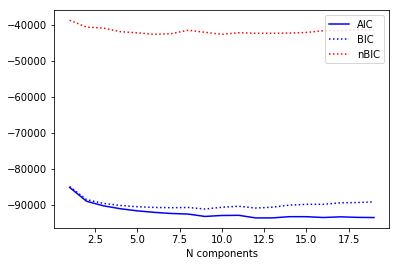

In [16]:
#Full 8D: MACHO only atm: no absoluting
BHdata=np.loadtxt("/home/mw698/BHB/BH_a2_a4_no_name.m1.dat")
nOCdata=np.loadtxt("/home/mw698/BHB/nBH_a2_a4_no_name.m1.dat")
OCdata=np.loadtxt("/home/mw698/sync/PHOEBE_a2_a4_no_name.m1.dat")
nBHdata=np.concatenate((nOCdata,OCdata))
#nBHdata=np.loadtxt("/home/mw698/BHB/nonBH_a2_a4.dat")
#MACHOdata=np.loadtxt("/home/mw698/Downloads/a_par_list")
# MACHOdata=Table.read("/net/geha/mw698/MACHO/all_MACHO_a_par.dat",format='ascii')
# MACHOHCdata=Table.read("/net/geha/mw698/MACHO/all_MACHO_a_par.hc.dat",format='ascii')
#ASANdata=Table.read("/net/geha/mw698/ASAN/ASAN_a_par.dat",format='ascii')
LINEARdata=Table.read("/net/geha/mw698/LINEAR/all_LINEAR_a_par.dat",format='ascii')
ASASdata=Table.read("/net/geha/mw698/ASAN/all_ASAS_a_par.dat",format='ascii')
STRIPE82data=Table.read("/net/geha/mw698/STRIPE82/all_STRIPE82_a_par.dat",format='ascii')
X=np.array([[line[0],line[1],line[2],line[3],line[4],line[5],line[6],line[7]] for line in BHdata])
Y=np.array([[line[0],line[1],line[2],line[3],line[4],line[5],line[6],line[7]] for line in nBHdata])
#ASAN=[[line[0],abs(line[1]),line[2],abs(line[3]),line[4]] for line in ASANdata]
#LINEAR=[[str(line[0]),abs(line[1]),line[2],abs(line[3]),line[4]] for line in LINEARdata]
#STRIPE82=[[str(line[0]),abs(line[1]),line[2],abs(line[3]),line[4]] for line in STRIPE82data]
LINEAR=[[str(line[0]),line[1],line[2],line[3],line[4],line[5],line[6],line[7],line[8]] for line in LINEARdata]
ASAS=[[str(line[0]),line[1],line[2],line[3],line[4],line[5],line[6],line[7],line[8]] for line in ASASdata]
STRIPE82=[[str(line[0]),line[1],line[2],line[3],line[4],line[5],line[6],line[7],line[8]] for line in STRIPE82data]
# MACHO=[[str(line[0]),line[1],line[2],line[3],line[4],line[5],line[6],line[7],line[8]] for line in MACHOdata]
# MACHOHC=[[str(line[0]),line[1],line[2],line[3],line[4],line[5],line[6],line[7],line[8]] for line in MACHOHCdata]

N=np.arange(1,20) #normally goes 1->30

models = compute_GMM(N,MP=False,data=X,irand=300, n_iter=10000) #normally irand=3, and n_iter is not set
nmodels= compute_GMM(N,MP=False,data=Y,irand=300, n_iter=10000) #normally irand=3

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

nBIC= [m.bic(Y) for m in nmodels]

i_best = np.argmin(BIC)
gmm_best = models[i_best]

ni_best= np.argmin(nBIC)
ngmm_best= nmodels[ni_best]
print "gmm best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]
print "ngmm best fit converged:", ngmm_best.converged_
print "BIC: n_components =  %i" % N[ni_best]

plt.plot(N, AIC, '-b', label='AIC')
plt.plot(N, BIC, ':b', label='BIC')
#plt.plot(N, AIC, '-r', label='nAIC')
plt.plot(N, nBIC, ':r', label='nBIC')
plt.legend(loc=1)
plt.xlabel('N components')

plt.show()

81:	 p(BH)=14.8081, p(nBH)=17.1994
71:	 p(BH)=-137.289, p(nBH)=-64.1044
158:	 p(BH)=-8.00222, p(nBH)=10.6883
163:	 p(BH)=-37.8246, p(nBH)=-7.95856
V4641:	 p(BH)=-115.277, p(nBH)=-14.5076
104.20122.323:	 p(BH)=10.7051, p(nBH)=14.425
311.37564.394:	 p(BH)=-13.948, p(nBH)=33.5975
101.21305.196:	 p(BH)=26.3943, p(nBH)=31.6926
116.24647.644:	 p(BH)=7.39662, p(nBH)=1.46516
111.24393.1888:	 p(BH)=-320.72, p(nBH)=-350.275


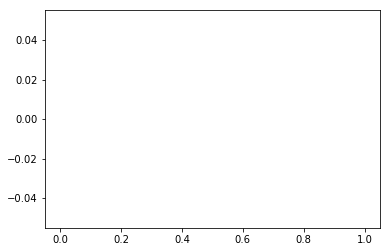

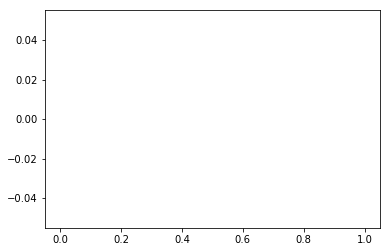

(['116.24647.644'], ['116.24647.644'])


In [13]:
#find probabilities of individual LCs
params=np.array([['81',1.00383616e-03,1.13361816e-01,  -4.11690189e-03,  -1.47034661e-02,\
        -3.93595574e-03,   1.99491455e-03,  -1.04949681e-03,   1.04644488e-03],
                ['71',-2.52166839e-02,   4.12390304e-02,   2.02821731e-03,  -3.10993175e-03,\
                 -7.17190124e-04,   1.54987282e-02,   5.38651317e-04,  -5.90697332e-03],
                ['158',  8.04123661e-04,   2.28698022e-02,  -4.76780363e-03,   3.28600242e-03,\
                 9.66182053e-04,  -6.96594736e-03,   2.43390408e-03,   2.63825894e-03],
                ['163',  6.07820062e-03,   4.47756497e-02,  -2.72052888e-03,   4.01017560e-03,\
                 -8.08969935e-03,  -5.57829793e-03,   3.60825054e-03,   2.33132369e-04],
                ['V4641',0.063388, 0.165628, 0.031462, 0.022362, 0.009440, 0.005986, -0.002405, -0.006135],
                MACHO[1455],
                MACHO[32231],
                MACHO[107],
                MACHO[5378],
                MACHO[4026]])
k,_=foo2(params,gmm_best,tol=1.1,nmodel=ngmm_best,iprint=True)
k2,_=foo2(params,gmm_best,tol=1.1,nmodel=ngmm_best,selcrit=2)
print(k,k2)

In [10]:
#find MACHO index
for i in range(len(MACHO)):
    if MACHO[i][0]=='111.24393.1888':
        print(i)
        print(MACHO[i])

4026
['111.24393.1888', 0.017711999999999999, 0.13728099999999999, 0.026773999999999999, 0.004261, 0.010034, 0.024022000000000002, 0.0035130000000000001, -0.015657999999999998]


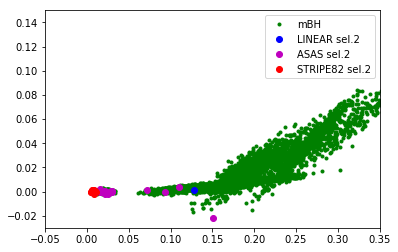

1 LINEAR keys Method 2
['13290819']
19 ASAS keys Method 2
['150903+0512.1', '070100+1003.8', '180042+0308.9', '034852+1142.6', '071800+1544.5', '035357+0902.0', '034328+0109.1', '004128+1859.1', '052843-0302.9', '202553+0126.1', '044955-0228.6', '125534+2553.6', '053121-0158.9', '205719+0548.9', '123745+1534.6', '061828+1116.3', '052303+1357.8', '070547+0742.1', '192231+1649.2']
14 STRIPE82 keys Method 2
['4887050', '403187', '1784177', '3867875', '2318205', '5005168', '3347551', '2805898', '2919846', '2647980', '2995428', '620196', '5010941', '2655939']


In [20]:
#select objects

tol=2.5
m,l=gmm_best.sample(5000)
#m,l=ngmm_best.sample(5000)
#MACHOkeys, MACHOsel=foo2(MACHO,gmm_best,tol=0.0,nmodel=ngmm_best,ntol=-0.0)
#MACHOkeys, MACHOsel=foo2(MACHO,gmm_best,tol=3.5,nmodel=ngmm_best,ntol=3.5,selcrit=3)
#MACHOkeys2, MACHOsel2=foo2(MACHO,gmm_best,tol=1.3,nmodel=ngmm_best,selcrit=2) #normally tol=1.5
LINEARkeys2, LINEARsel2=foo2(LINEAR,gmm_best,tol=1.1,nmodel=ngmm_best,selcrit=2) #normally tol=1.5
ASASkeys2, ASASsel2=foo2(ASAS,gmm_best,tol=1.1,nmodel=ngmm_best,selcrit=2) #normally tol=1.5
STRIPE82keys2, STRIPE82sel2=foo2(STRIPE82,gmm_best,tol=1.1,nmodel=ngmm_best,selcrit=2) #normally tol=1.5

# MACHOHCkeys, MACHOHCsel=foo2(MACHOHC,gmm_best,tol=2.5,nmodel=ngmm_best)
# MACHOHCkeys2, MACHOHCsel2=foo2(MACHOHC,gmm_best,tol=2.5,nmodel=ngmm_best,selcrit=2)

# for k,mu in zip(MACHOkeys,MACHOsel):
#     if mu[1]>0.15:
#         print(k)

plt.plot(m[:,1],m[:,3],'g.',label='mBH')
#plt.plot(MACHOsel2[:,1],MACHOsel2[:,3],'bo',label='MACHO sel.2')
plt.plot(LINEARsel2[:,1],LINEARsel2[:,3],'bo',label='LINEAR sel.2')
plt.plot(ASASsel2[:,1],ASASsel2[:,3],'mo',label='ASAS sel.2')
plt.plot(STRIPE82sel2[:,1],STRIPE82sel2[:,3],'ro',label='STRIPE82 sel.2')
#plt.plot(MACHOsel[:,1],MACHOsel[:,3],'mo',label='MACHO sel.')
# plt.plot(MACHOHCsel2[:,1],MACHOHCsel2[:,3],'ro',label='MACHO-HC sel.2')
# plt.plot(MACHOHCsel[:,1],MACHOHCsel[:,3],'ko',label='MACHO-HC sel.')
plt.legend()
plt.xlim(-0.05,0.35)
plt.ylim(-0.03,0.15)
plt.show()

# if '160.27050.11' in MACHOkeys:
#     print ('V4641 in MACHOkeys')
# if '160.27050.11' in MACHOkeys2:
#     print ('V4641 in MACHOkeys2')
# if '160.27050.11' in MACHOHCkeys:
#     print ('V4641 in MACHOHCkeys')
# if '160.27050.11' in MACHOHCkeys2:
#     print ('V4641 in MACHOHCkeys2')

# both=np.intersect1d(MACHOkeys,MACHOkeys2)
# print("%g MACHO keys both"%len(both))
# print(both)

# lMk=len(MACHOkeys)
# lMk2=len(MACHOkeys2)
lLk2=len(LINEARkeys2)
lAk2=len(ASASkeys2)
lSk2=len(STRIPE82keys2)
# lMHCk=len(MACHOHCkeys)
# lMHCk2=len(MACHOHCkeys2)
# print("%g MACHO keys Method 1"%lMk)
# print(MACHOkeys)
# print("%g MACHO keys Method 2"%lMk2)
# print(MACHOkeys2)
print("%g LINEAR keys Method 2"%lLk2)
print(LINEARkeys2)
print("%g ASAS keys Method 2"%lAk2)
print(ASASkeys2)
print("%g STRIPE82 keys Method 2"%lSk2)
print(STRIPE82keys2)
# print("%g MACHO-HC keys Method 1"%lMHCk)
# print(MACHOHCkeys)
# print("%g MACHO-HC keys Method 2"%lMHCk2)
# print(MACHOHCkeys2)

In [5]:
#create intersection lists
def intersect(lol):
    llol=len(lol)
    if llol==1:
        out=lol[0]
    else:
        out=np.intersect1d(lol[0],lol[1])
        for i in range(2,llol):
            out=np.intersect1d(out,lol[i])
    return out

o2=np.array([])
outlists=[MACHOkeys,MACHOkeys2,MACHOHCkeys,MACHOHCkeys2]
#outlists=[[1,2,3,6],[2,3,4],[3,4,5],[3,6]]

for i in range(len(outlists)):
    for j in range(i+1,len(outlists)):
        temp=intersect([outlists[i],outlists[j]])
        o2=np.concatenate((o2,temp))
o2=np.unique(o2)
o2sort=[float(item.split('.')[0]) for item in o2]
io2=np.argsort(o2sort)
o2=o2[io2]
print("Len(o2)=%g"%len(o2))
print(o2)

o22=np.array([])
for i in [0,1]:
    for j in [2,3]:
        temp=intersect([outlists[i],outlists[j]])
        o22=np.concatenate((o22,temp))
o22=np.unique(o22)
o22sort=[float(item.split('.')[0]) for item in o22]
io22=np.argsort(o22sort)
o22=o22[io22]
print("Len(o22)=%g"%len(o22))
print(o22)

o3=np.array([])
for i in range(len(outlists)):
    for j in range(i+1,len(outlists)):
        for k in range(j+1,len(outlists)):
            temp=intersect([outlists[i],outlists[j],outlists[k]])
            o3=np.concatenate((o3,temp))
o3=np.unique(o3)
o3sort=[float(item.split('.')[0]) for item in o3]
io3=np.argsort(o3sort)
o3=o3[io3]
print('len(o3)=%g'%len(o3))
print(o3)

o4=np.array([])
for i in range(len(outlists)):
    for j in range(i+1,len(outlists)):
        for k in range(j+1,len(outlists)):
            for l in range(k+1,len(outlists)):
                temp=intersect([outlists[i],outlists[j],outlists[k],outlists[l]])
                o4=np.concatenate((o4,temp))
o4=np.unique(o4)
o4sort=[float(item.split('.')[0]) for item in o4]
io4=np.argsort(o4sort)
o4=o4[io4]
print('len(o4)=%g'%len(o4))
print(o4)

NameError: name 'MACHOHCkeys' is not defined

('102.23765.2965', 2.0491156861656066)
('103.24419.1300', 2.4863888096810371)
('105.21167.8619', 2.0689368496547305)
('105.22070.718', 4.1616610438104935)
('109.20379.845', 2.1793531655146041)
('111.23492.5825', 5.7440241859488017)
('111.24270.463', 24.549870285178372)
('111.24393.1888', 2.9082652961871145)
('111.24142.1326', 11.784200456271764)
('114.20884.1585', 4.2299584558319028)
('115.22832.3216', 9.43184285276606)
('119.20486.887', 2.5201757479723734)
('120.21783.4369', 3.9637468153974513)
('121.22169.436', 3.2062872453057749)
('124.22150.3563', 2.7025724138401999)
('125.23585.3808', 1.6771963158792793)
('134.33381.3467', 11.69731025777239)
('136.27651.2866', 2.0681192655290404)
('140.33381.129', 17.200019142908808)
('142.28031.868', 4.3439220133052023)
('142.28681.279', 2.7159884699237598)
('146.28418.1650', 4.5262753351203298)
('147.31668.382', 5.5535964874678445)
('148.25680.171', 46.301283874651965)
('149.26973.6111', 3.7843378375369587)
('149.27368.1818', 2.3218334971265602)

(array([ 74.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  6.33293725e-01,   1.29111231e+03,   2.58159134e+03,
          3.87207036e+03,   5.16254938e+03,   6.45302840e+03,
          7.74350742e+03,   9.03398644e+03,   1.03244655e+04,
          1.16149445e+04,   1.29054235e+04]),
 <a list of 10 Patch objects>)

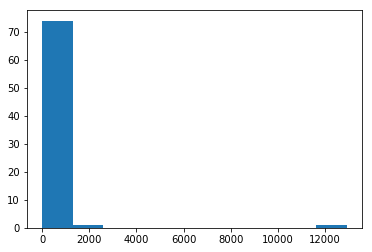

In [8]:
#calculate chi2

def load_obj(name, direc='obj/' ):
    with open(direc + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def Multifunc(order):
    def func(x, *a):
        out= 0
        for i in range(order):
            out += a[i]*np.cos(2*(i+1)*np.pi*x)
        for i in range(order,2*order):
            out += a[i]*np.sin(2*(i+1-order)*np.pi*x)
        out += a[2*order]
        return out
    return func

forder=4
func=Multifunc(forder)
p0=tuple(1 for i in range(2*forder+1))

chivals=[]
        
for key in MACHOkeys2:
    fnum=key.split('.')[0]
    #MACHO_obj_dict=load_obj('all_lc_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    MACHO_period_dict=load_obj('lc_periods_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    tol=1
    data=openMACHO(key)
    period=MACHO_period_dict[key]
    itrimmed=[]
    mean=np.mean(data[1])
    stdev=np.std(data[1])
    for i,val in enumerate(data[2]):
        if 0<val<0.2 and abs(data[1][i]-mean)<3*stdev:
            itrimmed.append(i)
    tMJD=data[0][itrimmed]
    tmag=data[1][itrimmed]
    terr=data[2][itrimmed]

    phase=(tMJD/period)%1
    mu,cov=curve_fit(func,phase,tmag,p0,terr)
    
    chi2=0
    for p,m,e in zip(phase,tmag,terr):
        chi2+=(m-func(p,*mu))**2/e**2/(len(phase)-9)
    print(key,chi2)
    chivals.append(chi2)
plt.hist(chivals)

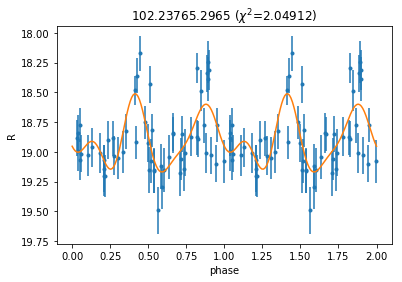

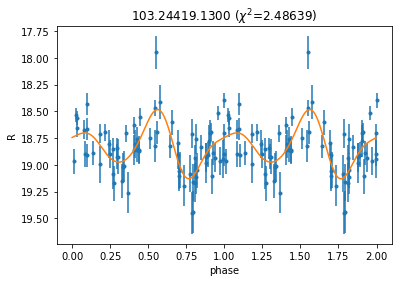

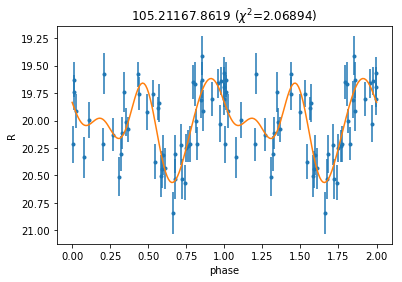

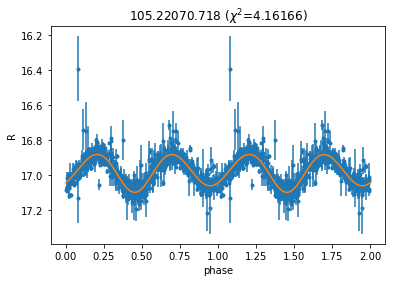

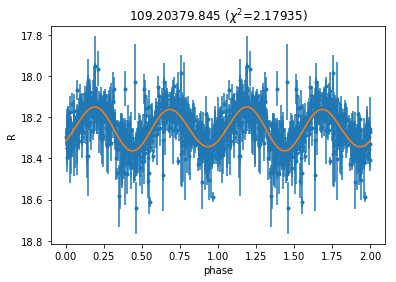

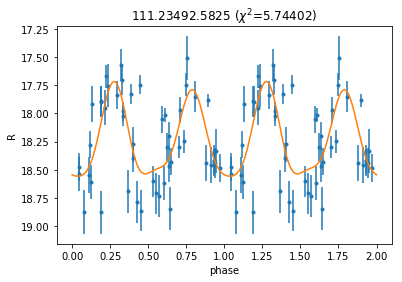

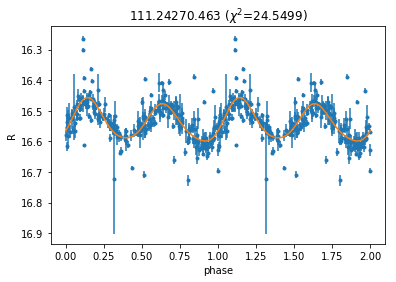

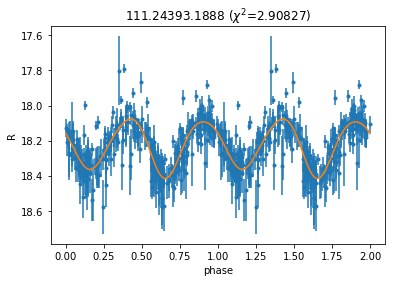

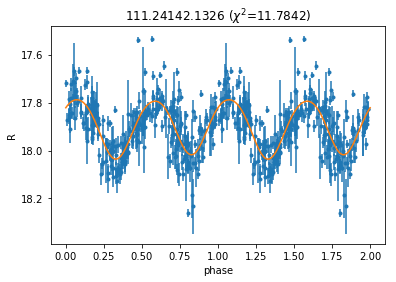

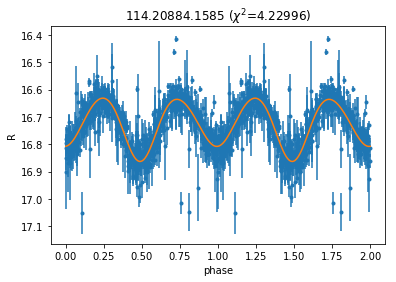

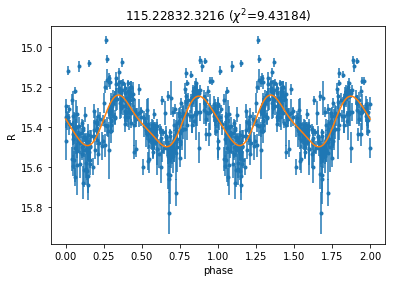

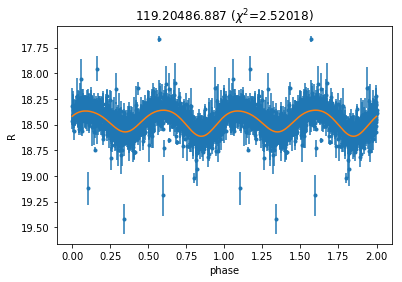

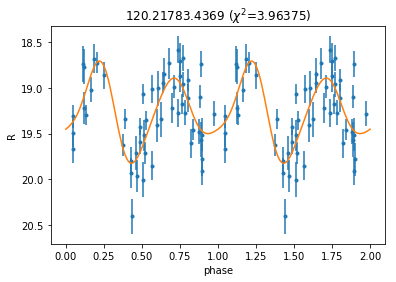

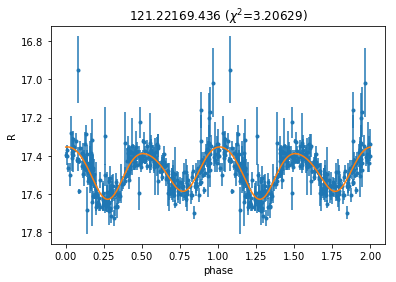

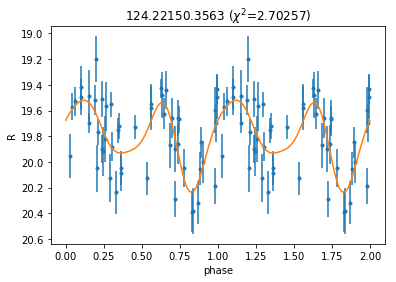

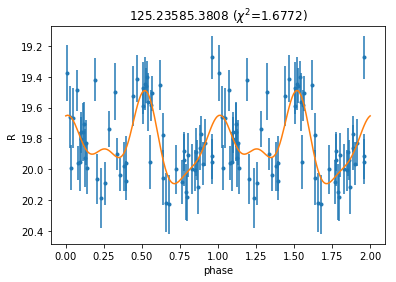

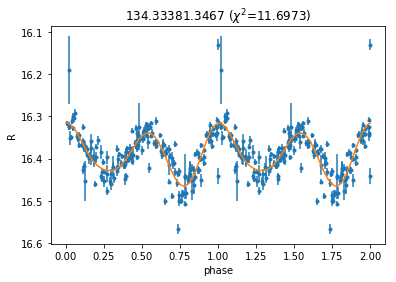

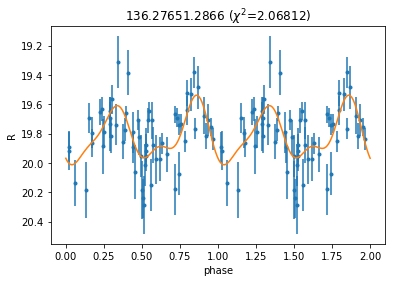

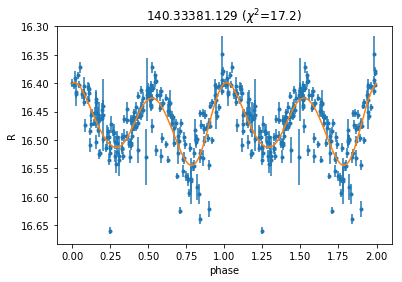

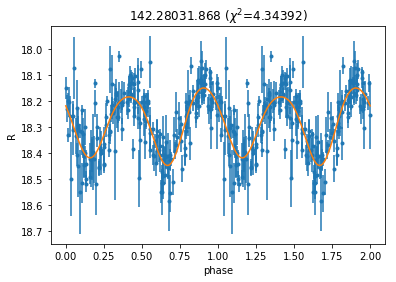

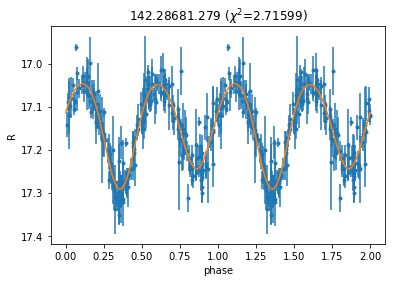

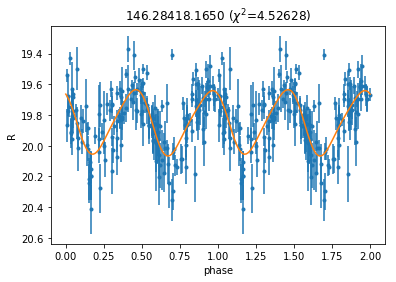

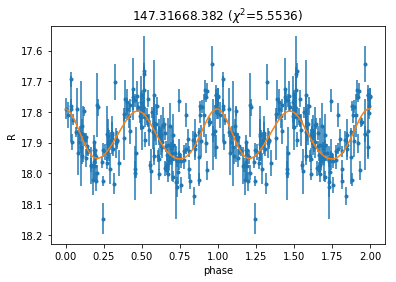

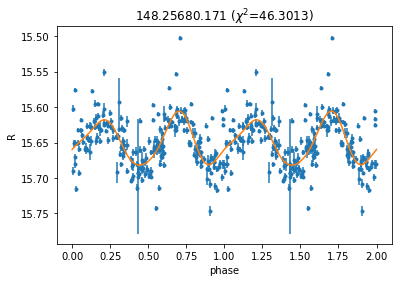

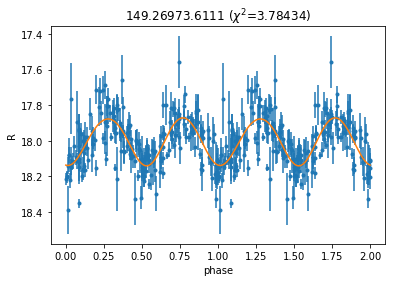

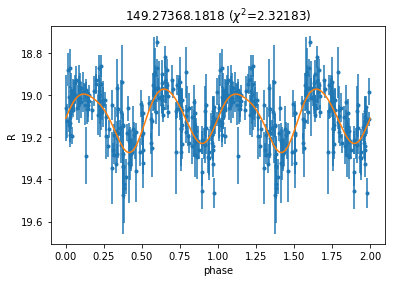

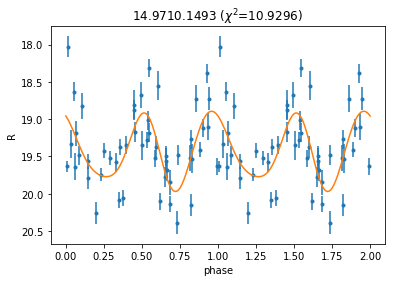

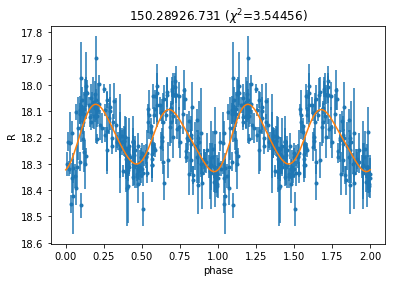

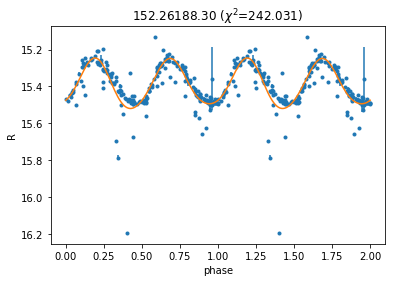

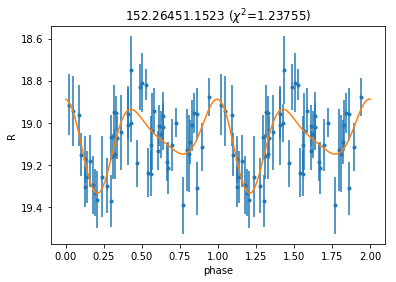

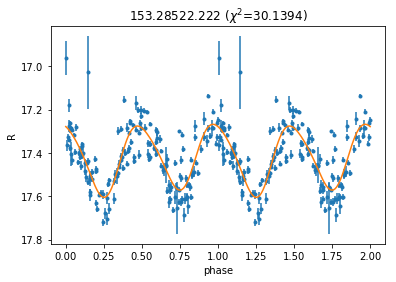

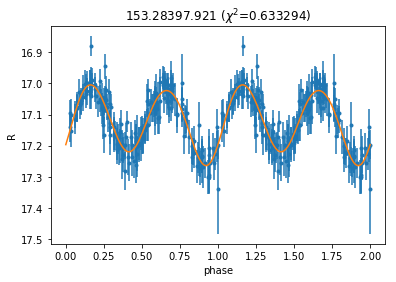

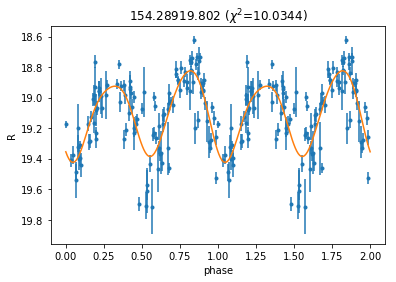

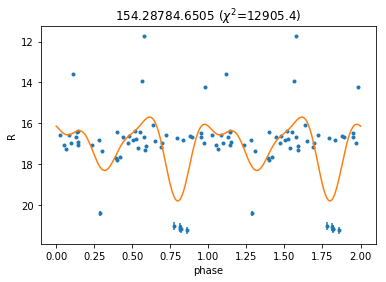

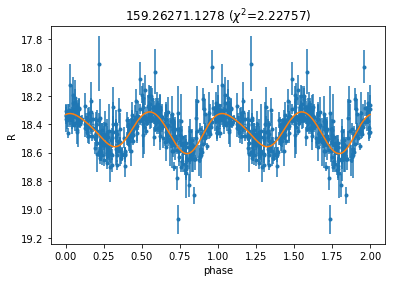

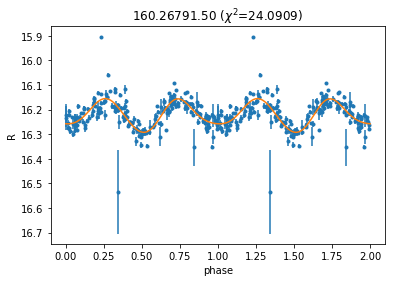

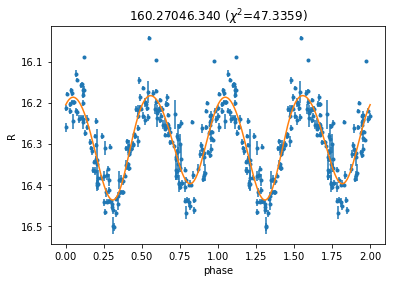

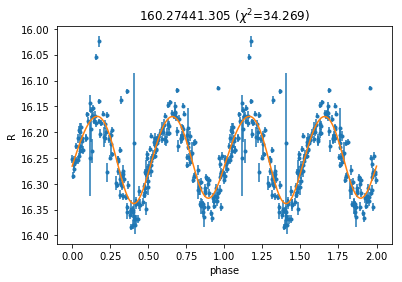

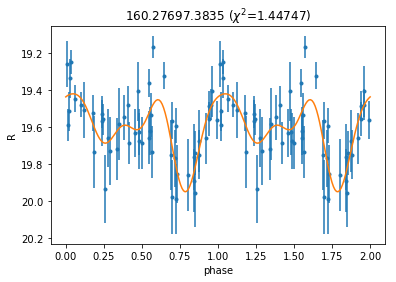

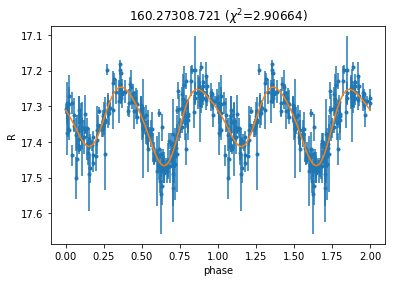

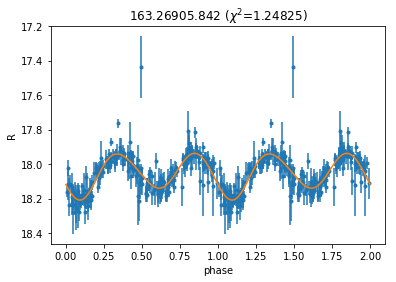

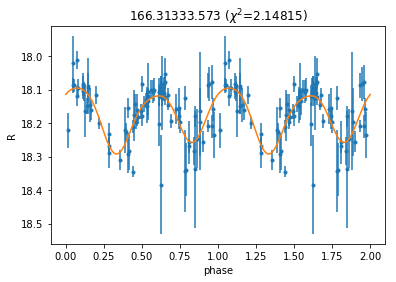

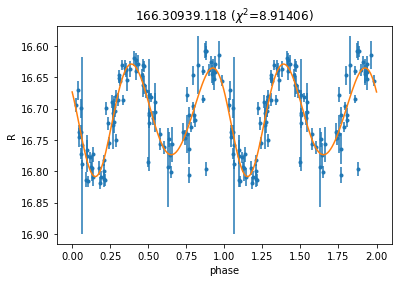

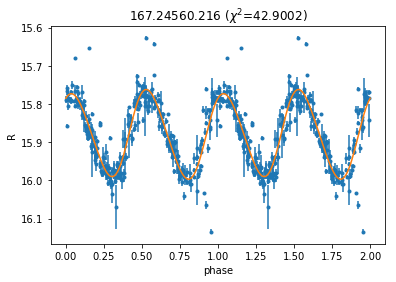

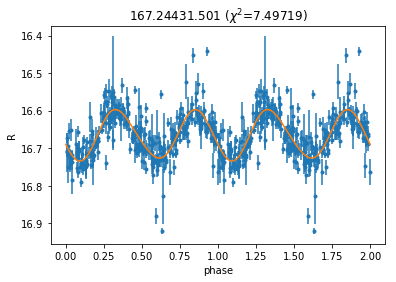

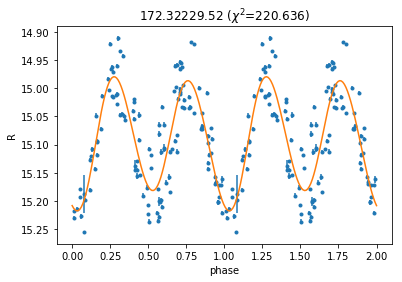

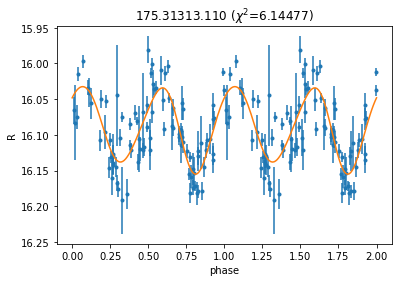

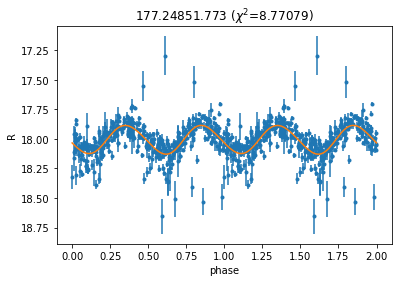

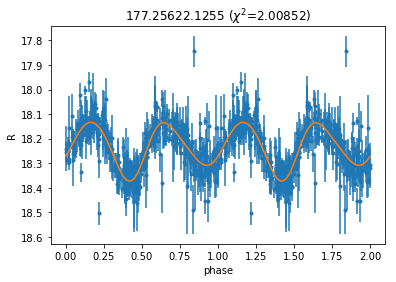

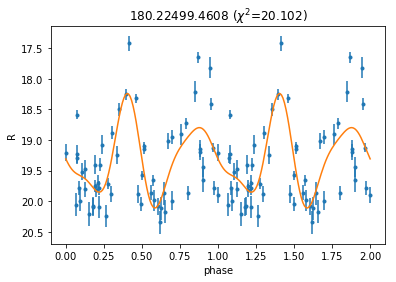

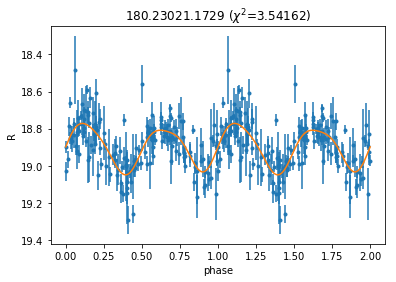

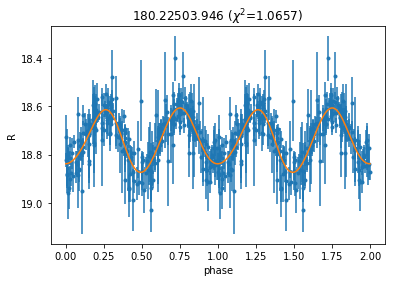

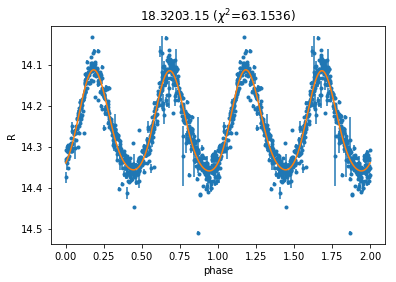

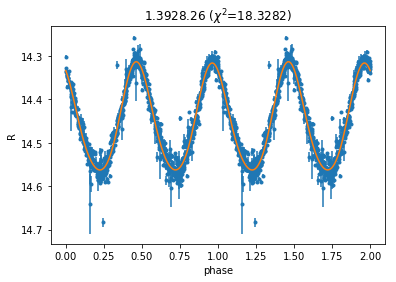

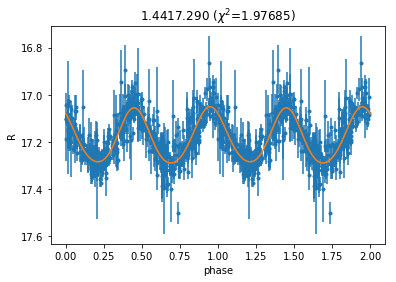

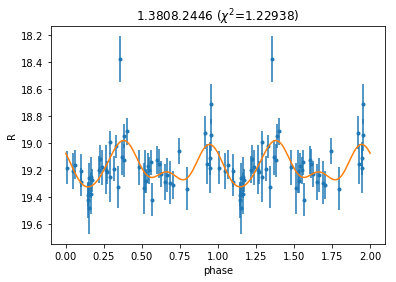

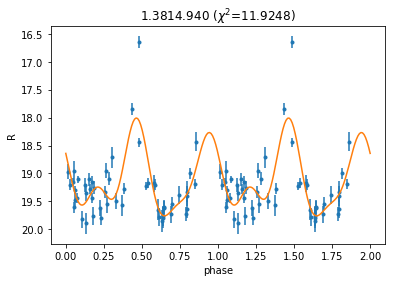

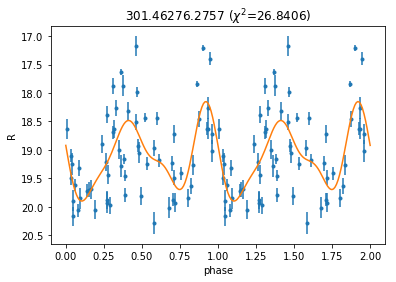

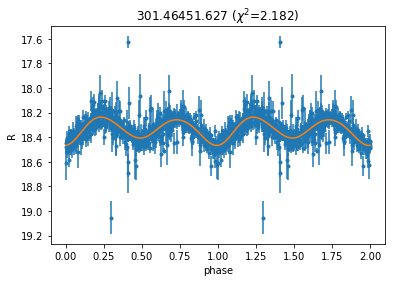

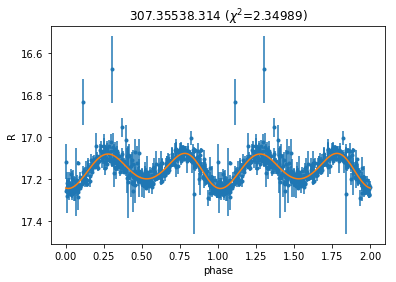

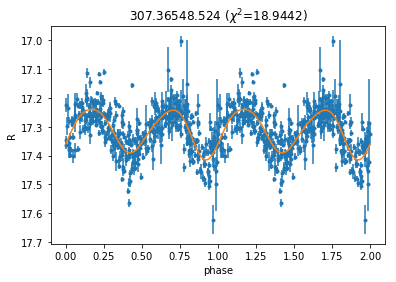

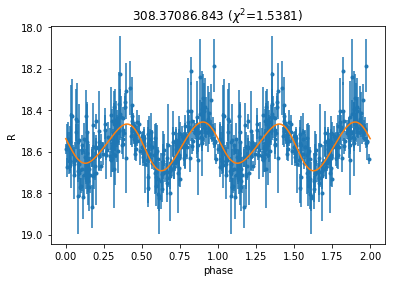

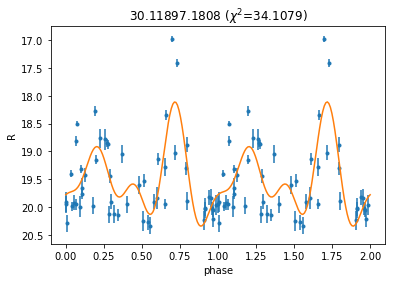

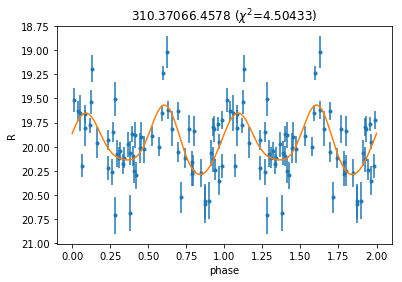

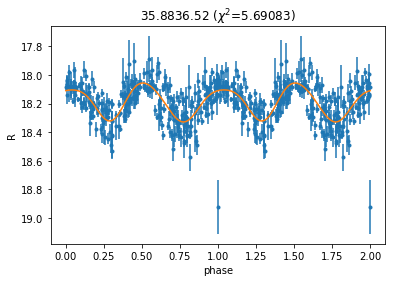

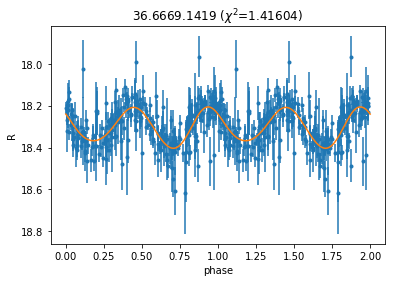

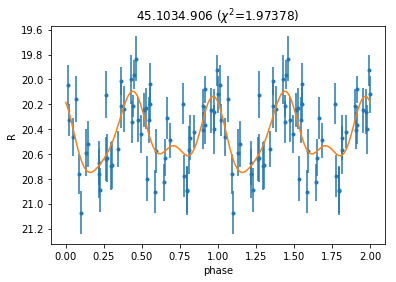

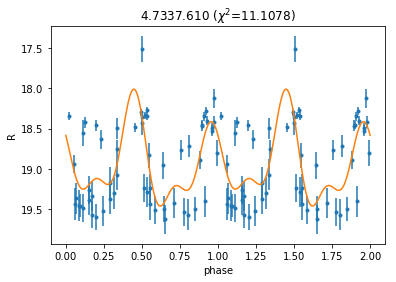

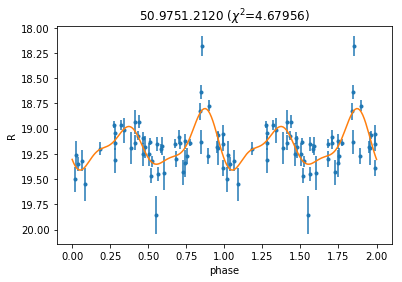

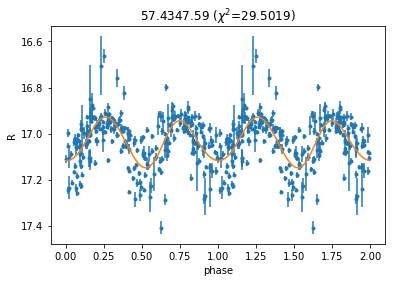

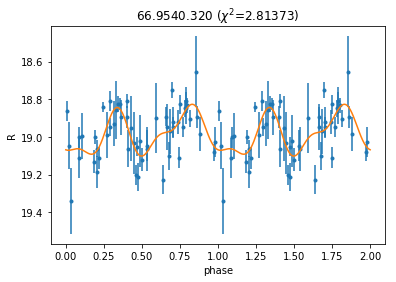

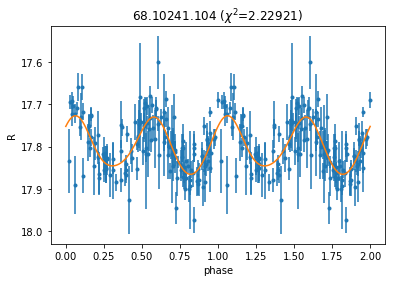

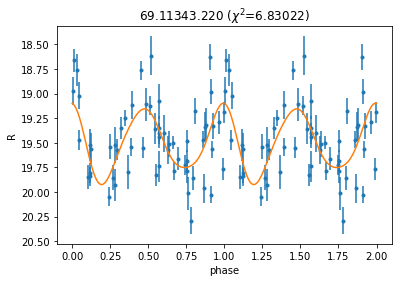

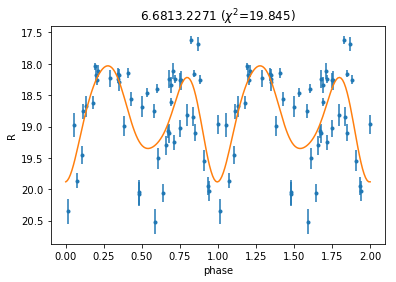

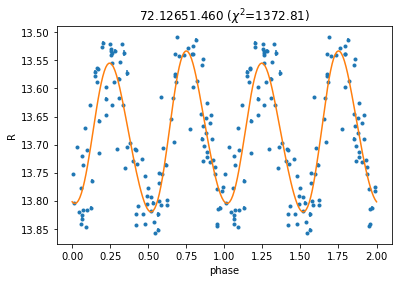

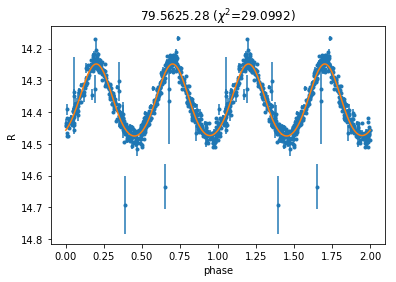

In [9]:
#plot and save LCs

def load_obj(name, direc='obj/' ):
    with open(direc + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def Multifunc(order):
    def func(x, *a):
        out= 0
        for i in range(order):
            out += a[i]*np.cos(2*(i+1)*np.pi*x)
        for i in range(order,2*order):
            out += a[i]*np.sin(2*(i+1-order)*np.pi*x)
        out += a[2*order]
        return out
    return func

def chain4(x,y,z=None,dl=0.1,sort=True):
    '''
    Drop a chain starting at the maximum assuming a max chain length.
    
    Params:
    x: phase data
    y: mag data
    z: error data
    dl: chain length
    sort: is the data pre-sorted in phase-space?
    '''
    if z is None:
        zz=np.full(len(x),-99)
    else:
        zz=z
    xc=np.array([])
    yc=np.array([])
    zc=np.array([])
    if sort:
        isort=np.argsort(x)
        x=x[isort]
        y=y[isort]
        if z is not None:
            zz=zz[isort]
    imax=np.argmax(y)
    icent=imax
    xcoor=x[icent]
    ycoor=y[icent]
    zcoor=zz[icent]
    ymin=np.min(y)
    ymax=np.max(y)
    xc=np.append(xc,xcoor)
    yc=np.append(yc,ycoor)
    zc=np.append(zc,zcoor)
    #right chain
    while True:
        idl=1
        while True:
            slopes=[]
            islopes=[]
            for i in range(icent+1,len(x)):
                if (x[i]-xcoor)>idl*dl:
                    break
                else:
                    yiNorm=(y[i]-ymin)/(ymax-ymin)
                    ycNorm=(ycoor-ymin)/(ymax-ymin)
                    if (x[i]-xcoor)**2+(y[i]-ycoor)**2<=(idl*dl)**2:
                        slopes.append((y[i]-ycoor)/(x[i]-xcoor))
                        islopes.append(i)
            if len(slopes)>0:
                break
            else:
                idl+=1
                if idl>1000:
                    print('idl>100, icent=%g, i*dl=%g'%(icent,idl*dl))
                    return (xc,yc) if z is None else (xc,yc,zc)
        icent=islopes[np.argmax(slopes)]
        xcoor=x[icent]
        ycoor=y[icent]
        zcoor=zz[icent]
        xc=np.append(xc,xcoor)
        yc=np.append(yc,ycoor)
        zc=np.append(zc,zcoor)
        if xcoor==x[-1]:
            break
            
    #left chain
    icent=imax
    xcoor=x[icent]
    ycoor=y[icent]
    zcoor=z[icent]
    while True:
        idl=1
        while True:
            slopes=[]
            islopes=[]
            for i in range(icent-1,0,-1):
                if (xcoor-x[i])>idl*dl:
                    break
                else:
                    yiNorm=(y[i]-ymin)/(ymax-ymin)
                    ycNorm=(ycoor-ymin)/(ymax-ymin)
                    if (x[i]-xcoor)**2+(y[i]-ycoor)**2<=(idl*dl)**2:
                        slopes.append((y[i]-ycoor)/(x[i]-xcoor))
                        islopes.append(i)
            if len(slopes)>0:
                break
            else:
                idl+=1
                if idl>1000:
                    print('idl>1000, icent=%g, i*dl=%g'%(icent,idl*dl))
                    return (xc,yc) if z is None else (xc,yc,zc)
        icent=islopes[np.argmin(slopes)]
        if icent==1: break
        xcoor=x[icent]
        ycoor=y[icent]
        zcoor=z[icent]
        xc=np.insert(xc,0,xcoor)
        yc=np.insert(yc,0,ycoor)
        zc=np.insert(zc,0,zcoor)
            
    return (xc,yc) if z is None else (xc,yc,zc)

def double(x,y,z):
    xout=np.concatenate((x,x+1))
    yout=np.concatenate((y,y))
    zout=np.concatenate((z,z))
    return xout,yout,zout

forder=4
func=Multifunc(forder)
p0=tuple(1 for i in range(2*forder+1))
fitphases=np.linspace(0,2,200)
        
#for key in o3:
#for key in o22:
for ii,key in enumerate(MACHOkeys2):
    fnum=key.split('.')[0]
#     MACHO_obj_dict=load_obj('all_lc_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    MACHO_period_dict=load_obj('lc_periods_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    rawfile=open("/net/geha/mgeha/MACHO/F_%s/%s"%(fnum,key))
    rawlines=rawfile.readlines()
    headerlines=rawlines[:9]
    header=[line.split() for line in headerlines]

    r=float(header[6][2])
    b=float(header[7][2])
    color=b-r if b!=-99 else 0

    tol=1
    data=openMACHO(key)
    period=MACHO_period_dict[key]
    itrimmed=[]
    mean=np.mean(data[1])
    stdev=np.std(data[1])
    for i,val in enumerate(data[2]):
        if 0<val<0.2 and abs(data[1][i]-mean)<3*stdev:
            itrimmed.append(i)
    tMJD=data[0][itrimmed]
    tmag=data[1][itrimmed]
    terr=data[2][itrimmed]

    #for this plot, we only fit to the data less than 3 sigma away
    phase=(tMJD/period)%1
    tmag=tmag+23.41+0.18*(color) #convert from MACHO r to R
    
    isort=np.argsort(phase)
    x=phase[isort]
    y=tmag[isort]
    z=terr[isort]
#     sep=x[1:]-x[:-1]
#     dl=np.median(sep)
#     #print(10*dl)
#     xc,yc,zc=chain4(x,y,z,dl=0.05,sort=False) #normally dl=10*dl

#     mu,cov=curve_fit(func,xc,yc,sigma=zc,p0=p0)
#     fit=[func(xx,*mu) for xx in fitphases]

    mu2,cov2=curve_fit(func,x,y,z)
    fit2=[func(xx,*mu2) for xx in fitphases]

    x,y,z=double(x,y,z)
#     xc,yc,zc=double(xc,yc,zc)

    plt.errorbar(x,y,z,fmt='.')
#     plt.errorbar(xc,yc,zc,fmt='o-')
#     plt.plot(fitphases,fit)
    plt.plot(fitphases,fit2,zorder=5)
    plt.xlabel('phase')
    plt.ylabel('R')
    #plt.xlim(0.75,1.05)
    ax=plt.gca()
    # for x,y,idl in zip(xc[1:],yc[1:],il):
    #     ax.add_patch(Circle(xy=(x,y), radius=(idl*10*dl),fc='r',alpha=0.2,ec='k'))
    plt.ylim(reversed(plt.ylim()))
    plt.title(r'%s ($\chi^2$=%g)'%(key,chivals[ii]))
    #plt.axes().set_aspect('equal', 'datalim')
    #plt.savefig("/home/mw698/BHB/MACHO_cand/MACHO_v4_%s.pdf"%key,format='pdf')
    plt.show()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  33.]),
 array([-93.609 , -84.0829, -74.5568, -65.0307, -55.5046, -45.9785,
        -36.4524, -26.9263, -17.4002,  -7.8741,   1.652 ]),
 <a list of 10 Patch objects>)

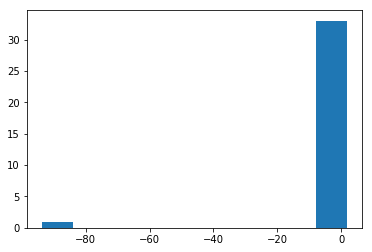

In [26]:
#make .info file
def load_obj(name, direc='obj/' ):
    with open(direc + name + '.pkl', 'rb') as f:
        return pickle.load(f)

chist=[]
infofile=open("/home/mw698/BHB/MACHO_cand/MACHO_v4_BEST.info",'w+')
infofile.write("#key\tRA\tDEC\tlocation\tR\tb-r\tP (days)\n")
#for LC in o3: use o3 for MACHO_BEST
for LC in MACHOkeys2:
    fnum=LC.split('.')[0]
    os.chdir("/net/geha/mgeha/MACHO/F_%s"%fnum)
    rawfile=open(LC)
    rawlines=rawfile.readlines()
    headerlines=rawlines[:9]
    header=[line.split() for line in headerlines]
    rawRA=header[0][4:7]
    RA=rawRA[0]+':'+rawRA[1]+':'+rawRA[2]
    rawDEC=header[0][8:11]
    DEC=rawDEC[0]+':'+rawDEC[1]+':'+rawDEC[2]
    r=float(header[6][2])
    b=float(header[7][2])
    b=b
    color=b-r
    chist.append(color)
    R=r+23.41+0.18*(color)
    if float(fnum)<100:
        loc='LMC'
    elif 201<=float(fnum)<=299:
        loc='SMC'
    else:
        loc='bulge'
    MACHO_period_dict=load_obj('lc_periods_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    period=MACHO_period_dict[LC]
    if b!=-99:
        infofile.write('%s\t%s\t%s\t%s\t%.4g\t%.4g\t%.4g\n'%(LC,RA,DEC,loc,R,color,period))
    else:
        R=r+23.41
        infofile.write('%s\t%s\t%s\t%s\t%.4g*\t%.4g\t%.4g\n'%(LC,RA,DEC,loc,R,color,period))
infofile.close()
plt.hist(chist)

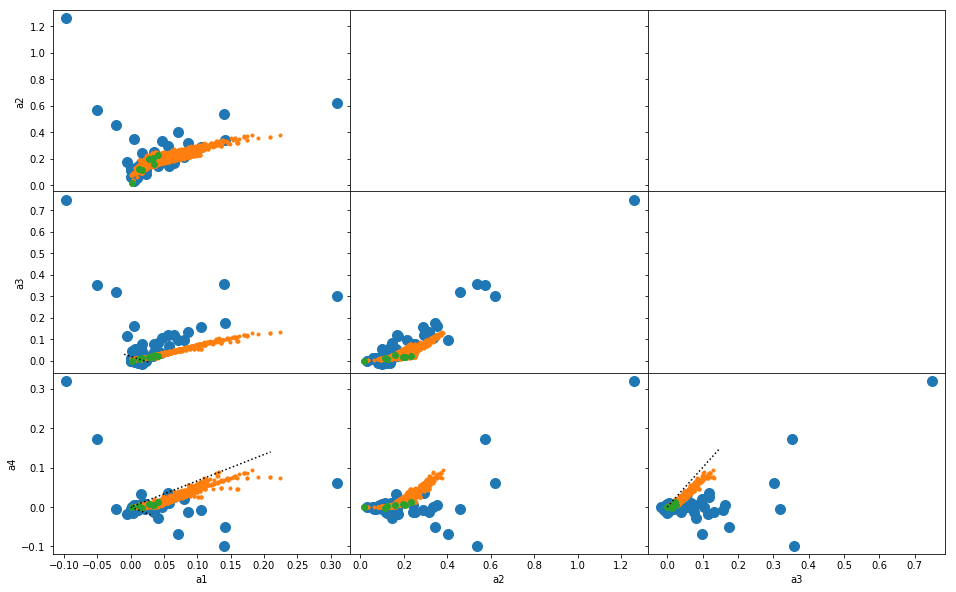

In [6]:
"""
Make Triangle Plot
"""

V4641=[6.62814981e-02,1.66768251e-01,2.75800726e-02,1.62402237e-02]
kBH=np.loadtxt("/home/mw698/BHB/kBH_a2_a4_no_name.m1.dat")

a1=[]
a2=[]
a3=[]
a4=[]
b1=[]
b2=[]
b3=[]
b4=[]
m0=[]
        
    
plab=['a1','a2','a3','a4']#,'b1','b2','b3','b4']

#      a1         a2         a3         a4         b1         b2         b3          b4
#plim=[(-0.3,0.5),(-0.1,0.6),(-0.2,0.5),(-0.2,0.5),(-0.5,0.3),(-0.5,0.5),(-0.2,0.25),(-0.6,0.3)]

nvar=len(plab)

f,ax=plt.subplots(nvar-1,nvar-1,'col','row',figsize=(4*nvar,2.5*nvar))
tol=1

for i in range(nvar):
    for j in range(i+1,nvar):
        cax=ax[j-1][i]
#         x=np.array(plist[i])
#         xp=x[~is_outlier(x)]
#         y=np.array(plist[j])
#         yp=y[~is_outlier(y)]
#         cax.plot(xp,yp,'.')
#         cax.plot(MACHOsel[:,i],MACHOsel[:,j],'o',markersize=10)
        cax.plot(MACHOsel2[:,i],MACHOsel2[:,j],'o',markersize=10)
        cax.plot(BHdata[:,i],BHdata[:,j],'.')
        cax.plot(kBH[:,i],kBH[:,j],'o')
        #cax.plot(nBHdata[:,i],nBHdata[:,j],'.') #UNCOMMENT ME!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#         cax.plot(aRRplist[i],aRRplist[j],'o')
#         cax.plot(RRplist[i],RRplist[j],'o')
#         slope, intercept, r_value, p_value, std_err = linregress(RRplist[i],RRplist[j])
#         #print('%s-%s r-squared: %g'%(plab[i],plab[j],r_value**2))
        
#         aslope, aintercept, ar_value, ap_value, astd_err = linregress(aRRplist[i],aRRplist[j])
#         print('%s-%s r-squared (hand, auto): %g %g'%(plab[i],plab[j],r_value**2,ar_value**2))
#         if r_value**2>0.7:
#             xfit=np.linspace(np.min(plist[i]),np.max(plist[i]),100)
#             cax.plot(xfit,[intercept+slope*x for x in xfit])
#             dmax=-99
#             dmin=99
#             for xx,yy in zip(RRplist[i],RRplist[j]):
#                 d=(slope*xx+intercept-yy)/slope
#                 if d>dmax:
#                     dmax=d
#                     xmax=xx
#                     ymax=yy
#                 if d<dmin:
#                     dmin=d
#                     xmin=xx
#                     ymin=yy
#             imax=np.argmax(RRplist[i])
#             imin=np.argmin(RRplist[i])
#             cax.plot([xmin,xmax,RRplist[i][imin],RRplist[i][imax]],[ymin,ymax,RRplist[j][imin],RRplist[j][imax]],'or')
                    
#         cax.set_xlim(plim[i])
#         cax.set_ylim(plim[j])
#         cax.set_xlim(np.mean(plist[i])-tol*np.std(plist[i]),np.mean(plist[i])+tol*np.std(plist[i]))
#         cax.set_ylim(np.mean(plist[j])-tol*np.std(plist[j]),np.mean(plist[j])+tol*np.std(plist[j]))
        if j==nvar-1:
            cax.set_xlabel(plab[i])
        if i==0:
            cax.set_ylabel(plab[j])
        if i==0:
            if j==3:
                cax.plot([0.03,0,0.21],[-0.02,0,0.14],'k:')
            if j==2:
                cax.plot([-0.01,0.03],[0.03,-0.01],'k:')
        if i==2:
            if j==3:
                cax.plot([0,0.15],[0,0.15],'k:')
        
f.subplots_adjust(hspace=0,wspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()

/home/mw698/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


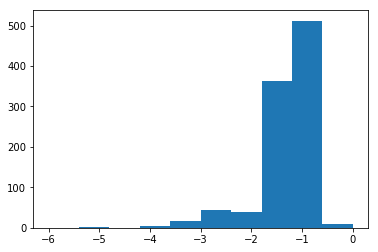

0.018351759999999995

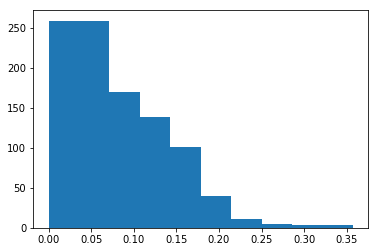

In [63]:
plt.hist(np.log10(BHdata[:,0]+BHdata[:,2]),range=(-6,0))
plt.show()
# for ii,line in enumerate(BHdata):
#     if line[0]+line[2]<1e-3:
#         print(line[0]+line[2],ii,line)
l=BHdata[:,0]+BHdata[:,2]
plt.hist(l)
np.percentile(l,12)

('105.22070.718', array([ 0.01006 ,  0.095213,  0.011433, -0.000397,  0.001415,  0.00697 ,
       -0.001232, -0.003202]))


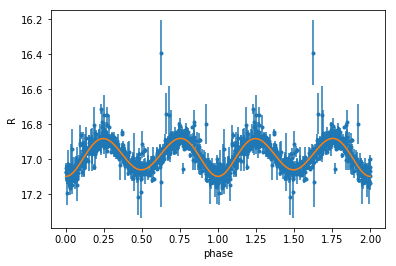

('109.20379.845', array([ 0.008472,  0.098455,  0.010357,  0.001838,  0.007944,  0.001279,
       -0.003651,  0.000132]))


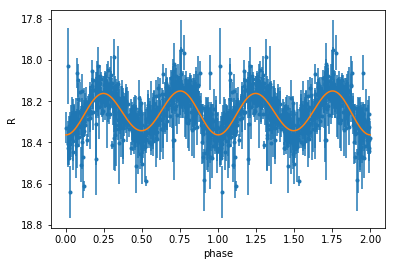

('116.24647.644', array([-0.003876,  0.07532 ,  0.016208,  0.001826, -0.002899, -0.000907,
       -0.004207,  0.004533]))


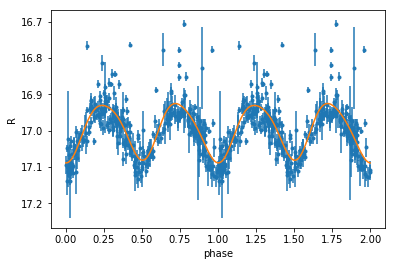

('128.21409.1015', array([ 0.005879,  0.104935,  0.017179,  0.00369 , -0.009181,  0.001819,
        0.001416,  0.000721]))


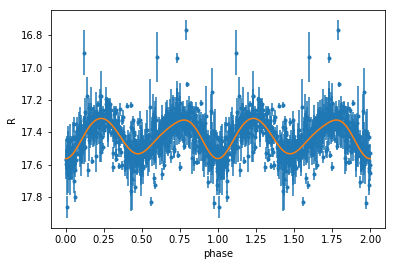

('131.29088.163', array([ 0.008526,  0.055534,  0.008655,  0.000822, -0.007685,  0.000823,
       -0.000171,  0.001776]))


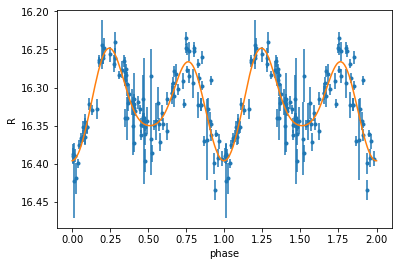

('134.33381.3467', array([ 0.004435,  0.056514,  0.010402,  0.000731, -0.006086,  0.002525,
        0.001809, -0.000649]))


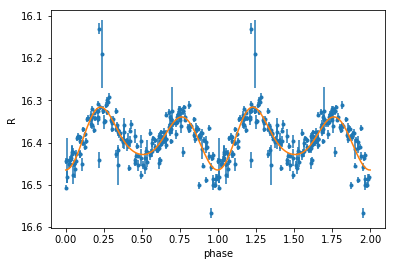

('140.33381.129', array([ 0.009319,  0.05724 ,  0.00695 , -0.002615, -0.007786,  0.000894,
        0.001058,  0.000668]))


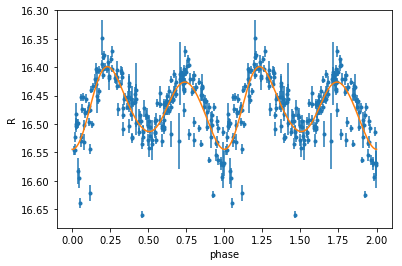

('142.28031.868', array([ 0.017518,  0.125255,  0.010676,  0.003156, -0.00545 , -0.005815,
        0.004027,  0.000883]))


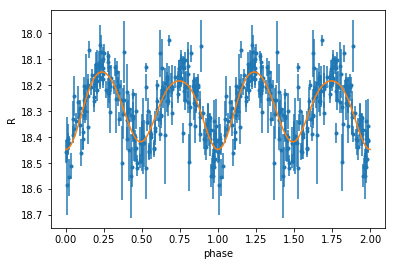

('149.27368.1818', array([ 0.010072,  0.134971,  0.004933,  0.003843, -0.006845, -0.003756,
        0.000218,  0.004224]))


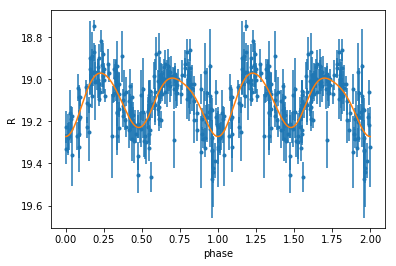

('160.26791.50', array([ 0.006448,  0.064687,  0.012449, -0.002836,  0.003007,  0.004669,
        0.002731, -0.004899]))


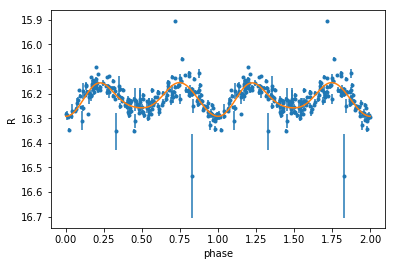

('160.27441.305', array([  5.00700000e-03,   7.95130000e-02,   3.83700000e-03,
         3.20000000e-05,   2.63800000e-03,  -3.20000000e-05,
         5.58100000e-03,  -4.30300000e-03]))


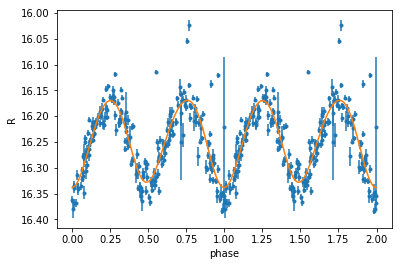

('163.26905.842', array([ 0.019455,  0.118092,  0.014237, -0.002136, -0.003321,  0.003354,
       -0.005865,  0.003051]))


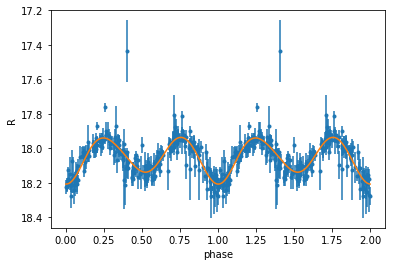

('166.30939.118', array([ 0.00622 ,  0.078685,  0.01476 , -0.000174, -0.005071,  0.005021,
        0.00373 , -0.003552]))


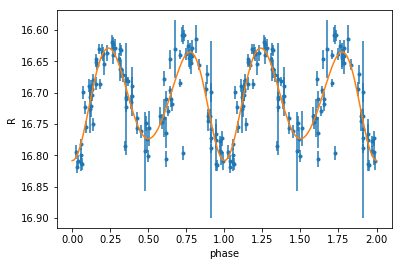

('167.24431.501', array([  1.78300000e-03,   5.88040000e-02,   1.11440000e-02,
         2.20000000e-05,  -5.88700000e-03,   6.75000000e-04,
         1.03300000e-03,   7.45000000e-04]))


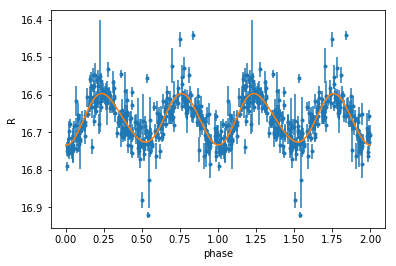

('175.31313.110', array([ 0.006571,  0.061363,  0.010963,  0.000585, -0.006763,  0.001968,
        0.004577, -0.002035]))


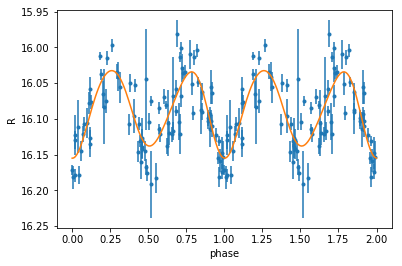

('177.24851.773', array([ 0.00725 ,  0.116814,  0.004132,  0.003894, -0.004859, -0.001712,
       -0.003604,  0.005687]))


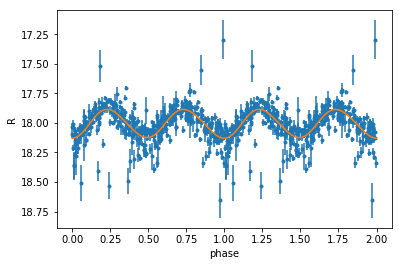

('177.25622.1255', array([ 0.021618,  0.103612,  0.016572, -0.000848, -0.00218 , -0.000539,
       -0.004734,  0.004833]))


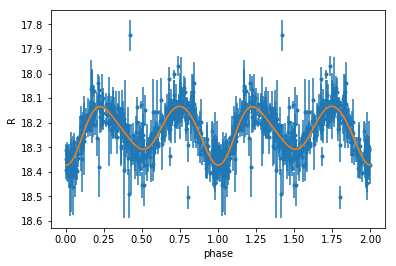

('180.22503.946', array([ 0.006799,  0.116794,  0.007499,  0.001845,  0.005006, -0.000719,
        0.004683, -0.004408]))


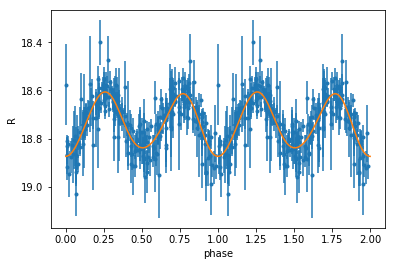

('307.36548.524', array([ 0.007793,  0.079839,  0.008274,  0.00264 , -0.005236,  0.001983,
        0.003574, -0.002229]))


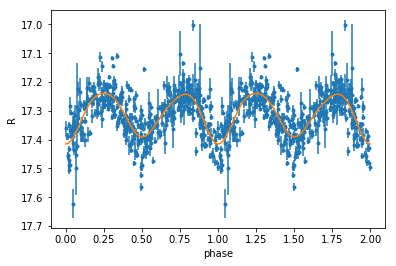

('308.37086.843', array([ 0.007841,  0.093251,  0.012916,  0.002448,  0.000572,  0.00024 ,
        0.00756 , -0.006224]))


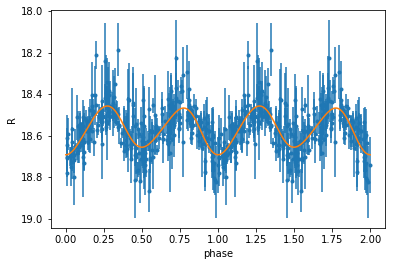

('57.4218.541', array([ 0.043705,  0.133769,  0.02586 ,  0.003046, -0.000145,  0.002992,
       -0.004026,  0.000197]))


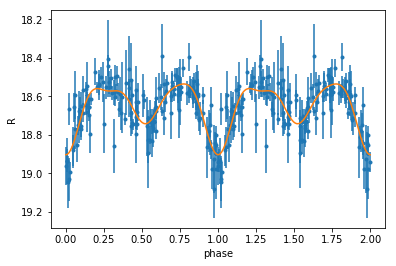

('57.4347.59', array([ 0.009419,  0.085758,  0.007117,  0.002049,  0.001248, -0.004167,
       -0.002885,  0.003716]))


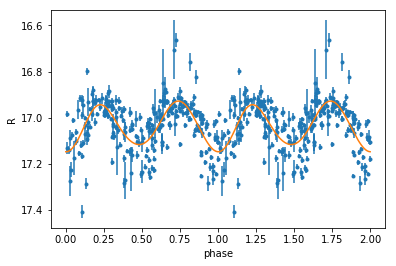

22


In [24]:
def load_obj(name, direc='obj/' ):
    with open(direc + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def Multifunc(order):
    def func(x, *a):
        out= 0
        for i in range(order):
            out += a[i]*np.cos(2*(i+1)*np.pi*x)
        for i in range(order,2*order):
            out += a[i]*np.sin(2*(i+1-order)*np.pi*x)
        out += a[2*order]
        return out
    return func

def double(x,y,z):
    xout=np.concatenate((x,x+1))
    yout=np.concatenate((y,y))
    zout=np.concatenate((z,z))
    return xout,yout,zout

forder=4
func=Multifunc(forder)
p0=tuple(1 for i in range(2*forder+1))
fitphases=np.linspace(0,2,200)

def plot(key):
    fnum=key.split('.')[0]
    #MACHO_obj_dict=load_obj('all_lc_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    MACHO_period_dict=load_obj('lc_periods_MACHO_F_%s'%fnum,direc='/net/geha/mw698/MACHO/')
    rawfile=open("/net/geha/mgeha/MACHO/F_%s/%s"%(fnum,key))
    rawlines=rawfile.readlines()
    headerlines=rawlines[:9]
    header=[line.split() for line in headerlines]

    r=float(header[6][2])
    b=float(header[7][2])
    color=b-r if b!=-99 else 0

    tol=1
    #data=MACHO_obj_dict[key]
    data=openMACHO(key)
    period=MACHO_period_dict[key]
    itrimmed=[]
    mean=np.mean(data[1])
    stdev=np.std(data[1])
    for i,val in enumerate(data[2]):
        if 0<val<0.2 and abs(data[1][i]-mean)<3*stdev:
            itrimmed.append(i)
    tMJD=data[0][itrimmed]
    tmag=data[1][itrimmed]
    terr=data[2][itrimmed]

    #for this plot, we only fit to the data less than 3 sigma away
    phase=(tMJD/period)%1
    tmag=tmag+23.41+0.18*(color) #convert from MACHO r to R
    
    isort=np.argsort(phase)
    x=phase[isort]
    y=tmag[isort]
    z=terr[isort]

    mu2,cov2=curve_fit(func,x,y,z)
    fit2=[func(xx,*mu2) for xx in fitphases]
    phi0=fitphases[np.argmax(fit2)]
    x=(x-phi0)%1
    mu2,cov2=curve_fit(func,x,y,z)
    fit2=[func(xx,*mu2) for xx in fitphases]

    x,y,z=double(x,y,z)

    plt.errorbar(x,y,z,fmt='.')
    plt.plot(fitphases,fit2,zorder=5)
    plt.xlabel('phase')
    plt.ylabel('R')
    #plt.xlim(0.75,1.05)
    ax=plt.gca()
    plt.ylim(reversed(plt.ylim()))
#     plt.title(r'%s ($\chi^2$=%g)'%(key,chivals[ii]))
#     plt.savefig("/home/mw698/BHB/MACHO_cand/MACHO_v2_%s.pdf"%key,format='pdf')
    plt.show()

sel1=2/3. #1/3.
sel2=1.   #1/2.
tol=1.01
ii=0
for key,mu in zip(MACHOkeys2,MACHOsel2):
    if (mu[3]/mu[0]<tol*sel1 and mu[3]/mu[0]>-tol*sel1) or (mu[3]/mu[0]>tol*sel1 and mu[3]/mu[0]<-tol*sel1):
        if (mu[3]/mu[2]<tol*sel2 and mu[3]/mu[2]>-tol*sel2) or (mu[3]/mu[2]>tol*sel2 and mu[3]/mu[2]<-tol*sel2):
            if (mu[0]+mu[2]>0.0002):
                print(key,mu)
                plot(key)
                ii+=1
print(ii)

a1
sim<0
sim>0
MACHO<0
MACHO>0
(-0.22452206912481165, 0.74392650451805775)


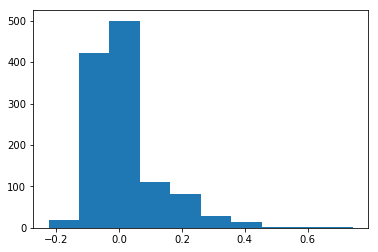

(-0.92552900000000005, 2.882098)


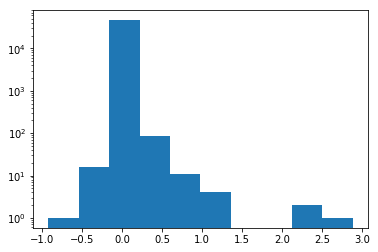

a2
sim<0
sim>0
MACHO<0
MACHO>0
(-6.3469234218733938e-05, 0.56971903347155606)


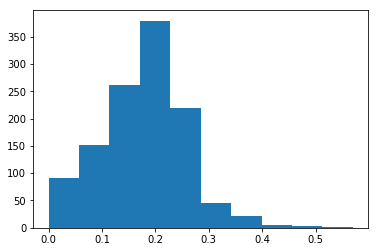

(-0.031766000000000003, 3.6495289999999998)


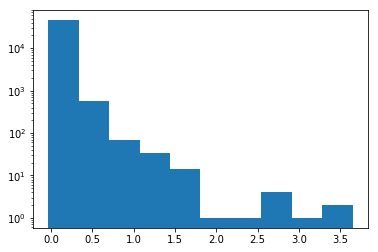

a3
sim<0
sim>0
MACHO<0
MACHO>0
(-0.13264580331135759, 0.44101326502039451)


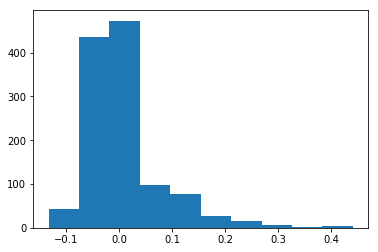

(-0.538628, 1.7927960000000001)


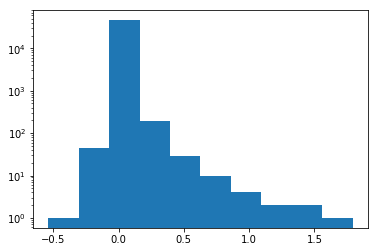

a4
sim<0
sim>0
MACHO<0
MACHO>0
(-0.0014307579813685807, 0.39832716425780706)


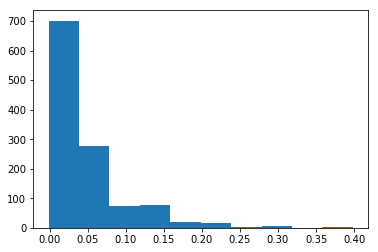

(-0.35581699999999999, 2.053687)


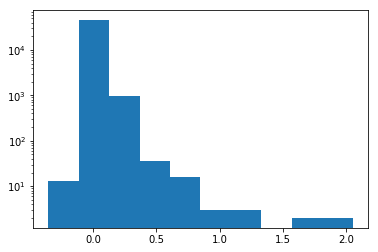

b1
sim<0
sim>0
MACHO<0
MACHO>0
(-0.0046791530068625549, 7.4570332405729298e-05)


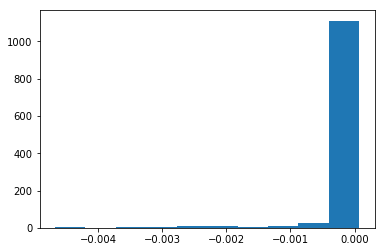

(-1.1682760000000001, 0.92423)


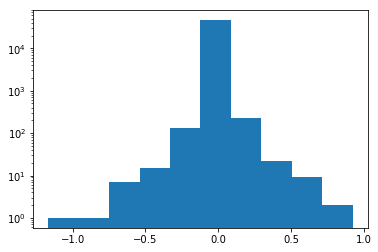

b2
sim<0
sim>0
MACHO<0
MACHO>0
(-0.0035313607548872225, 1.3138716530247093e-05)


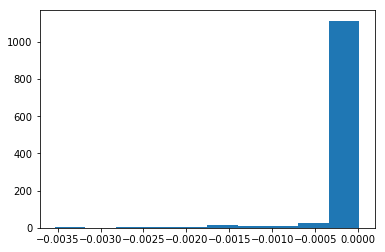

(-2.157978, 1.5119560000000001)


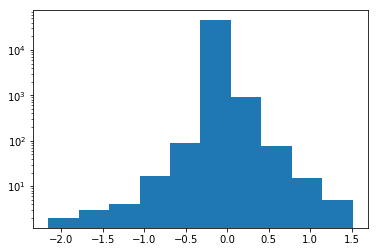

b3
sim<0
sim>0
MACHO<0
MACHO>0
(-0.00081290264926926162, 0.00013216666753517597)


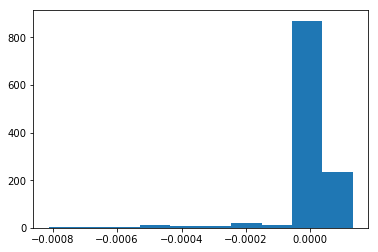

(-0.58410099999999998, 1.61378)


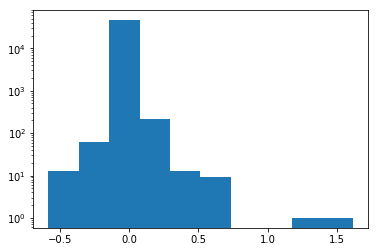

b4
sim<0
sim>0
MACHO<0
MACHO>0
(-0.00010555493019192708, 0.0040688657892930108)


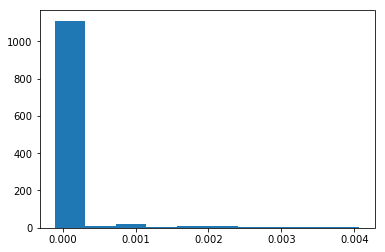

(-1.2330509999999999, 0.68133699999999997)


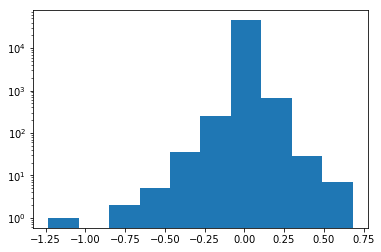

In [70]:
b=['a1','a2','a3','a4','b1','b2','b3','b4']
for i in [0,1,2,3,4,5,6,7]:
    print(b[i])
    Sd=np.concatenate((BHdata[:,i],nBHdata[:,i]))
    Md=MACHOdata['col%g'%(i+2)]
    if np.any(Sd<0): print('sim<0')
    if np.any(Sd>0): print('sim>0')
    if np.any(Md<0): print('MACHO<0')
    if np.any(Md>0): print('MACHO>0')
    plt.hist(Sd)
    print(np.min(Sd),np.max(Sd))
    plt.show()
    plt.hist(Md)
    plt.yscale('log')
    print(np.min(Md),np.max(Md))
    plt.show()

145.33110.191:	 p(BH)=-27.6168, p(nBH)=-73.4603
158.26798.41:	 p(BH)=-44.9175, p(nBH)=-23.6214
156.27342.64:	 p(BH)=-6.65909, p(nBH)=1.17246
158.26541.309:	 p(BH)=-34.8645, p(nBH)=-119.992
148.25543.94:	 p(BH)=-0.948122, p(nBH)=-1.38368
105.21815.2462:	 p(BH)=-41.5866, p(nBH)=-94.7664
108.19337.365:	 p(BH)=-80.4621, p(nBH)=-145.524
162.25085.6313:	 p(BH)=-78.0756, p(nBH)=-102.089
161.25085.350:	 p(BH)=-34.53, p(nBH)=-52.0767
159.25875.613:	 p(BH)=-62.6421, p(nBH)=-123.327
103.24804.5725:	 p(BH)=-82.0115, p(nBH)=-85.6999
128.22188.4004:	 p(BH)=-27.8283, p(nBH)=-6.29489
122.23469.380:	 p(BH)=-4.35077, p(nBH)=-8.20943
148.25942.122:	 p(BH)=-77.0598, p(nBH)=-82.7745
109.20762.370:	 p(BH)=-134.14, p(nBH)=-183.125
140.33251.634:	 p(BH)=13.2818, p(nBH)=14.3631
118.18789.290:	 p(BH)=-19.8858, p(nBH)=-5.70919
102.22723.351:	 p(BH)=-202.723, p(nBH)=-303.572
109.19987.1156:	 p(BH)=-70.8795, p(nBH)=-105.403
155.25916.53:	 p(BH)=-170.888, p(nBH)=-195.681
115.23216.378:	 p(BH)=-53.8956, p(nBH)=-74.5

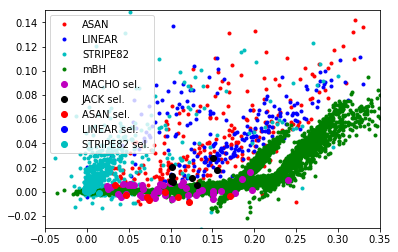

In [36]:
JACKdata=Table.read("/net/geha/mw698/MACHO/Jack_MACHO_a_par.dat",format='ascii')
JACK=[[str(line[0]),abs(line[1]),line[2],abs(line[3]),line[4]] for line in JACKdata]
JACKkeys, JACKselected2=foo2(JACK,gmm_best,tol=1.5,nmodel=ngmm_best,iprint=True,selcrit=2)
print(len(JACKkeys))
print(JACKkeys)

plt.plot(ASANdata['col3'],ASANdata['col5'],'r.',label='ASAN')
plt.plot(LINEARdata['col3'],LINEARdata['col5'],'b.',label='LINEAR')
plt.plot(STRIPE82data['col3'],STRIPE82data['col5'],'c.',label='STRIPE82')
plt.plot(m[:,1],m[:,3],'g.',label='mBH')
plt.plot(MACHOselected2[:,1],MACHOselected2[:,3],'mo',label='MACHO sel.')
plt.plot(JACKselected2[:,1],JACKselected2[:,3],'ko',label='JACK sel.')
plt.plot(ASANselected2[:,1],ASANselected2[:,3],'ro',label='ASAN sel.')
plt.plot(LINEARselected2[:,1],LINEARselected2[:,3],'bo',label='LINEAR sel.')
plt.plot(STRIPE82selected2[:,1],STRIPE82selected2[:,3],'co',label='STRIPE82 sel.')
plt.legend()
plt.xlim(-0.05,0.35)
plt.ylim(-0.03,0.15)
plt.show()

In [8]:
np.full((1,3),-99)[:,1]

array([-99])

In [33]:
for i in range(len(MACHOselected2)):
    if MACHOselected2[i][1]>0.2:# and 0.04<MACHOselected2[i][1]<0.06:
        print(MACHOkeys[i],MACHOselected2[i])

('131.29605.2086', array([ 0.032162,  0.226813,  0.037946,  0.045613]))
('134.33643.442', array([ 0.017084,  0.203519,  0.022049,  0.031601]))
('163.27427.3020', array([ 0.018495,  0.207431,  0.017404,  0.00734 ]))
('1.3451.1522', array([ 0.053596,  0.224069,  0.01187 , -0.006233]))
('36.5939.74', array([ 0.025736,  0.206144,  0.023   ,  0.026111]))


In [23]:
MACHOfields=[]
fieldlist=[item.split('.')[0] for item in MACHOkeys]
for field in fieldlist:
    if int(field) not in MACHOfields:
        MACHOfields.append(int(field))
MACHOfields.sort()
print(MACHOfields)

[1, 2, 3, 6, 9, 17, 18, 32, 35, 36, 44, 45, 56, 57, 58, 61, 62, 66, 76, 77, 103, 107, 109, 110, 111, 115, 119, 120, 121, 122, 127, 128, 131, 132, 134, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 149, 150, 152, 153, 155, 157, 158, 159, 161, 162, 163, 166, 167, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 301, 306, 307, 309, 311]


50000
CPU times: user 3.33 s, sys: 61 ms, total: 3.39 s
Wall time: 1.57 s


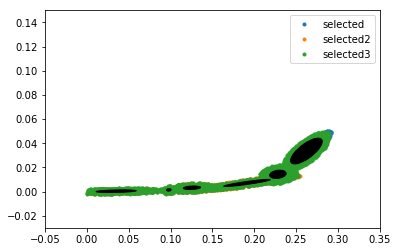

In [232]:
%%time
fake=np.array([[np.random.uniform(0,0.3),np.random.uniform(-0.02,0.1)] for i in range(50000)])
selected=foo(fake,gmm_best,tol=1)
selected2=foo2(fake,gmm_best,tol=4.5)
selected3=foo2(fake,gmm_best,tol=6,weighted=False)

m,l=gmm_best.sample(5000)
#plt.plot(nBHdata[:,1],nBHdata[:,3],'.',label='nBH')
#plt.plot(fake[:,0],fake[:,1],'.',label='FAKE')
plt.plot(selected[:,0],selected[:,1],'.',label='selected')
plt.plot(selected2[:,0],selected2[:,1],'.',label='selected2')
plt.plot(selected3[:,0],selected3[:,1],'.',label='selected3')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1], fc='k', ec='k',zorder=3)
#plt.plot(m[:,0],m[:,1],'.',label='mBH')
plt.legend()
plt.xlim(-0.05,0.35)
plt.ylim(-0.03,0.15)

In [16]:
cand=0
for item in BHdata:
    if abs(item[1]-0.20256)/0.20256<0.01 and abs(item[3])<2e-2:
        cand+=1
        print(item)
print(cand)

[ -4.40195690e-02   2.04143445e-01  -2.72057948e-02   1.36798809e-02
   1.46201946e-05  -1.35604012e-04   2.71075139e-05  -1.81739538e-05
   2.53357077e+00]
[ -4.40103783e-02   2.04106455e-01  -2.71999454e-02   1.36754933e-02
   1.46171368e-05  -1.35579447e-04   2.71017064e-05  -1.81681415e-05
   2.53337551e+00]
2


In [23]:
good=[]
for k,data in zip(MACHOkeys,MACHOselected2):
    if data[1]>0.16:
        print(k,data)
        good.append(k)
print(good)

('107.25577.218', array([ 0.045526,  0.185781,  0.034744,  0.01069 ]))
('155.26050.495', array([ 0.011419,  0.184037,  0.006959,  0.00641 ]))
('158.26799.89', array([ 0.02296 ,  0.240172,  0.012497,  0.009213]))
('2.4909.983', array([ 0.03439 ,  0.169548,  0.035591,  0.004575]))
('308.37593.20', array([ 0.008429,  0.168857,  0.004153,  0.005934]))
['107.25577.218', '155.26050.495', '158.26799.89', '2.4909.983', '308.37593.20']
